In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from test import evaluate_test_set
import sts_data
from importlib import reload
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib as plt

2022-02-25 18:08:48.653045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 18:08:48.653072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import pandas as pd
from preprocess import Preprocess
import logging
import torch
import re
from dataset import STSDataset
from datasets import load_dataset,Dataset
import spacy
import torchtext
from torchtext.data import get_tokenizer
from spacy.lang.en import English
from torchtext.legacy.data import Field
from torch.utils.data import DataLoader
import numpy as np

In [4]:
# dataset = load_dataset('text', data_files='SICK.txt')
# dataset
columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
stopwords_path="stopwords-en.txt"
columns_mapping.values()

dict_values(['sentence_A', 'sentence_B', 'relatedness_score'])

In [5]:
sick_dataset = load_dataset('sick',download_mode='reuse_cache_if_exists')
sick_dataset=sick_dataset.remove_columns(['label','id','entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'])
train_pd=pd.DataFrame.from_dict(sick_dataset['train'])
validation_pd=pd.DataFrame.from_dict(sick_dataset['validation'])
test_pd=pd.DataFrame.from_dict(sick_dataset['test'])
sick_data=[train_pd,validation_pd,test_pd]
# sick_df = pd.DataFrame(data=sick_dataset.data, columns=sick_dataset.column_names)
# sen_A=columns_mapping['sent1']
# sen_B= columns_mapping['sent2']
# score=columns_mapping['label']
# sick_df=sick_df[[sen_A,sen_B,score]]
# pd.read_csv(dataset)

Dataset sick downloaded and prepared to /home/ibrahimssd/.cache/huggingface/datasets/sick/default/0.0.0/c6b3b0b44eb84b134851396d6d464e5cb8f026960519d640e087fe33472626db. Subsequent calls will reuse this data.


In [6]:
# sick_dataset['train']
# Dataset.from_pandas(tran_pd)
splits= list(sick_dataset.keys())
type(sick_dataset)
len(train_data_df)
4439/64

NameError: name 'train_data_df' is not defined

In [ ]:
import re
import string

"""
Performs basic text cleansing on the unstructured field 
"""


class Preprocess:
    def __init__(self, stpwds_file_path):
        """
        Initializes regex patterns and loads stopwords
        """
        # TODO implement
        with open(stpwds_file_path) as fh:
            self.stopwords=list(set(fh.read().split()))
        self.noise_re = re.compile('\\b(%s)\\W'%('|'.join(map(re.escape,self.stopwords))),re.I)
    

    def perform_preprocessing(self, data, columns_mapping):
        sen_A=columns_mapping['sent1']
        sen_B= columns_mapping['sent2']
        score=columns_mapping['label']
        cleaned_data=[]
        for data_frame in data:
            groupA=list(data_frame[sen_A])
            groupB=list(data_frame[sen_B])
            ## normalize text to lower case
            groupA=[x.lower() for x in groupA]
            groupB=[x.lower() for x in groupB]
            ## remove punctuations
            groupA=[''.join(c for c in x if c not in string.punctuation) for x in groupA]
            groupB=[''.join(c for c in x if c not in string.punctuation) for x in groupB]
            ## remove stopwords
            groupA=[self.noise_re.sub('',p) for p in groupA]
            groupB=[self.noise_re.sub('',p) for p in groupB]
            # Trim extra whitespace
            groupA=[' '.join(x.split()) for x in groupA]
            groupB=[' '.join(x.split()) for x in groupB]
            # Remove numbers
            groupA=[''.join(c for c in x if c not in '0123456789') for x in groupA]
            groupB=[''.join(c for c in x if c not in '0123456789') for x in groupB]
            ## return data_back to DataFrame
            data_frame[sen_A]=groupA
            data_frame[sen_B]=groupB
            cleaned_data.append(data_frame)
        
        
        sick_dataset={'train':Dataset.from_pandas(cleaned_data[0]),
                      'validation':Dataset.from_pandas(cleaned_data[1]),
                      'test':Dataset.from_pandas(cleaned_data[2])}
        data_frame=pd.concat(cleaned_data, ignore_index=True)
        
        return sick_dataset


In [ ]:
process=Preprocess(stopwords_path)
formatted_data=process.perform_preprocessing(sick_data,columns_mapping)


In [ ]:
train_data= pd.DataFrame(formatted_data['train'])

In [ ]:
cols = list(columns_mapping.values())
cols.pop()
sen_list=list(train_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1))
sen_str = ' '.join(map(str, sen_list))
print(len(sen_list))

In [ ]:
# Word tokenization
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()
text = """When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!"""

#  "nlp" Object is used to create documents with linguistic annotations.
my_doc = nlp(sen_str)

# Create list of word tokens
token_list = []
for token in my_doc:
    token_list.append(token.text)
# print(token_list)

In [ ]:
from torchtext.vocab import vocab
from collections import Counter, OrderedDict
counter = Counter(token_list)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
v= vocab(ordered_dict)

PAD_token = 0   # Used for padding short sentences
SOS_token = 1   # Start-of-sentence token
EOS_token = 2   # End-of-sentence token
special_words={PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
default_index = -1
v.set_default_index(default_index)
for key , value in special_words.items():
    if value not in v: v.insert_token(value, key)



In [ ]:
with open(stopwords_path) as fh:
            stopwords=list(set(fh.read().split()))

In [ ]:
train_data['sentenceA&B']=train_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
text_field = Field(
#     tokenize='basic_english', 
    lower=True,
    include_lengths=True,
    pad_token='PAD',
    pad_first='SOS',
    stop_words=stopwords,
)

# label_field = Field(sequential=False, use_vocab=False)
preprocessed_text = train_data['sentenceA&B'].apply(lambda x: text_field.preprocess(x))
text_field.build_vocab(
    preprocessed_text, 
    vectors='fasttext.simple.300d')

# get the vocab instance
vocab = text_field.vocab

In [ ]:
preprocessed_text
len(vocab.itos)

In [ ]:
# def data2tensors(self, data):
#         """
#         Converts raw data sequences into vectorized sequences as tensors
#         """
#         pass
#         # TODO implement

# def get_data_loader(self, batch_size=8):
#         pass
#         # TODO implement

# def sort_batch(self, batch, targets, lengths):
#         """
#         Sorts the data, lengths and target tensors based on the lengths
#         of the sequences from longest to shortest in batch
#         """
#         sents1_lengths, perm_idx = lengths.sort(0, descending=True)
#         sequence_tensor = batch[perm_idx]
#         target_tensor = targets[perm_idx]
#         return sequence_tensor.transpose(0, 1), target_tensor, sents1_lengths

# def vectorize_sequence(self, sentence):
#         """
#         Replaces tokens with their indices in vocabulary
#         """
#         pass
#         # TODO implement

# def pad_sequences(self, vectorized_sents, sents_lengths):
#         """
#         Pads zeros at the end of each sequence in data tensor till max
#         length of sequence in that batch
#         """
#         pass
#         # TODO implement
# def encode(vocab,string):
#        return vocab[string]
        

In [ ]:
# train_data['sentenceA&B'][0].apply(lambda x: print(x) )

In [ ]:
def vectorize_sequence(sentence):
        """
        Replaces tokens with their indices in vocabulary
        """
        splited_sentence=sentence.split()
        encodes=[vocab[token] for token in splited_sentence]
        return encodes

In [ ]:
cols = list(columns_mapping.values())
cols.pop()
train_data= pd.DataFrame(formatted_data['train'])
val_data=pd.DataFrame(formatted_data['validation'])
test_data=pd.DataFrame(formatted_data['test'])
train_data['sentenceA&B']=train_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
val_data['sentenceA&B']=val_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_data['sentenceA&B']=test_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

codes=[]
for sentence in val_data['sentenceA&B']:
    encodes= vectorize_sequence(sentence)
    codes.append(encodes)
val_data['sentenceA&B'] = codes
val_data

In [ ]:
def data2tensors(data):
        """
        Converts raw data sequences into vectorized sequences as tensors
        """
        
        
        
        data['sent1_tensor']=data['sent1_tensor'].apply(lambda lis : torch.as_tensor(lis))
        data['sent2_tensor']=data['sent2_tensor'].apply(lambda lis : torch.as_tensor(lis))
           
        
        
        return data
    

In [ ]:
# pd.DataFrame(data2tensors(formatted_data)['train'])["sentenceA&B"]

In [ ]:
dataloaders = {x:DataLoader(formatted_data[x],32, shuffle=True, num_workers=4) for x in ['train','validation','test']}

In [ ]:
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# train_features, train_labels = next(iter(dataloaders['train']))
# from torch.utils import data
# train_tensor = data.TensorDataset(train_data, train_label)

In [ ]:
# from torch.utils import data
# train_tensor = data.TensorDataset(train_data, train_label)

In [ ]:
# dataloaders = {'train': torch.utils.data.DataLoader(STSDataset(sts_train_df, batch_size=64)),
#                'val': torch.utils.data.DataLoader(STSDataset(sts_dev_df, batch_size=64))}


In [ ]:
# train_target = torch.tensor(train['Target'].values.astype(np.float32))
# train = torch.tensor(train.drop('Target', axis = 1).values.astype(np.float32)) 
# train_tensor = data_utils.TensorDataset(train, train_target) 
# train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [ ]:
train_data_df= pd.DataFrame(formatted_data['train'])
val_data_df=pd.DataFrame(formatted_data['validation'])
test_data_df=pd.DataFrame(formatted_data['test'])

In [ ]:
train_data_df['sent1_tensor']=train_data_df['sentence_A'].apply(lambda sen: vectorize_sequence(sen))
train_data_df['sent2_tensor']=train_data_df['sentence_B'].apply(lambda sen: vectorize_sequence(sen))

In [ ]:
# train_data_df = torch.tensor(train_data_df['sentence_A'].values.astype(np.float32))
train_data_df=data2tensors(train_data_df)
train_data_df['sents1_length_tensor']=train_data_df['sent1_tensor'].apply(lambda tensor : torch.tensor(len(tensor)))
train_data_df['sents2_length_tensor']=train_data_df['sent2_tensor'].apply(lambda tensor : torch.tensor(len(tensor)))

In [ ]:
#import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# padded=pad_sequences(train_data_df['sent1_tensor'],padding="post",truncating=”post”,maxlen=8)


In [ ]:
def pad_sequences(sequences):
        """
        :param sequences: list of tensors
        :return:
        """
        num = len(sequences)
        max_len = max([s.shape[0] for s in sequences])
        out_dims = (num, max_len, *sequences[0].shape[1:])
        out_tensor = sequences[0].data.new(*out_dims).fill_(0)
        mask = sequences[0].data.new(*out_dims).fill_(0)
        for i, tensor in enumerate(sequences):
            length = tensor.size(0)
            out_tensor[i, :length] = tensor
            mask[i, :length] = 1
        return list(out_tensor)

In [ ]:
train_data_df['sent1_tensor']=pad_sequences(train_data_df['sent1_tensor'])
train_data_df['sent2_tensor']=pad_sequences(train_data_df['sent2_tensor'])

In [ ]:
train_data_df['relatedness_score']=train_data_df['relatedness_score'].apply(lambda score : torch.tensor(score/sum(train_data_df['relatedness_score'])))

In [ ]:
"""
Standard Pytorch Dataset class for loading datasets.
"""


class STSDataset(Dataset):
    def __init__(
        self,
        sent1_tensor,
        sent2_tensor,
        target_tensor,
        sents1_length_tensor,
        sents2_length_tensor,
        raw_sents_1,
        raw_sents_2,
    ):
        """
        initializes  and populates the the length, data and target tensors, and raw texts list
        """
        
        assert (
            
            
            len(sent1_tensor)
            == torch.tensor(list(target_tensor)).size(0)
            == len(sent2_tensor)
            == torch.tensor(list(sents1_length_tensor)).size(0)
            == torch.tensor(list(sents2_length_tensor)).size(0)
        )
        self.sent1_tensor = sent1_tensor
        self.sent2_tensor = sent2_tensor
        self.target_tensor = target_tensor
        self.sents1_length_tensor = sents1_length_tensor
        self.sents2_length_tensor = sents2_length_tensor
        self.raw_sents_1 = raw_sents_1
        self.raw_sents_2 = raw_sents_2

    def __getitem__(self, index):
        """
        returns the tuple of data tensor, targets, lengths of sequences tensor and raw texts list
        """
        return (
            self.sent1_tensor[index],
            self.sent2_tensor[index],
            self.sents1_length_tensor[index],
            self.sents2_length_tensor[index],
            self.target_tensor[index],
            self.raw_sents_1[index],
            self.raw_sents_2[index],
        )

    def __len__(self):
        """
        returns the length of the data tensor.
        """
        return torch.tensor(list(self.target_tensor)).size(0)


In [ ]:
train_data_df                       

In [ ]:
train_dataset=  STSDataset(train_data_df['sent1_tensor'],
                         train_data_df['sent2_tensor'],
                         train_data_df['relatedness_score'],
                         train_data_df['sents1_length_tensor'],
                         train_data_df['sents2_length_tensor'],
                         train_data_df['sentence_A'],
                         train_data_df['sentence_B']
                         )

train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [ ]:
# len(train_data_df['sent1_tensor'])
# train_data_df['sents1_length_tensor'].size()
# torch.tensor(list(target_tensor)).size(0)
# train_data_df['sent1_tensor'][0]
# train_data_df['relatedness_score'][0]
# train_data_df['sents1_length_tensor'][0]
# train_data_df['sentence_A'][0]

In [ ]:
train_data_df['relatedness_score'][0].size()

In [ ]:
train_loader

In [ ]:
dataiter = iter(train_loader)
len(dataiter.next())

In [ ]:
for batch in train_loader:
    print(batch)
    break

In [ ]:
batch[0]

In [ ]:
n, d, m = 3, 5, 7
embedding = torch.nn.Embedding(n, d, max_norm=True)
W = torch.randn((m, d), requires_grad=True)
idx = torch.tensor([1, 2])
# a = embedding.weight.clone() @ W.t()  # weight must be cloned for this to be differentiable
# b = embedding(idx) @ W.t()  # modifies weight in-place
# out = (a.unsqueeze(0) + b.unsqueeze(1))
# loss = out.sigmoid().prod()
# loss.backward()

In [ ]:
embedding(idx)

In [ ]:
vocab_size= len(vocab)
embedding_size= 300

In [ ]:
embedding = torch.nn.Embedding(vocab_size, embedding_size, max_norm=True)

In [ ]:
sen=torch.tensor([[121,  82,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 36,   4, 404,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [ ]:
embedding(sen).size()

In [ ]:
vocab.vectors[sen]

In [ ]:
embedding_weights= vocab.vectors
net = torch.nn.LSTM(10, 20, 1)

In [ ]:
def similarity_score(input1, input2):
    # Get similarity predictions:
    dif = input1.squeeze() - input2.squeeze()

    norm = torch.norm(dif, p=1, dim=dif.dim() - 1)
    y_hat = torch.exp(-norm)
    y_hat = torch.clamp(y_hat, min=1e-7, max=1.0 - 1e-7)
    return y_hat


In [ ]:
from sts_data import STSData

columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
dataset_name = "sick"
sick_data = STSData(
    dataset_name=dataset_name,
    columns_mapping=columns_mapping,
    normalize_labels=True,
    normalization_const=5.0,
)
batch_size = 64
sick_dataloaders = sick_data.get_data_loader(batch_size=batch_size)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from utils import similarity_score


"""
Wrapper class using Pytorch nn.Module to create the architecture for our model
Architecture is based on the paper: 
A STRUCTURED SELF-ATTENTIVE SENTENCE EMBEDDING
https://arxiv.org/pdf/1703.03130.pdf
"""


class SiameseBiLSTMAttention(nn.Module):
    def __init__(
        self,
        batch_size,
        output_size,
        hidden_size,
        vocab_size,
        embedding_size,
        embedding_weights,
        lstm_layers,
        device,
        bidirectional,
        self_attention_config,
        fc_hidden_size,
    ):
        super(SiameseBiLSTMAttention, self).__init__()
        """
        Initializes model layers and loads pre-trained embeddings from task 1
        """
        ## model hyper parameters
        self.batch_size = batch_size
        self.output_size = output_size
        self.lstm_hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.lstm_layers = lstm_layers
        self.device = device
        self.bidirectional = bidirectional
        self.fc_hidden_size = fc_hidden_size
        self.lstm_directions = (
            2 if self.bidirectional else 1
        )  ## decide directions based on input flag
        
        
        
        ## model layers
        # TODO initialize the look-up table.
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        # TODO assign the look-up table to the pre-trained fasttext word embeddings.
        
        self.lookup= embedding_weights   #self.embeddings
        
        ## TODO initialize lstm layer
        self.bi_lstm = torch.nn.LSTM(self.embedding_size, self.lstm_hidden_size, 
                            lstm_layers, batch_first=True , bias= True,bidirectional=True)
        
        ## TODO initialize self attention layers
        self.SelfAtt= SelfAttention(2*self.lstm_hidden_size, self_attention_config['hidden_size'],
                                    self_attention_config['output_size'])
        
        #Initialize fully connected layer
        self.fc = nn.Linear(2*self.lstm_hidden_size * self_attention_config['output_size'], self.fc_hidden_size )
        self.tanh = nn.Tanh()
        ## incase we are using bi-directional lstm we'd have to take care of bi-directional outputs in
        ## subsequent layers
        
        

    def init_hidden(self, batch_size):
        """
        Initializes hidden and context weight matrix before each
                forward pass through LSTM
        """
        h0 = torch.randn(self.lstm_directions*self.lstm_layers, batch_size, self.lstm_hidden_size)
        c0 = torch.randn(self.lstm_directions*self.lstm_layers, batch_size, self.lstm_hidden_size)
        
        return h0, c0 

    def forward_once(self, batch, lengths):
        """
        Performs the forward pass for each batch
        """

        ## batch shape: (batch_size, seq_len)
        batch_size , sequence_len = batch.size()
        ## embeddings shape: ( batch_size, seq_len, embedding_size)
        
        #h_init,c_init = self.init_hidden(batch_size)
        input_batch_sequences= self.lookup[batch]
        
        output, (hn, cn) = self.bi_lstm(input_batch_sequences, (self.h_init, self.c_init))

        return output , (hn , cn)

    def forward(self, sent1_batch, sent2_batch, sent1_lengths, sent2_lengths):
        """
        Performs the forward pass for each batch
        """
        
        
        ## init context and hidden weights for lstm cell
        self.h_init,self.c_init = self.init_hidden(self.batch_size)
        output1,_ = self.forward_once(sent1_batch,sent1_lengths)
        self.h_init,self.c_init = self.init_hidden(self.batch_size)
        output2,_ = self.forward_once(sent2_batch,sent2_lengths)
        
        ## Self attention Layer
        attended_embeddings_sent1, attention_matrix_sent1 = self.SelfAtt.forward(output1)
        attended_embeddings_sent2, attention_matrix_sent2 = self.SelfAtt.forward(output2)
        
        ## Fully connected layer 
        
        final_embeddings_sent1= self.tanh(self.fc(attended_embeddings_sent1.reshape(output1.size(0),-1)))
        final_embeddings_sent2= self.tanh(self.fc(attended_embeddings_sent2.reshape(output2.size(0),-1)))
        
        
        #similarity score prediction
        predictions = similarity_score(final_embeddings_sent1, final_embeddings_sent2)
        
        print(torch.cat((attention_matrix_sent1, attention_matrix_sent2), 1).size())
        return predictions , 

class SelfAttention(nn.Module):
    """
    Implementation of the attention block
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(SelfAttention, self).__init__()
        # TODO implement
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.ws1 = nn.Linear(input_size, hidden_size, bias=False)
        self.ws2 = nn.Linear(hidden_size, output_size, bias=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        
        
    ## the forward function would receive lstm's all hidden states as input
    def forward(self, attention_input):
        # TODO implement
        #pass
        
        size = attention_input.size()
        inp = attention_input.reshape(size[0]*size[1],size[2])
        attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
        attention_matrix= attention_matrix.reshape(size[0], self.output_size, -1)
        attended_embeddings_sent1= torch.bmm(attention_matrix , attention_input)
        
        return attended_embeddings_sent1, attention_matrix

In [ ]:
batch_size = 64
output_size = 1
hidden_size = 128
vocab_size = len(vocab)
embedding_size = 300
embedding_weights = vocab.vectors
lstm_layers = 4
learning_rate = 1e-1
fc_hidden_size = 64
max_epochs = 5
bidirectional = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## self attention config
self_attention_config = {
    "hidden_size": 150,  ## refers to variable 'da' in the ICLR paper
    "output_size": 20,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.0,  ## refers to penalty coefficient term in the ICLR paper
}

In [ ]:
## init siamese lstm
siamese_lstm_attention = SiameseBiLSTMAttention(
    batch_size=batch_size,
    output_size=output_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    lstm_layers=lstm_layers,
    self_attention_config=self_attention_config,
    fc_hidden_size=fc_hidden_size,
    device=device,
    bidirectional=bidirectional,
)
## move model to device
optimizer = torch.optim.Adam(params=siamese_lstm_attention.parameters())
siamese_lstm_attention.to(device)

In [ ]:
siamese_lstm_attention.forward(batch[0],batch[1],7,4)

In [ ]:
import torch
from torch import nn
import logging
from tqdm import tqdm
from torch.autograd import Variable


logging.basicConfig(level=logging.INFO)

"""
Script for training the neural network and saving the better models 
while monitoring a metric like accuracy etc
"""


def train_model(model, optimizer, dataloader, data, max_epochs, config_dict):
    device = config_dict["device"]
    criterion = nn.MSELoss()
    max_accuracy = 5e-1
    train_loader , val_loader , test_loader = dataloader
    dictionary_info={}
    for epoch in tqdm(range(max_epochs)):
        
        try:
            # Samples the batch
            sent1_batch, sent2_batch, sent1_lengths, sent2_lengths,targets,raw_sent1,raw_sent2= next(iter(dataloader))

        except StopIteration:
            # restart the generator if the previous generator is exhausted.
            train_generator = iter(train_loader)
            sent1_batch, sent2_batch, sent1_lengths, sent2_lengths,targets,raw_sent1,raw_sent2= next(iter(dataloader))
        
        
        predictions , attention_matrix = model.forward(sent1_batch, sent2_batch, sent1_lengths, sent2_lengths)
        optimizer.zero_grad()
        
        try:
             train_loss = criterion(predictions,targets) + attention_penalty_loss(attention_matrix, 
                                                                  config_dict['self_attention_config']['penalty'], device)
                       
        except RuntimeError:
            
            raise Exception("Model Loss gets nan values on regularization.Either remove regularization or add very small values")
        
        optimizer.step()
        
        # TODO: computing accuracy using sklearn's function
        ## acc = 
        #accuracy = (torch.argmax(predictions, axis=-1) == targets).float().mean()
        
        acc=accuracy_score(targets, predictions)
        
        ## compute model metrics on dev set
        val_acc, val_loss = evaluate_dev_set(
            model, data, criterion, dataloader, config_dict, device
        )

        
        
        if val_acc > max_accuracy:
            max_accuracy = val_acc
            logging.info(
                "new model saved")  
            
            ## save the model if it is better than the prior best
            torch.save(model.state_dict(), "{}.pth".format(config_dict["model_name"]))

        logging.info(
            "Train loss: {} - acc: {} -- Validation loss: {} - acc: {}".format(
                torch.mean(train_loss.data.float()), acc, val_loss, val_acc
            )
        )
        
        if epoch % 100 == 0:
              print('[%d/%d] loss: %.3f, accuracy: %.3f' %
                   (i , max_epochs - 1, loss.item(), acc.item()))
        if epoch == max_epochs - 1:
               print('Final accuracy: %.3f, expected %.3f' %
                         (accuracy.item(), 1.0))
        
    return model


def evaluate_dev_set(model, data, criterion, data_loader, config_dict, device):
    """
    Evaluates the model performance on dev data
    """
    logging.info("Evaluating accuracy on dev set")

    # TODO implement
    pass

def attention_penalty_loss(annotation_weight_matrix, penalty_coef, device):
    """
    This function computes the loss from annotation/attention matrix
    to reduce redundancy in annotation matrix and for attention
    to focus on different parts of the sequence corresponding to the
    penalty term 'P' in the ICLR paper
    ----------------------------------
    'annotation_weight_matrix' refers to matrix 'A' in the ICLR paper
    annotation_weight_matrix shape: (batch_size, attention_out, seq_len)
    """
    
    batch_size, attention_out_size = annotation_weight_matrix.size(0), annotation_weight_matrix.size(1)
    annotation_weight_matrix_trans = torch.transpose(annotation_weight_matrix, 0, 1)
    identity = torch.eye(annotation_weight_matrix.size(0))
    annotation_mul_difference=annotation_weight_matrix@annotation_weight_matrix_trans - identity
    penalty = frobenius_norm(annotation_mul_difference)
    return penalty_coef*penalty


def frobenius_norm(annotation_mul_difference):
    """
    Computes the frobenius norm of the annotation_mul_difference input as matrix
    """
   
    """
    
 
    Args:
      annotation_mul_difference= ||AAT - I||
 
    Returns:
            regularized value
 
       
        """
    
#    torch.norm(annotation_mul_difference.float(), p='fro')
#     torch.sum(torch.sum(torch.sum(annotation_mul_difference**2,1),1)**0.5).type(torch.DoubleTensor)
    return torch.sqrt(torch.sum(annotation_mul_difference**2))

In [ ]:
siamese_lstm_attention = train_model(
    model=siamese_lstm_attention,
    optimizer=optimizer,
    dataloader=train_loader,
    data=sick_data,
    max_epochs=max_epochs,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

In [ ]:
train_dataset=  STSDataset(train_data_df['sent1_tensor'],
                         train_data_df['sent2_tensor'],
                         train_data_df['relatedness_score'],
                         train_data_df['sents1_length_tensor'],
                         train_data_df['sents2_length_tensor'],
                         train_data_df['sentence_A'],
                         train_data_df['sentence_B']
                         )

train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [ ]:
# main training loop
# train_loader , val_loader , test_loader = sick_dataloaders
train_generator = iter(train_loader)
for i in range(100):
    try:
        # Samples the batch
        sent1_batch, sent2_batch, sent1_lengths, sent2_lengths, targets,raw_sent1,raw_sent2= next(train_generator)
        print(Variable(targets))
        break
    except StopIteration:
        # restart the generator if the previous generator is exhausted.
        train_generator = iter(train_loader)
        sent1_batch, sent2_batch, sent1_lengths, sent2_lengths, targets,raw_sent1,raw_sent2= next(train_generator)

In [ ]:
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])

In [ ]:
vocab.vectors[input]
embedding = nn.Embedding(len(vocab), 300)
embedding(input)

In [ ]:
vocab.vectors.size()

In [ ]:
# with torch.no_grad():
a=torch.randn([64, 40, 14])
at= np.transpose(a, (0, 2, 1)).clone().detach().requires_grad_(True)
# frobenius_norm(a)
diff=a@at-torch.eye(a.size(1))
diff.size()

In [ ]:
att=torch.randn([64, 40, 14])
attT = att.transpose(1,2)
identity = torch.eye(att.size(1))
identity = Variable(identity.unsqueeze(0).expand(train_loader.batch_size,att.size(1),att.size(1)))
diff=att@attT - identity
diff.size()

In [ ]:
identity

In [88]:
t1=torch.tensor([0.3724, 0.4367, 0.3584, 0.4131, 0.4151, 0.3754, 0.4444, 0.3806, 0.4540,
        0.3293, 0.4363, 0.3715, 0.4190, 0.4442, 0.4099, 0.4260, 0.3768, 0.4290,
        0.4401, 0.4283, 0.3629, 0.3899, 0.3863, 0.4223, 0.4615, 0.4136, 0.3793,
        0.4060, 0.4051, 0.4540, 0.4548, 0.4677, 0.4346, 0.3802, 0.3646, 0.4234,
        0.4135, 0.3769, 0.4404, 0.3910, 0.4340, 0.4046, 0.3871, 0.3655, 0.4430,
        0.4434, 0.3824, 0.4189, 0.4324, 0.3946, 0.3496, 0.4714, 0.4147, 0.4114,
        0.4263, 0.4088, 0.3955, 0.3722, 0.4222, 0.3962, 0.3961, 0.4276, 0.3328,
        0.3668]) 
t2=torch.tensor([0.7000, 0.1750, 0.5750, 0.8250, 0.3250, 0.4750, 0.8500, 0.7750, 0.5750,
        0.6000, 0.5750, 0.4500, 0.6500, 0.6750, 0.7750, 0.9250, 0.1000, 0.8750,
        0.5250, 0.6500, 0.5750, 0.3000, 0.0000, 0.6750, 0.0250, 0.7750, 0.9500,
        0.6250, 0.3250, 0.9500, 0.6250, 0.5750, 0.7250, 0.4000, 0.9000, 0.7250,
        0.9750, 0.0000, 0.5500, 0.6000, 0.8250, 0.2500, 0.7000, 0.9750, 0.8750,
        0.5750, 0.6750, 0.6500, 0.0750, 0.9000, 0.1500, 0.8750, 0.7250, 0.6500,
        0.8250, 0.5750, 0.5000, 0.7750, 0.5250, 0.0250, 0.9000, 0.5750, 0.7500,
        0.0500])
# tensor(0.1044, dtype=torch.float64, grad_fn=<AddBackward0>)

In [89]:
# accuracy_score(list(t1.numpy()),list(t2.numpy()))

In [92]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.metrics import pairwise.cosine_similarity,DistanceMetric , r2_score , max_error, mean_absolute_error, explained_variance_score
r2_score(list(t2),list(t1))
# DistanceMetric(list(t2),list(t1))

SyntaxError: invalid syntax (2325236808.py, line 2)

In [93]:
explained_variance_score(t1,t2)

NameError: name 'explained_variance_score' is not defined

In [94]:
mean_absolute_error(t1,t2)
-1.7976931348623157e+308

NameError: name 'mean_absolute_error' is not defined

In [95]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(t1, t2, dense_output=True)

ValueError: Expected 2D array, got 1D array instead:
array=[0.3724 0.4367 0.3584 0.4131 0.4151 0.3754 0.4444 0.3806 0.454  0.3293
 0.4363 0.3715 0.419  0.4442 0.4099 0.426  0.3768 0.429  0.4401 0.4283
 0.3629 0.3899 0.3863 0.4223 0.4615 0.4136 0.3793 0.406  0.4051 0.454
 0.4548 0.4677 0.4346 0.3802 0.3646 0.4234 0.4135 0.3769 0.4404 0.391
 0.434  0.4046 0.3871 0.3655 0.443  0.4434 0.3824 0.4189 0.4324 0.3946
 0.3496 0.4714 0.4147 0.4114 0.4263 0.4088 0.3955 0.3722 0.4222 0.3962
 0.3961 0.4276 0.3328 0.3668].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [96]:
train_loader.batch_sampler

NameError: name 'train_loader' is not defined

In [97]:
len(train_loader)

NameError: name 'train_loader' is not defined

In [98]:
70*64


4480

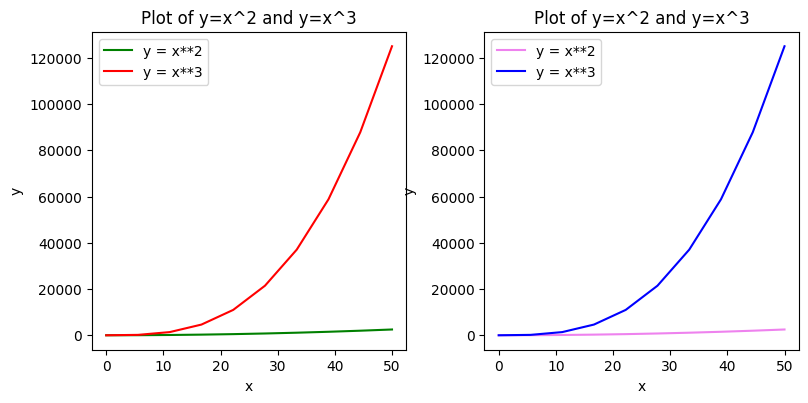

In [99]:
import numpy as np 
import matplotlib.pyplot as plt
x = np.linspace(0, 50, 10)
y = x ** 2

fig, axes = plt.subplots(1, 2, figsize=(8,4), dpi=100)

# plot subplot 1
axes[0].plot(x, x**2, color="green", label="y = x**2")
axes[0].plot(x, x**3, color="red", label="y = x**3")
axes[0].legend(loc=2); # upper left corner
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Plot of y=x^2 and y=x^3')
fig.savefig("plots.pdf")
# plot subplot 2
axes[1].plot(x, x**2, color="violet", label="y = x**2")
axes[1].plot(x, x**3, color="blue", label="y = x**3")
axes[1].legend(loc=2); # upper left corner
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Plot of y=x^2 and y=x^3')

# `fig.tight_layout()` automatically adjusts the positions of the axes on the figure canvas so that there is no overlapping content
# comment this out to see the difference
fig.tight_layout()

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe0e7a06b90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe0e77bf210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe0e77b76d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe0e77bfad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe0e77bff10>],
 'means': []}

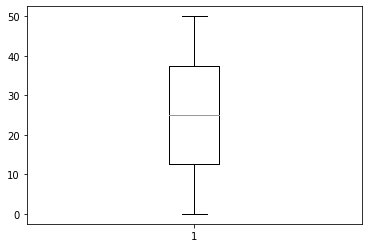

In [100]:
plt.boxplot(x)

In [101]:
for batch in range(batch_train_num):
            
            try:
                # Samples the batch
                sent1_batch, sent2_batch, sent1_lengths, sent2_lengths,targets,raw_sent1,raw_sent2= next(train_generator)

            except StopIteration:
                # restart the generator if the previous generator is exhausted.
                train_generator = iter(train_loader)
                sent1_batch, sent2_batch, sent1_lengths, sent2_lengths,targets,raw_sent1,raw_sent2= next(train_generator)
        

NameError: name 'batch_train_num' is not defined

In [102]:
load_dataset

<function datasets.load.load_dataset(path: str, name: Union[str, NoneType] = None, data_dir: Union[str, NoneType] = None, data_files: Union[Dict, List] = None, split: Union[str, datasets.splits.Split, NoneType] = None, cache_dir: Union[str, NoneType] = None, features: Union[datasets.features.Features, NoneType] = None, download_config: Union[datasets.utils.file_utils.DownloadConfig, NoneType] = None, download_mode: Union[datasets.utils.download_manager.GenerateMode, NoneType] = None, ignore_verifications: bool = False, keep_in_memory: Union[bool, NoneType] = None, save_infos: bool = False, script_version: Union[str, datasets.utils.version.Version, NoneType] = None, use_auth_token: Union[str, bool, NoneType] = None, task: Union[str, datasets.tasks.base.TaskTemplate, NoneType] = None, streaming: bool = False, **config_kwargs) -> Union[datasets.dataset_dict.DatasetDict, datasets.arrow_dataset.Dataset, datasets.dataset_dict.IterableDatasetDict, datasets.iterable_dataset.IterableDataset]>

In [103]:
from datetime import datetime

now = datetime.now().time() # time object

print("now ="+ str(now))
print("type(now) =", type(str(now)))	

now =23:52:03.358994
type(now) = <class 'str'>


In [104]:
from scipy import spatial
def cosine_score(input1, input2):
    # Get similarity predictions:
    inp1=input1.detach().numpy()
    inp2=input2.detach().numpy()
    relatedness_list=[]
    for sen in range(len(input1)):        
        relatedness = 1 - spatial.distance.cosine(inp1[sen],inp2[sen])
        relatedness_list.append(relatedness)
    return relatedness_list

a=[[29.032497240149457, 27.402251754981883, 26.907307942708332, 26.211151565330617], 
   [26.448624320652176, 25.580964461616848, 22.726847330729168, 22.599697831748188]]
   
b=[[26.448624320652176, 25.580964461616848, 22.726847330729168, 22.599697831748188],
  [29.032497240149457, 27.402251754981883, 26.907307942708332, 26.211151565330617]] 
   

In [85]:
a=torch.tensor(a)
b=torch.tensor(b)
cosine_score(a,b)

[29.032497 27.402252 26.907309 26.211151] [26.448624 25.580965 22.726847 22.599697]
[26.448624 25.580965 22.726847 22.599697] [29.032497 27.402252 26.907309 26.211151]


[0.9991987347602844, 0.9991987347602844]

In [135]:
def similarity_score(input1, input2):
    # Get similarity predictions:
    dif = input1.squeeze() - input2.squeeze()

    norm = torch.norm(dif, p=1, dim=dif.dim() - 1)
    y_hat = torch.exp(-norm)
    y_hat = torch.clamp(y_hat, min=1e-7, max=1.0 - 1e-7)
    return y_hat
#Cosine Distance
def cosine_dist(input1, input2):
    # Get similarity predictions:
    inp1=input1.detach().numpy()
    inp2=input2.detach().numpy()
    relatedness_list=[]
    for sen in range(len(input1)):        
        relatedness = 1 - spatial.distance.cosine(inp1[sen],inp2[sen])
        relatedness_list.append(relatedness)
    return relatedness_list


In [105]:
similarity_score(a,)

TypeError: similarity_score() missing 1 required positional argument: 'input2'

In [106]:
ytrue=[0.5, 0.8250000476837158, 0.8250000476837158, 0.44999998807907104, 0.9500000476837158, 0.15000000596046448, 0.7250000238418579, 0.875, 0.574999988079071, 0.8500000238418579, 0.375, 0.17500001192092896, 0.75, 0.625, 0.8999999761581421, 0.42500001192092896, 1.0, 0.9249999523162842, 0.9500000476837158, 0.675000011920929, 0.675000011920929, 0.875, 0.5537499785423279, 0.42500001192092896, 0.550000011920929, 0.574999988079071, 0.75, 0.5, 0.699999988079071, 0.550000011920929, 0.8250000476837158, 0.050000011920928955, 0.30000001192092896, 0.550000011920929, 0.9500000476837158, 0.9750000238418579, 0.550000011920929, 0.5, 0.7250000238418579, 0.550000011920929, 0.8500000238418579, 0.625, 0.8500000238418579, 0.8999999761581421, 0.8999999761581421, 0.574999988079071, 0.0, 0.699999988079071, 0.42500001192092896, 0.574999988079071, 0.6000000238418579, 0.8250000476837158, 0.8250000476837158, 0.5249999761581421, 1.0, 0.7749999761581421, 0.9249999523162842, 0.5249999761581421, 1.0, 0.7250000238418579, 0.9249999523162842, 1.0, 0.6000000238418579, 0.625, 0.0, 0.8250000476837158, 0.699999988079071, 0.3837500214576721, 0.0, 0.4750000238418579, 0.0, 0.625, 0.3999999761581421, 0.42500001192092896, 0.7712500095367432, 0.9750000238418579, 0.550000011920929, 0.19999998807907104, 0.9750000238418579, 0.8999999761581421, 0.9750000238418579, 0.5, 0.9249999523162842, 0.6000000238418579, 0.5249999761581421, 0.025000005960464478, 0.4750000238418579, 0.699999988079071, 1.0, 0.6000000238418579, 0.5, 0.875, 0.8999999761581421, 0.44999998807907104, 0.8500000238418579, 1.0, 0.7749999761581421, 0.7250000238418579, 0.875, 0.7999999523162842, 0.125, 0.699999988079071, 0.5, 0.7250000238418579, 0.699999988079071, 0.32499998807907104, 0.0, 0.4750000238418579, 0.7250000238418579, 0.6000000238418579, 0.625, 0.9249999523162842, 0.0, 0.7999999523162842, 0.42500001192092896, 0.07499998807907104, 0.6000000238418579, 0.9750000238418579, 0.625, 0.625, 0.0, 0.75, 0.32499998807907104, 0.7250000238418579, 0.4750000238418579, 0.7749999761581421, 0.6000000238418579, 0.5, 0.8500000238418579, 0.550000011920929, 0.75, 0.025000005960464478, 0.699999988079071, 0.8500000238418579, 0.675000011920929, 0.7250000238418579, 0.09999999403953552, 0.699999988079071, 0.7749999761581421, 0.15000000596046448, 0.574999988079071, 0.75, 0.8250000476837158, 0.025000005960464478, 0.8999999761581421, 0.5, 0.9500000476837158, 0.675000011920929, 0.6000000238418579, 0.42500001192092896, 0.9750000238418579, 0.07499998807907104, 0.7999999523162842, 0.7749999761581421, 0.42500001192092896, 0.550000011920929, 0.875, 0.699999988079071, 0.7999999523162842, 0.6000000238418579, 0.675000011920929, 0.9750000238418579, 0.8250000476837158, 0.8250000476837158, 0.8500000238418579, 0.7250000238418579, 0.6499999761581421, 0.44999998807907104, 0.675000011920929, 0.09999999403953552, 0.0, 0.699999988079071, 0.574999988079071, 0.875, 0.025000005960464478, 0.675000011920929, 0.699999988079071, 0.875, 0.699999988079071, 0.5, 0.6000000238418579, 0.9249999523162842, 0.550000011920929, 0.574999988079071, 0.675000011920929, 0.574999988079071, 0.7250000238418579, 0.8250000476837158, 0.6499999761581421, 0.9249999523162842, 0.550000011920929, 0.699999988079071, 0.9750000238418579, 0.22499999403953552, 0.8500000238418579, 0.875, 0.9249999523162842, 0.32499998807907104, 0.625, 1.0, 0.5, 0.025000005960464478, 0.375, 0.6000000238418579, 0.75, 0.6000000238418579, 0.550000011920929, 0.5, 0.625, 0.675000011920929, 0.0, 0.7999999523162842, 1.0, 0.875, 0.9750000238418579, 0.7999999523162842, 0.7999999523162842, 0.32499998807907104, 0.3999999761581421, 0.9249999523162842, 0.625, 0.550000011920929, 0.4750000238418579, 0.5, 0.8999999761581421, 0.5249999761581421, 0.050000011920928955, 0.699999988079071, 0.8999999761581421, 0.44999998807907104, 1.0, 0.6000000238418579, 0.5249999761581421, 0.8500000238418579, 0.75, 0.7250000238418579, 0.6000000238418579, 0.5249999761581421, 0.625, 0.050000011920928955, 0.8999999761581421, 0.5662500262260437, 0.7250000238418579, 0.0, 0.8999999761581421, 0.9500000476837158, 0.5, 0.625, 0.6499999761581421, 0.5249999761581421, 0.574999988079071, 0.9750000238418579, 0.550000011920929, 0.9750000238418579, 0.9750000238418579, 0.5, 0.9500000476837158, 1.0, 0.6499999761581421, 0.8500000238418579, 0.8250000476837158, 0.5, 0.6000000238418579, 0.699999988079071, 0.9500000476837158, 0.9500000476837158, 0.875, 0.7250000238418579, 0.44999998807907104, 0.5, 0.7749999761581421, 0.574999988079071, 0.5249999761581421, 0.19999998807907104, 0.675000011920929, 0.3999999761581421, 0.375, 0.8500000238418579, 0.8250000476837158, 0.8250000476837158, 0.25, 0.375, 0.75, 0.8500000238418579, 0.8250000476837158, 0.6000000238418579, 0.9500000476837158, 1.0, 0.9750000238418579, 0.6000000238418579, 0.6499999761581421, 0.8250000476837158, 0.44999998807907104, 0.09999999403953552, 0.8250000476837158, 0.0, 0.44999998807907104, 0.7250000238418579, 0.2787500023841858, 0.7749999761581421, 0.625, 0.574999988079071, 0.7999999523162842, 0.3500000238418579, 0.875, 0.6000000238418579, 0.75, 0.550000011920929, 0.637499988079071, 0.07499998807907104, 0.9750000238418579, 1.0, 0.574999988079071, 0.675000011920929, 0.875, 0.75, 0.9750000238418579, 0.875, 0.75, 0.6499999761581421, 0.6499999761581421, 0.6000000238418579, 0.699999988079071, 0.3500000238418579, 0.15000000596046448, 0.8500000238418579, 0.550000011920929, 0.7250000238418579, 0.8500000238418579, 0.625, 0.574999988079071, 0.6499999761581421, 0.675000011920929, 0.0, 0.6499999761581421, 0.574999988079071, 0.9750000238418579, 0.3999999761581421, 0.7999999523162842, 1.0, 0.875, 0.550000011920929, 0.9249999523162842, 0.8500000238418579, 0.699999988079071, 0.9249999523162842, 0.9500000476837158, 0.3999999761581421, 0.675000011920929, 0.625, 0.9750000238418579, 0.7250000238418579, 0.8999999761581421, 0.699999988079071, 0.5, 1.0, 0.2749999761581421, 0.8250000476837158, 0.6000000238418579, 0.699999988079071, 0.7712500095367432, 0.550000011920929, 0.6499999761581421, 0.4750000238418579, 0.8250000476837158, 0.675000011920929, 0.7999999523162842, 0.699999988079071, 0.5249999761581421, 0.625, 0.7749999761581421, 0.699999988079071, 0.25, 0.7999999523162842, 0.2749999761581421, 0.15000000596046448, 0.42500001192092896, 0.025000005960464478, 0.550000011920929, 0.3500000238418579, 0.3999999761581421, 0.4750000238418579, 0.6000000238418579, 0.2749999761581421, 0.8500000238418579, 0.8250000476837158, 0.75, 0.7749999761581421, 0.0, 0.75, 0.25, 0.625, 0.7037500143051147, 0.0, 0.4750000238418579, 0.0, 0.75, 0.44999998807907104, 0.8250000476837158, 0.8250000476837158, 0.7999999523162842, 0.75, 0.574999988079071, 0.75, 0.625, 0.09999999403953552, 0.7250000238418579, 0.3500000238418579, 0.675000011920929, 0.75, 0.699999988079071, 0.17500001192092896, 0.25, 0.0, 0.675000011920929, 0.675000011920929, 0.3500000238418579, 0.6499999761581421, 0.8999999761581421, 0.9500000476837158, 0.9500000476837158, 0.17500001192092896, 0.675000011920929, 0.9750000238418579, 0.699999988079071, 0.7250000238418579, 0.7749999761581421, 0.574999988079071, 0.125, 0.9249999523162842, 0.6499999761581421, 0.050000011920928955, 0.625, 0.8250000476837158, 0.32499998807907104, 0.09999999403953552, 0.7749999761581421, 0.9750000238418579, 0.9750000238418579, 0.574999988079071, 1.0, 0.4750000238418579, 0.625, 0.574999988079071, 0.574999988079071, 0.9249999523162842, 0.6499999761581421, 0.574999988079071, 0.025000005960464478, 0.9500000476837158, 0.7999999523162842, 0.7250000238418579, 0.19999998807907104, 0.625, 0.8250000476837158, 0.875, 1.0, 0.9750000238418579, 0.9750000238418579, 0.699999988079071, 0.8250000476837158, 0.550000011920929, 0.699999988079071, 0.7999999523162842, 0.7999999523162842, 0.675000011920929, 0.5, 0.675000011920929, 0.9750000238418579, 0.5249999761581421, 0.625, 0.7749999761581421, 0.9500000476837158, 0.5, 0.5249999761581421, 0.675000011920929, 0.7999999523162842, 0.6499999761581421, 0.574999988079071, 0.8999999761581421, 0.6000000238418579, 0.32499998807907104, 0.625, 0.75, 0.45875000953674316, 0.699999988079071, 0.846250057220459, 0.625, 0.9249999523162842, 0.75, 0.550000011920929, 0.7749999761581421, 0.8250000476837158, 0.8250000476837158, 0.625, 0.125, 0.75, 0.875, 0.050000011920928955, 0.6000000238418579, 0.44999998807907104, 0.75, 0.07499998807907104, 0.6499999761581421, 0.4750000238418579, 0.9750000238418579, 0.6000000238418579, 0.5, 0.3500000238418579, 0.025000005960464478, 0.22499999403953552, 0.625, 0.875, 0.4750000238418579, 0.6000000238418579, 1.0, 0.7999999523162842, 0.6000000238418579, 0.699999988079071, 0.3500000238418579, 0.550000011920929, 0.8999999761581421, 0.5912500023841858, 0.8999999761581421, 0.574999988079071, 0.625, 0.5, 0.15000000596046448, 0.574999988079071, 0.675000011920929, 0.6000000238418579, 1.0, 0.3087499737739563, 0.7999999523162842, 0.42500001192092896, 0.375, 1.0, 0.6037499904632568, 0.5249999761581421, 0.125, 0.9750000238418579, 0.574999988079071, 0.17500001192092896, 0.7999999523162842, 0.8999999761581421, 0.9500000476837158, 0.5249999761581421, 0.6499999761581421, 0.6000000238418579, 0.6000000238418579, 0.625, 0.8999999761581421, 0.9750000238418579, 0.7999999523162842, 0.7999999523162842, 0.25, 0.8999999761581421, 0.550000011920929, 0.7999999523162842, 0.09999999403953552, 0.625, 0.9750000238418579, 0.9750000238418579, 0.9537500143051147, 0.9249999523162842, 0.8500000238418579, 0.7250000238418579, 0.32499998807907104, 0.574999988079071, 0.7250000238418579, 0.8250000476837158, 0.75, 0.699999988079071, 0.7250000238418579, 0.675000011920929, 1.0, 0.6000000238418579, 1.0, 0.9750000238418579, 0.125, 0.675000011920929, 0.574999988079071, 0.574999988079071, 0.574999988079071, 0.625, 0.4750000238418579, 0.699999988079071, 0.550000011920929, 0.675000011920929, 0.9500000476837158, 0.699999988079071, 0.9500000476837158, 0.125, 0.0, 0.375, 0.7250000238418579, 0.9500000476837158, 0.699999988079071, 0.07499998807907104, 0.5249999761581421, 0.675000011920929, 0.0, 0.3999999761581421, 0.3999999761581421, 0.44999998807907104, 1.0, 0.6499999761581421, 0.5, 0.675000011920929, 0.4750000238418579, 0.5, 0.574999988079071, 0.875, 0.550000011920929, 0.7250000238418579, 0.375, 0.8500000238418579, 0.9500000476837158, 0.0, 0.699999988079071, 0.4750000238418579, 0.375, 0.3999999761581421, 0.7250000238418579, 0.5249999761581421, 0.675000011920929, 0.0, 0.8500000238418579, 0.6000000238418579, 0.550000011920929, 0.5, 0.3500000238418579, 0.6499999761581421, 0.550000011920929, 0.4750000238418579, 0.6000000238418579, 0.75, 0.44999998807907104, 0.574999988079071, 0.9750000238418579, 0.6499999761581421, 0.7999999523162842, 0.3500000238418579, 0.0, 0.7999999523162842, 0.75, 0.8500000238418579, 0.9750000238418579, 0.3500000238418579, 0.9750000238418579, 0.125, 0.875, 0.675000011920929, 0.050000011920928955, 0.7749999761581421, 0.5, 0.875, 0.875, 0.5, 0.25, 0.4750000238418579, 0.5249999761581421, 0.550000011920929, 0.6000000238418579, 0.699999988079071, 0.9750000238418579, 0.625, 0.8250000476837158, 0.675000011920929, 0.025000005960464478, 0.6499999761581421, 0.675000011920929, 0.7999999523162842, 0.5, 0.9750000238418579, 1.0, 0.6499999761581421, 0.574999988079071, 0.5, 0.125, 0.8250000476837158, 0.9750000238418579, 0.625, 0.574999988079071, 0.6412500143051147, 0.875, 0.699999988079071, 0.7250000238418579, 0.574999988079071, 0.625, 0.7999999523162842, 0.9750000238418579, 0.875, 1.0, 0.699999988079071, 1.0, 0.30000001192092896, 0.574999988079071, 0.9537500143051147, 0.9750000238418579, 0.8999999761581421, 0.4750000238418579, 0.8999999761581421, 0.7250000238418579, 1.0, 0.8999999761581421, 0.875, 0.625, 0.375, 0.75, 0.7250000238418579, 0.8500000238418579, 0.025000005960464478, 0.7250000238418579, 0.7999999523162842, 0.25, 0.7749999761581421, 0.6499999761581421, 0.7749999761581421, 0.675000011920929, 0.8250000476837158, 0.9750000238418579, 0.7250000238418579, 0.550000011920929, 0.9750000238418579, 0.574999988079071, 0.75, 0.025000005960464478, 0.6000000238418579, 0.5249999761581421, 0.7749999761581421, 0.0, 0.2749999761581421, 0.75, 0.9500000476837158, 0.574999988079071, 0.550000011920929, 0.8999999761581421, 0.6837499737739563, 0.7999999523162842, 0.5, 0.75, 0.7749999761581421, 0.8250000476837158, 0.125, 0.9750000238418579, 0.25, 0.07499998807907104, 0.7250000238418579, 0.22499999403953552, 0.6499999761581421, 0.6499999761581421, 0.8999999761581421, 0.5, 0.7749999761581421, 0.6499999761581421, 0.44999998807907104, 0.4750000238418579, 0.5, 1.0, 0.5249999761581421, 0.75, 0.0, 1.0, 0.675000011920929, 0.30000001192092896, 0.5, 0.0, 0.6499999761581421, 0.8500000238418579, 0.9750000238418579, 0.5249999761581421, 0.6000000238418579, 0.8999999761581421, 0.9500000476837158, 0.574999988079071, 0.9750000238418579, 0.3999999761581421, 0.4750000238418579, 0.75, 0.7250000238418579, 0.5249999761581421, 0.625, 0.7999999523162842, 1.0, 0.9500000476837158, 0.675000011920929, 0.7250000238418579, 0.44999998807907104, 0.0, 0.574999988079071, 0.2749999761581421, 0.125, 0.699999988079071, 1.0, 0.32499998807907104, 0.9750000238418579, 0.8500000238418579, 0.7999999523162842, 0.699999988079071, 0.875, 0.574999988079071, 0.625, 0.375, 0.699999988079071, 0.44999998807907104, 0.574999988079071, 0.550000011920929, 0.9750000238418579, 0.9750000238418579, 0.15000000596046448, 0.7250000238418579, 0.7749999761581421, 0.550000011920929, 0.7250000238418579, 0.625, 0.875, 0.7749999761581421, 0.875, 0.625, 0.675000011920929, 0.875, 0.875, 0.75, 0.8250000476837158, 0.44999998807907104, 0.9249999523162842, 0.574999988079071, 0.778749942779541, 0.7749999761581421, 0.7749999761581421, 0.7749999761581421, 0.8500000238418579, 0.5249999761581421, 0.8250000476837158, 0.6499999761581421, 0.675000011920929, 0.9249999523162842, 0.875, 0.574999988079071, 0.9500000476837158, 0.9500000476837158, 0.8374999761581421, 0.675000011920929, 0.050000011920928955, 0.046249985694885254, 0.7749999761581421, 0.699999988079071, 0.8999999761581421, 0.30000001192092896, 0.375, 0.675000011920929, 0.875, 0.875, 0.8250000476837158, 0.4750000238418579, 0.0, 0.8500000238418579, 0.375, 0.699999988079071, 0.5, 0.9750000238418579, 0.8500000238418579, 0.75, 0.9750000238418579, 0.5, 0.9750000238418579, 0.44999998807907104, 0.7999999523162842, 1.0, 0.574999988079071, 0.7250000238418579, 0.550000011920929, 0.75, 1.0, 0.550000011920929, 0.3500000238418579, 0.7999999523162842, 0.8500000238418579, 0.6499999761581421, 0.550000011920929, 0.550000011920929, 0.8500000238418579, 0.8999999761581421, 0.4750000238418579, 0.025000005960464478, 0.7999999523162842, 0.6499999761581421, 0.0, 0.7999999523162842, 0.9500000476837158, 0.9249999523162842, 0.875, 0.9249999523162842, 0.7749999761581421, 0.7250000238418579, 0.42500001192092896, 0.8500000238418579, 0.6587499976158142, 0.7999999523162842, 0.9500000476837158, 0.875, 0.9750000238418579, 0.44999998807907104, 0.625, 0.3500000238418579, 0.9750000238418579, 1.0, 0.6499999761581421, 0.5, 0.9750000238418579, 0.8500000238418579, 0.675000011920929, 0.875, 0.9500000476837158, 0.6499999761581421, 0.8250000476837158, 0.3999999761581421, 0.4750000238418579, 0.875, 0.9125000238418579, 0.44999998807907104, 0.6499999761581421, 0.6000000238418579, 0.9500000476837158, 0.625, 0.550000011920929, 0.8500000238418579, 0.625, 0.7250000238418579, 0.8250000476837158, 0.0, 0.625, 0.75, 0.6499999761581421, 0.7749999761581421, 0.4750000238418579, 0.6000000238418579, 0.6499999761581421, 0.574999988079071, 0.625, 0.550000011920929, 0.550000011920929, 0.3500000238418579, 0.6499999761581421, 0.9500000476837158, 0.9750000238418579, 0.625, 0.8250000476837158, 0.7999999523162842, 0.625, 0.7999999523162842, 0.4750000238418579, 0.0, 0.8250000476837158, 0.8250000476837158, 1.0, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.699999988079071, 0.6499999761581421, 0.574999988079071, 0.8250000476837158, 0.574999988079071, 0.9750000238418579, 0.42500001192092896, 0.3500000238418579, 0.875, 0.9750000238418579, 0.699999988079071, 0.9750000238418579, 0.44999998807907104, 0.3999999761581421, 0.7250000238418579, 0.675000011920929, 0.9249999523162842, 0.550000011920929, 0.8500000238418579, 0.4750000238418579, 0.8500000238418579, 0.7749999761581421, 0.625, 0.8250000476837158, 0.625, 0.8500000238418579, 0.30000001192092896, 0.0, 0.875, 0.6499999761581421, 0.6000000238418579, 0.6499999761581421, 0.3999999761581421, 0.550000011920929, 0.75, 0.375, 0.9750000238418579, 0.550000011920929, 0.4750000238418579, 0.3500000238418579, 0.9500000476837158, 0.9249999523162842, 0.025000005960464478, 1.0, 1.0, 0.675000011920929, 0.875, 0.9750000238418579, 0.6000000238418579, 0.6000000238418579, 0.09999999403953552, 0.6000000238418579, 0.574999988079071, 0.5249999761581421, 0.550000011920929, 0.3500000238418579, 0.875, 0.550000011920929, 0.19999998807907104, 0.025000005960464478, 0.30000001192092896, 0.8250000476837158, 0.550000011920929, 0.6499999761581421, 0.699999988079071, 0.42500001192092896, 0.625, 0.8999999761581421, 0.699999988079071, 0.75, 0.625, 0.9500000476837158, 0.4125000238418579, 0.30000001192092896, 0.09999999403953552, 0.75, 0.22499999403953552, 0.9249999523162842, 0.6000000238418579, 0.675000011920929, 0.75, 0.7250000238418579, 0.9750000238418579, 0.5249999761581421, 0.6000000238418579, 0.7412499785423279, 0.32499998807907104, 0.7999999523162842, 0.3999999761581421, 0.2749999761581421, 0.7749999761581421, 0.9750000238418579, 1.0, 0.574999988079071, 0.9500000476837158, 0.6499999761581421, 0.550000011920929, 1.0, 0.6000000238418579, 0.22499999403953552, 0.7749999761581421, 0.7999999523162842, 0.0, 0.6499999761581421, 0.8500000238418579, 0.7749999761581421, 0.4750000238418579, 0.42500001192092896, 0.7999999523162842, 0.550000011920929, 0.875, 0.7250000238418579, 0.4624999761581421, 0.7749999761581421, 0.8500000238418579, 0.4750000238418579, 0.8250000476837158, 0.8999999761581421, 0.6499999761581421, 0.625, 0.5, 0.2749999761581421, 0.75, 0.6000000238418579, 0.550000011920929, 1.0, 0.7250000238418579, 0.6000000238418579, 0.39125001430511475, 0.675000011920929, 0.75, 0.9287500381469727, 0.6000000238418579, 0.44999998807907104, 1.0, 0.0, 0.4750000238418579, 0.675000011920929, 0.8500000238418579, 0.7250000238418579, 0.699999988079071, 0.699999988079071, 0.44999998807907104, 0.9750000238418579, 0.7875000238418579, 0.8999999761581421, 0.8250000476837158, 0.5, 0.699999988079071, 0.3500000238418579, 0.625, 0.9249999523162842, 0.6499999761581421, 0.8500000238418579, 0.7749999761581421, 0.75, 0.8250000476837158, 1.0, 0.9249999523162842, 0.15000000596046448, 0.699999988079071, 0.9249999523162842, 0.875, 0.5874999761581421, 0.6499999761581421, 0.5249999761581421, 0.7250000238418579, 0.574999988079071, 0.9249999523162842, 0.699999988079071, 0.7250000238418579, 0.6000000238418579, 0.8500000238418579, 0.6499999761581421, 0.050000011920928955, 0.5712500214576721, 0.050000011920928955, 0.5, 0.675000011920929, 0.875, 0.375, 0.699999988079071, 0.75, 0.6499999761581421, 0.75, 0.6000000238418579, 0.3500000238418579, 0.32499998807907104, 0.9750000238418579, 0.5249999761581421, 0.675000011920929, 0.8500000238418579, 0.0, 0.625, 0.625, 0.6499999761581421, 0.625, 0.7999999523162842, 0.6499999761581421, 0.6000000238418579, 0.675000011920929, 0.3999999761581421, 0.9249999523162842, 0.44999998807907104, 0.550000011920929, 0.9500000476837158, 0.550000011920929, 0.7250000238418579, 0.4750000238418579, 0.3500000238418579, 0.7250000238418579, 0.6000000238418579, 0.9750000238418579, 0.7250000238418579, 0.3999999761581421, 0.19999998807907104, 0.375, 0.550000011920929, 0.4125000238418579, 0.6499999761581421, 0.6499999761581421, 0.9750000238418579, 0.9500000476837158, 0.875, 0.6499999761581421, 0.625, 0.0, 0.550000011920929, 0.699999988079071, 0.5249999761581421, 0.7749999761581421, 0.9249999523162842, 0.7250000238418579, 0.42500001192092896, 0.22499999403953552, 0.574999988079071, 0.75, 0.0, 0.625, 0.5249999761581421, 0.699999988079071, 0.550000011920929, 0.22499999403953552, 0.44999998807907104, 0.5249999761581421, 0.7999999523162842, 0.8500000238418579, 0.7250000238418579, 0.4750000238418579, 0.3999999761581421, 0.75, 0.675000011920929, 0.9249999523162842, 0.6499999761581421, 0.675000011920929, 0.7999999523162842, 0.8999999761581421, 0.9500000476837158, 0.699999988079071, 0.42500001192092896, 0.7999999523162842, 0.625, 0.6000000238418579, 1.0, 0.5, 0.9500000476837158, 0.3999999761581421, 0.7250000238418579, 0.44999998807907104, 0.9500000476837158, 0.625, 0.7999999523162842, 1.0, 0.574999988079071, 0.30000001192092896, 0.675000011920929, 0.6499999761581421, 0.574999988079071, 0.550000011920929, 1.0, 0.574999988079071, 0.17500001192092896, 0.07499998807907104, 0.6499999761581421, 0.675000011920929, 0.8500000238418579, 0.5, 0.675000011920929, 0.5249999761581421, 0.42500001192092896, 0.6000000238418579, 0.0, 0.8875000476837158, 0.8250000476837158, 1.0, 0.9750000238418579, 0.7749999761581421, 0.625, 0.550000011920929, 0.9750000238418579, 0.625, 0.8999999761581421, 0.550000011920929, 0.675000011920929, 0.8250000476837158, 0.7250000238418579, 0.3500000238418579, 0.7749999761581421, 0.375, 0.5, 0.75, 0.5, 0.5249999761581421, 0.0, 0.44999998807907104, 0.7999999523162842, 0.30000001192092896, 0.6499999761581421, 0.8999999761581421, 0.75, 0.550000011920929, 1.0, 0.5249999761581421, 0.9249999523162842, 0.550000011920929, 0.025000005960464478, 0.875, 0.32499998807907104, 0.75, 0.7999999523162842, 0.7250000238418579, 0.22499999403953552, 0.0, 0.8250000476837158, 0.2749999761581421, 0.550000011920929, 0.699999988079071, 0.25, 0.42500001192092896, 0.6499999761581421, 0.75, 0.0, 0.5, 0.025000005960464478, 0.5249999761581421, 0.5, 0.875, 0.6499999761581421, 0.9249999523162842, 0.6499999761581421, 0.9500000476837158, 0.9500000476837158, 0.875, 0.9249999523162842, 0.7250000238418579, 0.75, 1.0, 0.6499999761581421, 0.4750000238418579, 0.3999999761581421, 0.0, 0.0, 0.3999999761581421, 0.550000011920929, 0.75, 0.675000011920929, 0.8500000238418579, 0.875, 0.7250000238418579, 0.125, 0.8250000476837158, 0.6000000238418579, 0.8250000476837158, 0.625, 0.699999988079071, 0.9750000238418579, 0.046249985694885254, 0.9750000238418579, 0.9750000238418579, 0.8999999761581421, 0.75, 0.0, 0.8250000476837158, 0.699999988079071, 1.0, 0.699999988079071, 0.48000001907348633, 0.625, 0.8250000476837158, 0.8999999761581421, 0.0, 0.625, 0.8250000476837158, 0.875, 0.675000011920929, 0.8500000238418579, 0.8250000476837158, 0.9750000238418579, 0.0, 0.44999998807907104, 0.699999988079071, 0.675000011920929, 0.8500000238418579, 0.050000011920928955, 0.8500000238418579, 0.6499999761581421, 0.550000011920929, 0.875, 0.7250000238418579, 0.0, 0.7999999523162842, 0.9249999523162842, 0.7250000238418579, 0.6000000238418579, 0.699999988079071, 0.6499999761581421, 0.875, 0.025000005960464478, 0.6000000238418579, 0.22499999403953552, 0.7999999523162842, 0.8250000476837158, 0.4750000238418579, 0.125, 0.3500000238418579, 0.3999999761581421, 0.7749999761581421, 0.3999999761581421, 0.699999988079071, 1.0, 0.574999988079071, 0.75, 1.0, 0.0, 0.9500000476837158, 0.9500000476837158, 1.0, 0.75, 0.3999999761581421, 0.625, 0.42500001192092896, 0.9750000238418579, 0.875, 0.7250000238418579, 0.5249999761581421, 0.574999988079071, 0.6000000238418579, 0.7999999523162842, 0.8500000238418579, 0.0, 0.8624999523162842, 0.675000011920929, 0.30000001192092896, 0.75, 0.6000000238418579, 0.9750000238418579, 0.574999988079071, 0.625, 0.699999988079071, 0.7250000238418579, 0.8250000476837158, 0.8500000238418579, 0.4750000238418579, 0.375, 0.5249999761581421, 0.9249999523162842, 0.32499998807907104, 0.699999988079071, 0.47874999046325684, 1.0, 0.5, 0.75, 0.32499998807907104, 0.0, 0.7999999523162842, 0.3999999761581421, 0.42500001192092896, 0.9249999523162842, 0.625, 0.44999998807907104, 0.625, 0.699999988079071, 0.9750000238418579, 0.4750000238418579, 0.375, 0.6000000238418579, 0.9500000476837158, 0.574999988079071, 0.3412500023841858, 0.7250000238418579, 0.5249999761581421, 0.8250000476837158, 0.625, 0.7999999523162842, 0.75, 0.3500000238418579, 0.8500000238418579, 0.9750000238418579, 0.5375000238418579, 0.5249999761581421, 0.6000000238418579, 0.6000000238418579, 0.8250000476837158, 0.699999988079071, 0.5249999761581421, 0.0, 0.9750000238418579, 0.9500000476837158, 0.025000005960464478, 0.574999988079071, 0.3999999761581421, 0.22499999403953552, 0.875, 1.0, 0.0, 0.574999988079071, 0.7749999761581421, 0.4662500023841858, 0.699999988079071, 0.32499998807907104, 0.375, 0.908750057220459, 0.675000011920929, 0.4750000238418579, 0.75, 0.7999999523162842, 0.675000011920929, 0.5249999761581421, 0.625, 0.7999999523162842, 0.6000000238418579, 0.7749999761581421, 0.7250000238418579, 0.32499998807907104, 0.75, 0.125, 0.625, 0.9750000238418579, 0.8500000238418579, 0.4750000238418579, 0.675000011920929, 0.574999988079071, 0.75, 0.09999999403953552, 0.9500000476837158, 0.6499999761581421, 0.9500000476837158, 0.42500001192092896, 0.625, 0.8500000238418579, 0.875, 0.675000011920929, 0.699999988079071, 0.42500001192092896, 0.7999999523162842, 0.8500000238418579, 0.9249999523162842, 0.4750000238418579, 0.9249999523162842, 0.6000000238418579, 0.875, 0.75, 0.7749999761581421, 0.699999988079071, 0.675000011920929, 0.9750000238418579, 0.09999999403953552, 0.5, 0.7250000238418579, 0.0, 0.75, 0.42500001192092896, 0.5249999761581421, 0.32499998807907104, 0.42500001192092896, 0.4750000238418579, 0.4750000238418579, 0.7749999761581421, 0.5, 0.625, 0.75, 0.6499999761581421, 0.9500000476837158, 0.6499999761581421, 0.6499999761581421, 0.9249999523162842, 0.2749999761581421, 0.550000011920929, 0.7250000238418579, 0.550000011920929, 0.25, 0.75, 0.7999999523162842, 0.75, 0.675000011920929, 0.4750000238418579, 0.75, 0.875, 0.9249999523162842, 0.625, 0.32499998807907104, 0.6000000238418579, 0.675000011920929, 0.9750000238418579, 0.6000000238418579, 0.0, 0.625, 0.699999988079071, 0.7749999761581421, 0.625, 0.75, 0.6000000238418579, 0.9750000238418579, 0.75, 0.42500001192092896, 0.5249999761581421, 0.5874999761581421, 0.8250000476837158, 0.6499999761581421, 0.4750000238418579, 0.6000000238418579, 0.025000005960464478, 0.550000011920929, 0.574999988079071, 0.8999999761581421, 0.15000000596046448, 0.675000011920929, 0.0, 0.8250000476837158, 0.7749999761581421, 0.699999988079071, 0.9750000238418579, 0.6000000238418579, 0.5249999761581421, 0.7749999761581421, 0.7250000238418579, 0.550000011920929, 0.9500000476837158, 0.07499998807907104, 0.875, 0.9750000238418579, 0.0, 0.9750000238418579, 0.75, 0.7749999761581421, 0.8250000476837158, 0.6000000238418579, 0.675000011920929, 0.6000000238418579, 0.44999998807907104, 0.2749999761581421, 0.8999999761581421, 0.75, 0.5, 0.6499999761581421, 0.75, 0.550000011920929, 0.8500000238418579, 0.8250000476837158, 0.7749999761581421, 0.42500001192092896, 0.3999999761581421, 0.8250000476837158, 0.7749999761581421, 0.675000011920929, 0.8250000476837158, 0.875, 0.9750000238418579, 0.699999988079071, 0.375, 0.574999988079071, 0.7999999523162842, 0.17500001192092896, 0.675000011920929, 0.574999988079071, 0.7999999523162842, 0.75, 0.8250000476837158, 0.3999999761581421, 0.6499999761581421, 0.9750000238418579, 0.0, 0.5249999761581421, 0.42500001192092896, 0.0, 0.574999988079071, 0.6499999761581421, 0.625, 0.5, 0.8999999761581421, 0.675000011920929, 0.4750000238418579, 0.9750000238418579, 0.8999999761581421, 0.8250000476837158, 0.44999998807907104, 0.42500001192092896, 0.8250000476837158, 0.675000011920929, 0.7749999761581421, 0.8250000476837158, 0.6000000238418579, 0.8999999761581421, 0.0, 0.6499999761581421, 0.875, 0.9500000476837158, 0.6000000238418579, 0.5, 0.7749999761581421, 0.9500000476837158, 0.025000005960464478, 0.8999999761581421, 0.5249999761581421, 0.699999988079071, 0.0, 0.42500001192092896, 0.17500001192092896, 0.3999999761581421, 0.32499998807907104, 0.625, 0.6499999761581421, 0.699999988079071, 0.550000011920929, 0.9750000238418579, 0.8999999761581421, 0.9750000238418579, 0.550000011920929, 0.625, 0.8250000476837158, 0.9500000476837158, 0.75, 0.5, 0.8500000238418579, 0.625, 0.7749999761581421, 0.675000011920929, 0.574999988079071, 0.9750000238418579, 0.550000011920929, 0.4750000238418579, 0.8500000238418579, 0.0, 0.42500001192092896, 0.7749999761581421, 0.9249999523162842, 0.375, 0.699999988079071, 0.875, 0.375, 0.0, 0.9249999523162842, 0.0, 0.8999999761581421, 0.6499999761581421, 0.7999999523162842, 0.625, 0.7749999761581421, 0.0, 0.9249999523162842, 0.675000011920929, 0.699999988079071, 0.9500000476837158, 0.3500000238418579, 0.0, 0.7250000238418579, 0.6499999761581421, 0.6000000238418579, 0.09999999403953552, 0.5249999761581421, 0.7250000238418579, 0.4750000238418579, 0.0, 0.3500000238418579, 0.875, 0.699999988079071, 0.5249999761581421, 0.75, 0.8250000476837158, 0.6499999761581421, 0.9500000476837158, 0.625, 0.699999988079071, 0.3999999761581421, 0.6000000238418579, 0.2749999761581421, 0.9500000476837158, 0.0, 0.7250000238418579, 0.9249999523162842, 0.625, 0.675000011920929, 0.75, 0.8500000238418579, 0.574999988079071, 0.75, 0.574999988079071, 0.17500001192092896, 0.375, 0.699999988079071, 0.675000011920929, 0.8250000476837158, 0.875, 0.42500001192092896, 0.625, 0.8250000476837158, 0.7749999761581421, 0.625, 0.574999988079071, 0.675000011920929, 0.9500000476837158, 0.75, 0.9500000476837158, 0.625, 0.44999998807907104, 0.0, 0.3999999761581421, 0.8500000238418579, 0.7250000238418579, 0.675000011920929, 0.19999998807907104, 0.7749999761581421, 0.0, 0.875, 0.9500000476837158, 0.675000011920929, 0.7999999523162842, 0.5, 0.7250000238418579, 0.7250000238418579, 0.574999988079071, 0.675000011920929, 0.4750000238418579, 0.09999999403953552, 0.6499999761581421, 0.0, 0.875, 0.42500001192092896, 0.875, 0.8999999761581421, 1.0, 0.9500000476837158, 0.5249999761581421, 0.6499999761581421, 0.9500000476837158, 0.4662500023841858, 0.6000000238418579, 0.699999988079071, 0.9750000238418579, 0.574999988079071, 0.30000001192092896, 0.574999988079071, 0.675000011920929, 0.9249999523162842, 0.9537500143051147, 0.7250000238418579, 1.0, 0.5, 0.75, 0.07499998807907104, 0.9750000238418579, 0.9750000238418579, 0.25, 0.574999988079071, 0.5249999761581421, 0.025000005960464478, 0.675000011920929, 0.375, 0.42500001192092896, 0.550000011920929, 0.9500000476837158, 0.8250000476837158, 0.75, 0.8250000476837158, 0.050000011920928955, 0.625, 0.5249999761581421, 0.4750000238418579, 0.0, 0.8500000238418579, 0.7749999761581421, 0.6000000238418579, 0.574999988079071, 0.9750000238418579, 0.8250000476837158, 0.675000011920929, 0.5249999761581421, 0.9750000238418579, 0.875, 0.875, 0.0, 0.6000000238418579, 0.32499998807907104, 0.375, 0.9750000238418579, 0.5, 0.6499999761581421, 1.0, 0.675000011920929, 0.4750000238418579, 0.025000005960464478, 0.7749999761581421, 0.32499998807907104, 0.9500000476837158, 0.75, 0.4750000238418579, 0.7749999761581421, 0.875, 0.7124999761581421, 0.75, 0.8999999761581421, 0.9750000238418579, 0.7749999761581421, 0.375, 0.8500000238418579, 0.6000000238418579, 0.8250000476837158, 0.625, 0.7749999761581421, 1.0, 0.6000000238418579, 0.42500001192092896, 0.42500001192092896, 0.42500001192092896, 0.9500000476837158, 0.025000005960464478, 0.7749999761581421, 0.375, 0.25, 0.9500000476837158, 0.4750000238418579, 0.699999988079071, 0.3999999761581421, 0.8999999761581421, 0.025000005960464478, 0.4750000238418579, 0.375, 0.4750000238418579, 0.875, 0.7749999761581421, 0.6000000238418579, 0.8250000476837158, 0.9249999523162842, 0.5, 0.6499999761581421, 0.19999998807907104, 0.675000011920929, 0.7999999523162842, 0.42500001192092896, 0.9750000238418579, 0.7250000238418579, 0.7749999761581421, 1.0, 0.7749999761581421, 0.3999999761581421, 0.9500000476837158, 0.699999988079071, 0.625, 0.574999988079071, 0.2749999761581421, 0.8999999761581421, 0.7250000238418579, 0.5249999761581421, 0.8500000238418579, 0.75, 0.5249999761581421, 0.4750000238418579, 0.7250000238418579, 0.44999998807907104, 0.625, 0.6499999761581421, 0.3999999761581421, 0.19999998807907104, 0.9249999523162842, 0.625, 0.6499999761581421, 0.6000000238418579, 0.9750000238418579, 0.8500000238418579, 0.025000005960464478, 0.5, 0.574999988079071, 0.625, 0.9500000476837158, 0.550000011920929, 0.8999999761581421, 0.574999988079071, 0.574999988079071, 0.75, 0.6499999761581421, 0.7749999761581421, 0.5, 0.6499999761581421, 0.15000000596046448, 0.9750000238418579, 0.22499999403953552, 0.5249999761581421, 0.8999999761581421, 1.0, 0.9750000238418579, 0.7749999761581421, 0.9249999523162842, 0.75, 0.8250000476837158, 0.13374999165534973, 0.0, 0.32499998807907104, 0.9500000476837158, 0.2749999761581421, 0.9500000476837158, 0.7749999761581421, 0.5, 0.550000011920929, 0.8500000238418579, 0.8250000476837158, 0.6000000238418579, 0.32499998807907104, 0.9500000476837158, 0.3500000238418579, 0.6499999761581421, 0.8250000476837158, 0.6499999761581421, 0.6499999761581421, 0.4750000238418579, 0.9249999523162842, 0.625, 0.75, 0.9500000476837158, 0.875, 0.550000011920929, 0.8999999761581421, 0.5249999761581421, 0.9750000238418579, 0.75, 0.550000011920929, 0.09999999403953552, 0.8500000238418579, 0.75, 0.6499999761581421, 0.050000011920928955, 0.44999998807907104, 0.5, 0.5249999761581421, 0.5, 0.3500000238418579, 0.5, 0.3999999761581421, 0.574999988079071, 0.8250000476837158, 0.025000005960464478, 0.8500000238418579, 0.0, 1.0, 0.7999999523162842, 0.6000000238418579, 0.22499999403953552, 0.550000011920929, 0.9500000476837158, 0.8999999761581421, 0.75, 0.07499998807907104, 0.75, 0.9750000238418579, 0.375, 0.875, 0.699999988079071, 0.3500000238418579, 0.4750000238418579, 0.3500000238418579, 0.9750000238418579, 0.6499999761581421, 0.4750000238418579, 0.625, 0.5249999761581421, 0.5037500262260437, 0.5249999761581421, 0.9249999523162842, 0.09999999403953552, 0.9500000476837158, 0.5912500023841858, 0.574999988079071, 0.699999988079071, 0.6499999761581421, 0.6287500262260437, 0.550000011920929, 0.7749999761581421, 0.25, 0.8999999761581421, 0.7999999523162842, 0.9500000476837158, 0.9750000238418579, 0.6499999761581421, 0.8999999761581421, 0.550000011920929, 0.07499998807907104, 0.0, 0.44999998807907104, 0.8500000238418579, 0.6000000238418579, 0.6499999761581421, 0.625, 0.7749999761581421, 0.15000000596046448, 0.44999998807907104, 0.9750000238418579, 0.7250000238418579, 0.8500000238418579, 0.675000011920929, 0.675000011920929, 0.7749999761581421, 1.0, 0.8500000238418579, 0.875, 0.7999999523162842, 0.17500001192092896, 0.75, 0.125, 0.625, 0.32499998807907104, 0.2749999761581421, 0.375, 0.9750000238418579, 0.025000005960464478, 0.699999988079071, 0.47874999046325684, 0.8500000238418579, 0.4750000238418579, 0.375, 0.9249999523162842, 0.7999999523162842, 0.7999999523162842, 0.375, 0.8250000476837158, 0.7962499856948853, 1.0, 0.75, 0.625, 0.875, 0.625, 0.846250057220459, 0.5249999761581421, 0.375, 0.3999999761581421, 0.2749999761581421, 1.0, 0.675000011920929, 0.4750000238418579, 0.7749999761581421, 0.25, 0.574999988079071, 0.0, 0.675000011920929, 0.7999999523162842, 0.75, 0.3500000238418579, 0.75, 0.050000011920928955, 0.42500001192092896, 0.6000000238418579, 0.75, 0.675000011920929, 0.25, 0.07499998807907104, 0.699999988079071, 0.875, 0.875, 0.6499999761581421, 0.44999998807907104, 0.75, 0.9249999523162842, 0.8999999761581421, 0.574999988079071, 0.5, 0.75, 0.0, 0.8250000476837158, 0.9500000476837158, 0.6499999761581421, 0.44999998807907104, 0.36250001192092896, 0.8999999761581421, 0.0, 0.3999999761581421, 0.6000000238418579, 0.9537500143051147, 0.6037499904632568, 0.675000011920929, 0.6000000238418579, 0.574999988079071, 0.3500000238418579, 0.0, 0.5, 0.625, 0.574999988079071, 0.75, 0.375, 0.675000011920929, 0.675000011920929, 1.0, 0.9500000476837158, 0.875, 0.574999988079071, 0.6499999761581421, 0.9500000476837158, 0.2749999761581421, 0.44999998807907104, 0.625, 0.625, 0.32499998807907104, 0.7749999761581421, 0.675000011920929, 0.7250000238418579, 0.7749999761581421, 0.44999998807907104, 0.9500000476837158, 0.574999988079071, 0.8500000238418579, 0.8999999761581421, 1.0, 0.699999988079071, 0.6499999761581421, 0.7250000238418579, 0.9500000476837158, 0.0, 0.9750000238418579, 0.9500000476837158, 0.025000005960464478, 0.875, 0.7250000238418579, 0.875, 0.44999998807907104, 0.5249999761581421, 0.09999999403953552, 0.7749999761581421, 0.75, 0.3999999761581421, 0.6499999761581421, 0.375, 0.9500000476837158, 1.0, 0.875, 0.9500000476837158, 0.8999999761581421, 0.699999988079071, 0.6087499856948853, 0.7999999523162842, 0.3999999761581421, 0.050000011920928955, 0.5, 0.7250000238418579, 0.5249999761581421, 0.699999988079071, 0.7999999523162842, 0.8500000238418579, 0.8250000476837158, 0.574999988079071, 0.30000001192092896, 0.9750000238418579, 0.0, 0.44999998807907104, 1.0, 0.875, 0.8500000238418579, 0.8999999761581421, 0.8250000476837158, 0.22499999403953552, 0.5249999761581421, 0.44999998807907104, 0.75, 0.6000000238418579, 0.42500001192092896, 1.0, 0.8999999761581421, 0.574999988079071, 0.675000011920929, 0.4750000238418579, 0.9249999523162842, 0.6499999761581421, 0.675000011920929, 0.625, 0.8999999761581421, 0.875, 0.15000000596046448, 0.6000000238418579, 0.875, 0.675000011920929, 0.9750000238418579, 0.22499999403953552, 1.0, 0.7250000238418579, 0.9750000238418579, 0.6499999761581421, 0.675000011920929, 0.9750000238418579, 0.7999999523162842, 0.09999999403953552, 0.44999998807907104, 0.44999998807907104, 0.8999999761581421, 0.699999988079071, 0.875, 0.025000005960464478, 1.0, 0.875, 0.7250000238418579, 0.7999999523162842, 0.8500000238418579, 0.4750000238418579, 0.7749999761581421, 0.699999988079071, 0.6000000238418579, 0.09999999403953552, 0.9249999523162842, 0.375, 0.699999988079071, 0.30000001192092896, 0.6000000238418579, 0.25, 0.44999998807907104, 1.0, 0.6499999761581421, 0.5249999761581421, 0.17500001192092896, 0.6000000238418579, 0.6162499785423279, 0.22499999403953552, 0.550000011920929, 0.7749999761581421, 0.8500000238418579, 0.625, 0.8999999761581421, 0.30000001192092896, 0.699999988079071, 1.0, 0.699999988079071, 0.9750000238418579, 0.699999988079071, 0.675000011920929, 0.050000011920928955, 0.5, 0.7250000238418579, 0.675000011920929, 0.5249999761581421, 0.625, 0.550000011920929, 0.8250000476837158, 0.6499999761581421, 0.30000001192092896, 0.675000011920929, 0.025000005960464478, 0.7999999523162842, 0.550000011920929, 0.8500000238418579, 0.8500000238418579, 0.5249999761581421, 0.9500000476837158, 0.550000011920929, 0.42500001192092896, 0.8500000238418579, 0.8500000238418579, 0.7999999523162842, 0.4750000238418579, 0.09999999403953552, 0.17500001192092896, 0.9750000238418579, 0.3500000238418579, 0.7250000238418579, 0.574999988079071, 0.6000000238418579, 0.6499999761581421, 0.550000011920929, 0.9500000476837158, 0.9500000476837158, 0.44999998807907104, 0.550000011920929, 0.675000011920929, 0.699999988079071, 0.3999999761581421, 0.30000001192092896, 0.42500001192092896, 1.0, 0.7999999523162842, 0.44999998807907104, 0.675000011920929, 0.7250000238418579, 0.2749999761581421, 0.8712500333786011, 0.5249999761581421, 0.550000011920929, 0.6000000238418579, 0.32499998807907104, 0.025000005960464478, 0.6499999761581421, 0.7250000238418579, 0.7999999523162842, 0.75, 0.574999988079071, 0.6499999761581421, 0.6499999761581421, 0.5, 0.699999988079071, 0.3500000238418579, 0.8999999761581421, 0.550000011920929, 0.44999998807907104, 0.9249999523162842, 0.0, 0.574999988079071, 0.42500001192092896, 0.7749999761581421, 0.675000011920929, 0.8999999761581421, 0.8500000238418579, 0.5, 0.550000011920929, 0.22499999403953552, 0.5249999761581421, 0.9500000476837158, 1.0, 0.8500000238418579, 0.699999988079071, 1.0, 0.3500000238418579, 0.050000011920928955, 0.8250000476837158, 0.7337499856948853, 0.3500000238418579, 0.574999988079071, 0.6499999761581421, 0.875, 0.675000011920929, 0.75, 0.4750000238418579, 0.050000011920928955, 0.025000005960464478, 0.44999998807907104, 0.6462500095367432, 0.050000011920928955, 0.3500000238418579, 0.9750000238418579, 0.8250000476837158, 0.8250000476837158, 0.675000011920929, 0.5, 0.7250000238418579, 0.7999999523162842, 0.875, 0.8500000238418579, 0.7749999761581421, 0.5, 0.3999999761581421, 0.7250000238418579, 0.3999999761581421, 0.6000000238418579, 0.875, 0.3500000238418579, 0.9249999523162842, 0.574999988079071, 0.9500000476837158, 0.7749999761581421, 0.0, 0.3500000238418579, 1.0, 0.8250000476837158, 0.675000011920929, 0.7250000238418579, 0.875, 0.0, 0.699999988079071, 0.44999998807907104, 0.550000011920929, 0.550000011920929, 0.699999988079071, 0.44999998807907104, 0.8250000476837158, 0.7749999761581421, 0.19999998807907104, 0.7999999523162842, 1.0, 0.0, 0.8500000238418579, 0.699999988079071, 0.5249999761581421, 0.675000011920929, 0.75, 0.42500001192092896, 0.6499999761581421, 0.625, 0.9249999523162842, 0.050000011920928955, 0.699999988079071, 0.44999998807907104, 0.7999999523162842, 0.9500000476837158, 0.875, 0.8250000476837158, 0.42500001192092896, 0.9249999523162842, 0.375, 0.550000011920929, 0.6000000238418579, 0.8999999761581421, 0.9249999523162842, 0.574999988079071, 0.9750000238418579, 0.699999988079071, 0.6499999761581421, 0.4750000238418579, 0.699999988079071, 0.7250000238418579, 0.7999999523162842, 0.5037500262260437, 0.6499999761581421, 0.07499998807907104, 0.625, 0.8250000476837158, 0.875, 0.7250000238418579, 0.8500000238418579, 0.675000011920929, 0.8999999761581421, 0.699999988079071, 0.44999998807907104, 0.3162500262260437, 0.9249999523162842, 0.75, 0.574999988079071, 0.699999988079071, 0.699999988079071, 0.75, 0.3500000238418579, 0.44999998807907104, 0.9750000238418579, 0.7250000238418579, 0.699999988079071, 0.8999999761581421, 0.9750000238418579, 0.699999988079071, 0.8624999523162842, 0.7250000238418579, 0.550000011920929, 0.6000000238418579, 0.0, 0.699999988079071, 0.675000011920929, 0.375, 0.675000011920929, 0.8999999761581421, 0.574999988079071, 0.9500000476837158, 0.5249999761581421, 0.699999988079071, 0.3999999761581421, 0.6499999761581421, 0.6000000238418579, 0.375, 0.699999988079071, 0.8999999761581421, 0.5, 0.8500000238418579, 0.44999998807907104, 0.9249999523162842, 0.0, 0.9249999523162842, 0.2749999761581421, 0.15000000596046448, 0.4750000238418579, 0.6000000238418579, 0.5249999761581421, 0.9500000476837158, 0.42500001192092896, 0.5, 0.7749999761581421, 0.675000011920929, 0.625, 0.699999988079071, 0.9750000238418579, 0.7999999523162842, 0.6000000238418579, 0.8500000238418579, 0.6000000238418579, 0.8250000476837158, 1.0, 0.6499999761581421, 0.5249999761581421, 0.675000011920929, 0.9249999523162842, 0.625, 0.675000011920929, 0.7250000238418579, 0.3999999761581421, 0.9249999523162842, 0.699999988079071, 0.19999998807907104, 0.6499999761581421, 0.5837500095367432, 0.19999998807907104, 0.625, 0.550000011920929, 0.5249999761581421, 0.550000011920929, 0.22499999403953552, 0.75, 0.6499999761581421, 0.8500000238418579, 0.550000011920929, 0.8250000476837158, 0.625, 0.9500000476837158, 0.8250000476837158, 0.375, 0.8999999761581421, 0.7250000238418579, 0.625, 0.15000000596046448, 0.625, 0.2749999761581421, 0.6499999761581421, 0.574999988079071, 0.9750000238418579, 0.6499999761581421, 0.9750000238418579, 0.3999999761581421, 0.7749999761581421, 0.6000000238418579, 0.32499998807907104, 0.8999999761581421, 0.6000000238418579, 0.7749999761581421, 0.7749999761581421, 0.7250000238418579, 0.0, 0.7999999523162842, 0.699999988079071, 0.6499999761581421, 0.07499998807907104, 0.7999999523162842, 0.6499999761581421, 0.44999998807907104, 0.8500000238418579, 0.875, 0.5249999761581421, 0.8250000476837158, 0.6449999809265137, 0.550000011920929, 1.0, 0.7999999523162842, 0.5, 0.75, 0.3999999761581421, 0.675000011920929, 0.875, 0.7250000238418579, 0.15000000596046448, 0.7250000238418579, 0.625, 0.7250000238418579, 0.3999999761581421, 0.9750000238418579, 0.42500001192092896, 0.9750000238418579, 0.908750057220459, 0.8500000238418579, 0.44999998807907104, 0.8500000238418579, 0.30000001192092896, 0.75, 0.7749999761581421, 0.8500000238418579, 0.6499999761581421, 0.7999999523162842, 0.9750000238418579, 0.5249999761581421, 0.8999999761581421, 0.625, 0.9500000476837158, 0.8500000238418579, 0.6000000238418579, 0.9500000476837158, 0.8999999761581421, 0.8250000476837158, 0.19999998807907104, 0.6000000238418579, 0.4750000238418579, 0.7250000238418579, 0.550000011920929, 0.45875000953674316, 1.0, 0.7250000238418579, 0.625, 0.875, 0.7749999761581421, 0.9500000476837158, 0.7250000238418579, 0.846250057220459, 0.4750000238418579, 0.8250000476837158, 0.0, 0.7749999761581421, 0.3999999761581421, 0.75, 0.6499999761581421, 0.0, 0.625, 0.675000011920929, 0.675000011920929, 1.0, 0.22499999403953552, 0.4750000238418579, 0.6499999761581421, 0.6499999761581421, 0.3999999761581421, 0.9249999523162842, 0.675000011920929, 0.8250000476837158, 0.19999998807907104, 0.550000011920929, 0.8500000238418579, 0.7250000238418579, 0.5, 0.9249999523162842, 0.6499999761581421, 0.3500000238418579, 0.19999998807907104, 0.8999999761581421, 0.6000000238418579, 0.09999999403953552, 0.050000011920928955, 0.6000000238418579, 0.550000011920929, 0.9750000238418579, 0.675000011920929, 0.375, 0.8250000476837158, 0.9249999523162842, 0.6499999761581421, 0.0, 0.07499998807907104, 0.050000011920928955, 0.15000000596046448, 0.8250000476837158, 0.8500000238418579, 0.9249999523162842, 0.9750000238418579, 0.9750000238418579, 0.5, 0.07499998807907104, 0.4750000238418579, 0.574999988079071, 0.6499999761581421, 0.8500000238418579, 0.0, 0.09999999403953552, 0.42500001192092896, 0.5249999761581421, 0.8250000476837158, 0.8999999761581421, 0.625, 0.6000000238418579, 0.675000011920929, 0.3999999761581421, 0.574999988079071, 0.7749999761581421, 0.7250000238418579, 0.574999988079071, 0.875, 0.5, 0.42500001192092896, 0.625, 0.675000011920929, 0.8500000238418579, 0.699999988079071, 0.7749999761581421, 0.0, 0.8250000476837158, 0.9500000476837158, 0.375, 0.17500001192092896, 0.8500000238418579, 0.699999988079071, 0.8250000476837158, 0.9750000238418579, 0.8250000476837158, 0.7749999761581421, 0.75, 0.9750000238418579, 0.5, 0.22499999403953552, 0.9750000238418579, 0.574999988079071, 0.6499999761581421, 0.9750000238418579, 0.15000000596046448, 0.75, 0.42500001192092896, 0.675000011920929, 0.9249999523162842, 0.7999999523162842, 0.4750000238418579, 0.75, 0.7749999761581421, 0.75, 0.19999998807907104, 0.625, 0.7999999523162842, 0.675000011920929, 0.550000011920929, 0.6000000238418579, 0.8500000238418579, 0.9750000238418579, 1.0, 0.625, 0.5, 0.025000005960464478, 0.675000011920929, 0.5249999761581421, 0.6499999761581421, 0.5, 0.22499999403953552, 0.675000011920929, 0.7749999761581421, 0.8500000238418579, 0.574999988079071, 0.6499999761581421, 0.699999988079071, 0.7999999523162842, 0.7712500095367432, 0.699999988079071, 0.0, 0.6499999761581421, 0.5249999761581421, 0.675000011920929, 0.6000000238418579, 0.8500000238418579, 1.0, 0.699999988079071, 0.025000005960464478, 0.7250000238418579, 0.875, 0.75, 0.5, 1.0, 0.574999988079071, 0.6000000238418579, 0.7250000238418579, 0.4750000238418579, 0.9750000238418579, 0.3500000238418579, 1.0, 0.6499999761581421, 0.8250000476837158, 0.8999999761581421, 0.5, 0.7749999761581421, 1.0, 0.375, 0.8500000238418579, 0.9249999523162842, 0.6499999761581421, 0.7999999523162842, 0.44999998807907104, 0.44999998807907104, 0.9500000476837158, 0.4750000238418579, 0.6499999761581421, 0.5249999761581421, 0.699999988079071, 0.44999998807907104, 0.675000011920929, 0.675000011920929, 0.699999988079071, 0.675000011920929, 0.4750000238418579, 0.574999988079071, 1.0, 0.550000011920929, 0.7749999761581421, 0.375, 0.22499999403953552, 0.5249999761581421, 0.550000011920929, 0.050000011920928955, 0.9750000238418579, 0.9249999523162842, 1.0, 0.699999988079071, 0.17500001192092896, 0.0, 0.0, 0.8500000238418579, 0.6037499904632568, 0.550000011920929, 0.0, 0.875, 0.6000000238418579, 0.7999999523162842, 0.7999999523162842, 0.675000011920929, 0.875, 0.5249999761581421, 0.9750000238418579, 0.3999999761581421, 0.550000011920929, 0.574999988079071, 0.699999988079071, 0.0, 0.42500001192092896, 0.47874999046325684, 0.8999999761581421, 0.675000011920929, 0.9500000476837158, 0.6000000238418579, 0.19999998807907104, 0.675000011920929, 0.6000000238418579, 0.7250000238418579, 0.9750000238418579, 0.7250000238418579, 0.6499999761581421, 0.17500001192092896, 0.6000000238418579, 0.6499999761581421, 0.44999998807907104, 0.5, 0.625, 0.4750000238418579, 0.699999988079071, 0.6000000238418579, 0.9750000238418579, 0.6000000238418579, 0.6499999761581421, 0.6625000238418579, 1.0, 0.625, 0.5249999761581421, 0.0, 0.25, 0.44999998807907104, 0.7250000238418579, 0.5249999761581421, 0.8500000238418579, 0.699999988079071, 0.8999999761581421, 0.625, 0.4750000238418579, 0.3999999761581421, 0.7999999523162842, 0.8500000238418579, 0.42500001192092896, 0.8999999761581421, 0.6499999761581421, 0.3999999761581421, 0.15000000596046448, 0.7749999761581421, 0.8250000476837158, 0.8999999761581421, 0.8250000476837158, 0.44999998807907104, 0.7749999761581421, 0.19999998807907104, 0.44999998807907104, 0.8500000238418579, 0.6000000238418579, 0.675000011920929, 0.6499999761581421, 0.4750000238418579, 0.75, 0.22499999403953552, 0.6499999761581421, 1.0, 0.125, 0.8500000238418579, 0.22499999403953552, 0.8500000238418579, 0.6499999761581421, 0.5, 0.7999999523162842, 0.7749999761581421, 0.625, 0.7749999761581421, 0.625, 0.8999999761581421, 0.15000000596046448, 0.2212499976158142, 0.7250000238418579, 0.5412499904632568, 0.050000011920928955, 0.675000011920929, 0.4750000238418579, 0.5249999761581421, 0.675000011920929, 0.75, 0.4750000238418579, 0.675000011920929, 0.8250000476837158, 0.5287500023841858, 0.125, 0.675000011920929, 0.8250000476837158, 0.375, 0.3999999761581421, 0.025000005960464478, 0.8250000476837158, 0.15000000596046448, 0.8999999761581421, 0.050000011920928955, 0.699999988079071, 0.050000011920928955, 0.550000011920929, 0.4750000238418579, 0.8500000238418579, 0.7749999761581421, 0.625, 0.550000011920929, 0.32499998807907104, 0.6499999761581421, 0.675000011920929, 0.9750000238418579, 0.699999988079071, 0.25, 0.6000000238418579, 0.6287500262260437, 0.675000011920929, 0.9500000476837158, 0.7250000238418579, 0.8250000476837158, 0.6499999761581421, 0.3500000238418579, 0.875, 0.8250000476837158, 0.8500000238418579, 0.9500000476837158, 0.42500001192092896, 0.5, 0.875, 0.625, 0.9750000238418579, 0.6000000238418579, 0.9500000476837158, 0.375, 0.550000011920929, 0.8250000476837158, 0.8999999761581421, 0.6499999761581421, 0.7712500095367432, 0.7749999761581421, 0.44999998807907104, 0.375, 0.0, 0.9249999523162842, 0.9249999523162842, 0.699999988079071, 0.699999988079071, 0.625, 0.2749999761581421, 0.625, 0.574999988079071, 0.550000011920929, 1.0, 0.7250000238418579, 0.625, 0.9750000238418579, 0.3500000238418579, 0.9500000476837158, 0.6000000238418579, 0.9500000476837158, 0.75, 0.8500000238418579, 0.6962500214576721, 0.9750000238418579, 0.7999999523162842, 0.6000000238418579, 0.625, 0.3500000238418579, 0.7999999523162842, 0.7999999523162842, 0.4750000238418579, 0.6499999761581421, 0.42500001192092896, 1.0, 0.625, 0.8250000476837158, 0.6000000238418579, 0.625, 0.9500000476837158, 0.625, 0.4750000238418579, 1.0, 0.3999999761581421, 0.7087500095367432, 0.9249999523162842, 0.8999999761581421, 0.574999988079071, 0.6000000238418579, 0.5, 0.9500000476837158, 0.07499998807907104, 0.625, 0.5249999761581421, 0.8250000476837158, 0.5, 0.44999998807907104, 0.6499999761581421, 0.38749998807907104, 0.574999988079071, 0.44999998807907104, 0.32499998807907104, 0.125, 0.875, 0.7999999523162842, 0.625, 0.675000011920929, 0.5249999761581421, 0.8250000476837158, 0.5, 0.75, 0.7999999523162842, 0.75, 0.5249999761581421, 0.3500000238418579, 0.375, 0.625, 0.625, 0.8500000238418579, 0.5249999761581421, 0.675000011920929, 0.75, 0.9500000476837158, 0.675000011920929, 0.625, 0.44999998807907104, 0.675000011920929, 0.574999988079071, 0.8250000476837158, 0.8500000238418579, 0.125, 0.2749999761581421, 0.699999988079071, 0.550000011920929, 0.675000011920929, 0.8999999761581421, 0.42500001192092896, 0.8500000238418579, 0.025000005960464478, 0.0, 0.44999998807907104, 0.6000000238418579, 0.8999999761581421, 0.6000000238418579, 0.6675000190734863, 0.875, 0.17500001192092896, 0.7749999761581421, 0.4750000238418579, 0.75, 0.025000005960464478, 0.574999988079071, 0.5249999761581421, 0.6000000238418579, 1.0, 0.7749999761581421, 0.8500000238418579, 0.625, 0.6499999761581421, 0.6499999761581421, 0.9500000476837158, 1.0, 0.9249999523162842, 0.9750000238418579, 0.8250000476837158, 0.5, 0.699999988079071, 0.5, 0.9500000476837158, 0.0, 0.7250000238418579, 0.574999988079071, 0.75, 0.8500000238418579, 0.125, 0.44999998807907104, 0.0, 0.0, 0.0, 0.6000000238418579, 0.7999999523162842, 1.0, 0.7999999523162842, 0.6000000238418579, 0.07499998807907104, 0.699999988079071, 0.9750000238418579, 0.5249999761581421, 0.4750000238418579, 1.0, 0.25, 0.6000000238418579, 0.8250000476837158, 0.5, 0.8500000238418579, 0.9500000476837158, 0.675000011920929, 0.875, 0.9500000476837158, 0.0, 0.5, 0.699999988079071, 0.625, 0.6000000238418579, 0.5, 0.0, 0.6000000238418579, 0.625, 0.675000011920929, 1.0, 0.7250000238418579, 0.3999999761581421, 0.6912500262260437, 0.5, 0.2749999761581421, 0.7749999761581421, 0.0, 0.4750000238418579, 0.574999988079071, 1.0, 0.875, 0.550000011920929, 0.7250000238418579, 0.675000011920929, 0.9249999523162842, 0.6499999761581421, 0.44999998807907104, 0.875, 0.8500000238418579, 0.8500000238418579, 0.550000011920929, 0.699999988079071, 0.7999999523162842, 0.025000005960464478, 0.7250000238418579, 0.6000000238418579, 0.75, 0.875, 0.7749999761581421, 0.625, 0.30000001192092896, 0.8250000476837158, 0.5249999761581421, 0.6499999761581421, 0.8250000476837158, 0.9500000476837158, 0.8287500143051147, 0.6499999761581421, 0.8250000476837158, 0.5, 0.6499999761581421, 0.5, 0.625, 0.9249999523162842, 0.875, 0.574999988079071, 0.5, 0.6000000238418579, 0.32499998807907104, 0.0, 0.15000000596046448, 0.17500001192092896, 0.75, 0.625, 0.675000011920929, 0.699999988079071, 0.0, 0.8999999761581421, 0.44999998807907104, 0.44999998807907104, 0.9125000238418579, 0.6499999761581421, 0.625, 0.8999999761581421, 0.550000011920929, 0.7250000238418579, 0.0, 0.8999999761581421, 0.7875000238418579, 0.625, 0.550000011920929, 0.7749999761581421, 0.7250000238418579, 0.625, 0.9500000476837158, 0.675000011920929, 0.5, 0.44999998807907104, 0.5249999761581421, 0.699999988079071, 0.75, 0.625, 0.699999988079071, 0.7999999523162842, 0.30000001192092896, 0.050000011920928955, 0.9249999523162842, 0.6499999761581421, 0.8500000238418579, 0.9249999523162842, 0.75, 0.675000011920929, 0.675000011920929, 0.875, 0.8999999761581421, 0.5, 0.9249999523162842, 0.9750000238418579, 0.0, 0.8999999761581421, 0.5249999761581421, 0.0, 0.19999998807907104, 0.42500001192092896, 0.8500000238418579, 0.625, 0.699999988079071, 0.675000011920929, 0.7250000238418579, 0.0, 0.5, 0.025000005960464478, 0.5412499904632568, 0.3500000238418579, 0.30000001192092896, 0.625, 0.0, 0.9249999523162842, 0.5537499785423279, 0.5249999761581421, 0.19999998807907104, 0.4750000238418579, 0.025000005960464478, 0.6499999761581421, 0.5249999761581421, 0.8500000238418579, 0.625, 0.875, 0.675000011920929, 0.9587500095367432, 0.7999999523162842, 0.42500001192092896, 0.44999998807907104, 0.7250000238418579, 0.6499999761581421, 0.75, 0.4750000238418579, 1.0, 0.30000001192092896, 0.375, 0.3500000238418579, 0.025000005960464478, 0.44999998807907104, 0.8250000476837158, 0.9750000238418579, 0.3999999761581421, 0.8500000238418579, 0.9750000238418579, 1.0, 0.8500000238418579, 0.875, 1.0, 0.8500000238418579, 0.7250000238418579, 0.625, 0.5249999761581421, 0.625, 0.7250000238418579, 0.7250000238418579, 0.675000011920929, 0.8500000238418579, 0.25, 0.9500000476837158, 0.8500000238418579, 0.8162499666213989, 0.9750000238418579, 0.9500000476837158, 0.09999999403953552, 0.19999998807907104, 0.9750000238418579, 0.75, 0.7999999523162842, 0.5, 0.6499999761581421, 0.9249999523162842, 0.4750000238418579, 0.125, 0.875, 0.625, 0.7999999523162842, 0.675000011920929, 0.75, 0.625, 0.9750000238418579, 0.32499998807907104, 0.875, 0.4337499737739563, 0.3999999761581421, 0.6499999761581421, 0.5249999761581421, 0.6499999761581421, 0.6499999761581421, 0.9249999523162842, 0.4750000238418579, 0.44999998807907104, 0.4750000238418579, 0.6000000238418579, 0.625, 0.5249999761581421, 0.5249999761581421, 0.42500001192092896, 0.8500000238418579, 0.8250000476837158, 0.5962499976158142, 0.5, 0.5, 0.7250000238418579, 0.4750000238418579, 0.7250000238418579, 0.75, 0.625, 0.9750000238418579, 0.6499999761581421, 0.574999988079071, 0.75, 0.45875000953674316, 0.8250000476837158, 0.5, 0.550000011920929, 0.7749999761581421, 0.4750000238418579, 0.75, 0.675000011920929, 0.8500000238418579, 0.7749999761581421, 0.8250000476837158, 0.7999999523162842, 0.7662500143051147, 0.7999999523162842, 0.6000000238418579, 0.7250000238418579, 0.42500001192092896, 0.5249999761581421, 0.45875000953674316, 0.75, 0.9249999523162842, 0.75, 0.908750057220459, 0.6000000238418579, 0.9500000476837158, 0.4750000238418579, 0.5, 0.75, 0.550000011920929, 0.699999988079071, 0.75, 0.75, 0.9249999523162842, 0.675000011920929, 0.574999988079071, 0.09999999403953552, 0.550000011920929, 0.42500001192092896, 0.9500000476837158, 0.675000011920929, 0.875, 0.9500000476837158, 0.4750000238418579, 0.574999988079071, 0.8250000476837158, 0.7999999523162842, 0.550000011920929, 0.574999988079071, 0.5249999761581421, 0.32499998807907104, 0.42500001192092896, 0.375, 0.625, 0.8250000476837158, 0.4750000238418579, 0.5249999761581421, 0.7749999761581421, 0.7999999523162842, 0.44999998807907104, 0.9500000476837158, 0.09999999403953552, 0.9500000476837158, 0.7250000238418579, 0.3500000238418579, 0.7250000238418579, 0.42500001192092896, 0.0, 0.5249999761581421, 0.2749999761581421, 0.625, 0.15000000596046448, 0.025000005960464478, 0.699999988079071, 0.0, 0.07499998807907104, 0.6000000238418579, 0.7999999523162842, 0.9750000238418579, 0.25, 0.625, 0.6499999761581421, 0.7250000238418579, 0.6499999761581421, 0.875, 0.0, 0.025000005960464478, 0.7250000238418579, 0.9750000238418579, 0.574999988079071, 0.8999999761581421, 0.025000005960464478, 0.9750000238418579, 0.5787500143051147, 0.25, 0.675000011920929, 0.574999988079071, 0.699999988079071, 0.550000011920929, 0.8500000238418579, 0.9750000238418579, 0.6499999761581421, 0.625, 0.5249999761581421, 0.875, 0.0, 0.675000011920929, 0.25, 0.3500000238418579, 0.32499998807907104, 0.9500000476837158, 0.375, 0.625, 0.3500000238418579, 0.5, 0.7250000238418579, 0.7250000238418579, 0.875, 0.574999988079071, 0.7749999761581421, 0.8500000238418579, 0.7749999761581421, 0.6499999761581421, 0.574999988079071, 0.32499998807907104, 0.8500000238418579, 0.6462500095367432, 1.0, 0.8999999761581421, 0.6499999761581421, 0.5249999761581421, 0.875, 0.7250000238418579, 0.7962499856948853, 0.8500000238418579, 0.5249999761581421, 1.0, 0.675000011920929, 0.6499999761581421, 0.5412499904632568, 0.875, 0.7749999761581421, 0.3999999761581421, 0.6000000238418579, 0.30000001192092896, 0.9750000238418579, 0.625, 0.4750000238418579, 0.42500001192092896, 0.9500000476837158, 0.025000005960464478, 0.75, 0.7749999761581421, 0.675000011920929, 0.5, 0.8712500333786011, 0.4750000238418579, 0.025000005960464478, 0.7749999761581421, 0.9750000238418579, 0.375, 0.8500000238418579, 0.9249999523162842, 0.875, 0.7749999761581421, 0.3500000238418579, 0.6000000238418579, 0.675000011920929, 0.0, 0.550000011920929, 0.17500001192092896, 0.875, 0.675000011920929, 0.7250000238418579, 0.550000011920929, 0.0, 0.8999999761581421, 0.2749999761581421, 0.4750000238418579, 0.5249999761581421, 0.699999988079071, 0.22499999403953552, 0.6499999761581421, 0.574999988079071, 0.9750000238418579, 0.30000001192092896, 0.9500000476837158, 0.574999988079071, 0.44999998807907104, 0.025000005960464478, 1.0, 0.0, 0.75, 0.44999998807907104, 0.75, 0.7250000238418579, 0.550000011920929, 0.0, 0.5249999761581421, 0.0, 0.4750000238418579, 0.6499999761581421, 0.625, 0.9249999523162842, 0.75, 0.699999988079071, 0.875, 0.9500000476837158, 0.32499998807907104, 0.5787500143051147, 0.699999988079071, 0.9750000238418579, 0.6499999761581421, 0.7250000238418579, 0.5, 0.574999988079071, 0.625, 1.0, 0.025000005960464478, 0.025000005960464478, 0.675000011920929, 0.8250000476837158, 0.09999999403953552, 0.7999999523162842, 0.8500000238418579, 0.574999988079071, 0.125, 0.7999999523162842, 0.875, 0.09999999403953552, 0.32499998807907104, 0.7250000238418579, 0.7749999761581421, 0.8500000238418579, 0.9750000238418579, 0.6000000238418579, 0.9500000476837158, 0.7250000238418579, 0.625, 0.5, 0.9750000238418579, 0.8500000238418579, 0.75, 0.875, 0.6499999761581421, 0.75, 0.737500011920929, 0.125, 0.675000011920929, 0.8250000476837158, 0.7999999523162842, 0.8250000476837158, 0.025000005960464478, 0.7250000238418579, 0.625, 0.7250000238418579, 0.675000011920929, 0.4750000238418579, 0.875, 0.44999998807907104, 1.0, 0.75, 0.7749999761581421, 0.0, 0.8999999761581421, 0.75, 0.6962500214576721, 0.0, 0.9249999523162842, 0.8999999761581421, 0.625, 0.875, 0.4750000238418579, 0.75, 0.19999998807907104, 0.625, 0.7999999523162842, 0.9750000238418579, 0.9750000238418579, 0.7749999761581421, 0.7999999523162842, 0.19999998807907104, 0.875, 0.75, 0.675000011920929, 0.0, 0.550000011920929, 0.7250000238418579, 0.574999988079071, 0.75, 0.8624999523162842, 0.9750000238418579, 0.375, 0.6000000238418579, 0.025000005960464478, 0.8999999761581421, 0.9500000476837158, 0.7999999523162842, 0.675000011920929, 0.8500000238418579, 0.550000011920929, 0.625, 0.625, 0.0, 0.19999998807907104, 0.75, 0.3500000238418579, 0.22499999403953552, 0.025000005960464478, 0.7999999523162842, 0.25, 0.0, 0.7999999523162842, 0.025000005960464478, 0.17500001192092896, 0.6625000238418579, 0.7250000238418579, 0.6000000238418579, 0.375, 0.699999988079071, 0.4750000238418579, 0.8999999761581421, 0.675000011920929, 0.75, 0.7749999761581421, 0.07499998807907104, 0.7749999761581421, 0.625, 0.7250000238418579, 0.4750000238418579, 0.5, 0.7999999523162842, 0.875, 0.9249999523162842, 0.30000001192092896, 0.375, 0.6000000238418579, 0.0, 0.9500000476837158, 0.8999999761581421, 0.42500001192092896, 0.125, 0.7749999761581421, 0.17500001192092896, 0.9750000238418579, 0.375, 0.875, 0.42500001192092896, 0.7250000238418579, 0.7749999761581421, 0.8250000476837158, 0.42500001192092896, 0.8999999761581421, 0.11250001192092896, 0.574999988079071, 0.5, 0.25, 0.8500000238418579, 0.125, 0.625, 0.7749999761581421, 0.8587499856948853, 0.7999999523162842, 0.4750000238418579, 0.0, 0.8500000238418579, 0.025000005960464478, 0.550000011920929, 0.7749999761581421, 0.44999998807907104, 0.875, 0.75, 0.699999988079071, 1.0, 0.9249999523162842, 0.30000001192092896, 0.9249999523162842, 0.6499999761581421, 0.550000011920929, 0.0, 0.9500000476837158, 0.574999988079071, 0.9750000238418579, 0.9500000476837158, 0.42500001192092896, 0.675000011920929, 1.0, 0.9500000476837158, 0.9750000238418579, 0.8250000476837158, 0.25, 0.9500000476837158, 0.625, 0.7749999761581421, 0.875, 0.7999999523162842, 0.6000000238418579, 0.0, 0.30000001192092896, 0.375, 0.8999999761581421, 0.875, 0.75, 0.44999998807907104, 0.574999988079071, 0.9249999523162842, 0.7250000238418579, 0.5212500095367432, 0.7999999523162842, 0.625, 0.675000011920929, 0.8250000476837158, 0.9500000476837158, 0.9750000238418579, 0.9750000238418579, 0.30000001192092896, 0.0, 0.0, 0.6499999761581421, 0.699999988079071, 0.8250000476837158, 0.9500000476837158, 0.25, 0.7749999761581421, 0.675000011920929, 0.6000000238418579, 0.875, 0.6000000238418579, 0.6499999761581421, 0.125, 0.3999999761581421, 0.625, 0.625, 0.7250000238418579, 0.8250000476837158, 0.3500000238418579, 0.6000000238418579, 0.550000011920929, 1.0, 0.6000000238418579, 0.7749999761581421, 0.699999988079071, 0.30000001192092896, 0.75, 0.22499999403953552, 0.625, 0.9750000238418579, 0.7250000238418579, 0.8500000238418579, 0.550000011920929, 0.5249999761581421, 0.8500000238418579, 0.7999999523162842, 0.9500000476837158, 0.675000011920929, 0.9500000476837158, 0.3999999761581421, 0.574999988079071, 0.44999998807907104, 1.0, 0.8999999761581421, 0.3500000238418579, 0.7749999761581421, 0.4750000238418579, 0.375, 0.9500000476837158, 0.5249999761581421, 0.75, 1.0, 0.3999999761581421, 0.875, 0.3999999761581421, 0.625, 0.550000011920929, 0.9750000238418579, 0.5, 0.8500000238418579, 0.699999988079071, 0.625, 0.3500000238418579, 0.6000000238418579, 0.9500000476837158, 0.6000000238418579, 0.875, 0.3999999761581421, 0.574999988079071, 0.675000011920929, 0.0, 0.025000005960464478, 0.675000011920929, 0.699999988079071, 0.699999988079071, 0.17500001192092896, 0.9249999523162842, 0.699999988079071, 0.5249999761581421, 0.699999988079071, 0.550000011920929, 0.574999988079071, 0.574999988079071, 0.9750000238418579, 0.675000011920929, 0.9249999523162842, 0.44999998807907104, 0.6000000238418579, 0.025000005960464478, 0.699999988079071, 0.550000011920929, 0.4750000238418579, 0.9750000238418579, 0.625, 0.675000011920929, 0.699999988079071, 0.8500000238418579, 0.675000011920929, 0.3999999761581421, 0.7999999523162842, 0.699999988079071, 0.5, 0.699999988079071, 0.737500011920929, 0.6499999761581421, 0.7250000238418579, 0.574999988079071, 0.7250000238418579, 1.0, 0.675000011920929, 0.4712499976158142, 0.3500000238418579, 0.8250000476837158, 0.7749999761581421, 0.5249999761581421, 1.0, 0.7999999523162842, 0.5249999761581421, 0.5, 0.875, 0.6499999761581421, 0.6000000238418579, 0.625, 0.5249999761581421, 0.699999988079071, 0.8500000238418579, 0.7250000238418579, 0.8500000238418579, 0.22499999403953552, 0.6337500214576721, 0.574999988079071, 0.7250000238418579, 0.75, 0.7250000238418579, 0.0, 0.9750000238418579, 0.375, 0.5162500143051147, 0.6000000238418579, 0.625, 0.6499999761581421, 0.699999988079071, 0.8250000476837158, 0.675000011920929, 0.5, 0.4750000238418579, 0.574999988079071, 0.7749999761581421, 0.15000000596046448, 0.75, 0.025000005960464478, 0.8250000476837158, 0.5, 0.875, 0.2749999761581421, 0.3999999761581421, 0.675000011920929, 1.0, 0.32499998807907104, 0.699999988079071, 0.050000011920928955, 0.6000000238418579, 0.42500001192092896, 0.0, 0.5, 0.07499998807907104, 0.7999999523162842, 0.44999998807907104, 0.7912499904632568, 0.7037500143051147, 0.8999999761581421, 0.5, 0.025000005960464478, 1.0, 0.0, 0.9500000476837158, 0.625, 0.675000011920929, 0.0, 0.9249999523162842, 0.0, 0.6499999761581421, 0.4750000238418579, 1.0, 0.0, 0.9750000238418579, 1.0, 0.8999999761581421, 0.7087500095367432, 0.3999999761581421, 0.6000000238418579, 0.574999988079071, 0.3500000238418579, 0.7999999523162842, 0.625, 0.7250000238418579, 0.32499998807907104, 0.7999999523162842, 0.6499999761581421, 0.875, 0.050000011920928955, 0.30000001192092896, 0.15000000596046448, 0.699999988079071, 0.7250000238418579, 0.7749999761581421, 0.9750000238418579, 0.025000005960464478, 0.42500001192092896, 0.6499999761581421, 0.9750000238418579, 0.25, 0.6000000238418579, 0.0, 0.6000000238418579, 0.5, 0.32499998807907104, 0.5, 0.6499999761581421, 0.9249999523162842, 0.7749999761581421, 0.5249999761581421, 0.550000011920929, 0.625, 0.875, 0.6000000238418579, 0.42500001192092896, 0.0, 0.75, 0.3999999761581421, 0.8999999761581421, 0.875, 0.7749999761581421, 0.8999999761581421, 0.7999999523162842, 0.875, 0.9750000238418579, 0.574999988079071, 0.550000011920929, 0.25, 0.7250000238418579, 0.7287499904632568, 0.7250000238418579, 0.17500001192092896, 0.574999988079071, 0.9500000476837158, 0.25, 0.0, 0.574999988079071, 0.8250000476837158, 0.6499999761581421, 0.4750000238418579, 0.5, 0.6000000238418579, 0.9249999523162842, 0.0, 0.7250000238418579, 0.9500000476837158, 0.6000000238418579, 0.9500000476837158, 0.625, 0.675000011920929, 0.675000011920929, 0.2749999761581421, 0.8250000476837158, 0.8999999761581421, 0.9500000476837158, 0.5249999761581421, 0.8250000476837158, 0.550000011920929, 1.0, 0.6000000238418579, 0.3500000238418579, 0.675000011920929, 0.025000005960464478, 0.8500000238418579, 0.550000011920929, 0.9500000476837158, 0.75, 0.7999999523162842, 0.8500000238418579, 0.22499999403953552, 0.7749999761581421, 0.875, 0.025000005960464478, 0.5249999761581421, 0.625, 0.9750000238418579, 0.6499999761581421, 0.5, 0.17500001192092896, 0.7749999761581421, 0.9249999523162842, 0.9500000476837158, 0.7250000238418579, 0.5, 1.0, 0.7749999761581421, 0.8500000238418579, 0.8999999761581421, 0.8500000238418579, 0.5, 1.0, 0.699999988079071, 0.9500000476837158, 0.3500000238418579, 0.675000011920929, 0.9750000238418579, 0.09999999403953552, 0.6499999761581421, 0.550000011920929, 0.6000000238418579, 0.9500000476837158, 0.6000000238418579, 0.44999998807907104, 0.09999999403953552, 0.8250000476837158, 0.75, 0.4750000238418579, 0.875, 0.7999999523162842, 0.675000011920929, 0.15000000596046448, 0.625, 0.8500000238418579, 0.625, 0.8999999761581421, 0.8999999761581421, 0.7250000238418579, 0.550000011920929, 0.42500001192092896, 0.8500000238418579, 0.574999988079071, 0.0, 0.625, 0.0, 0.7999999523162842, 0.550000011920929, 0.32499998807907104, 0.5, 0.42500001192092896, 0.9750000238418579, 0.574999988079071, 0.875, 0.3999999761581421, 0.6000000238418579, 0.75, 0.7999999523162842, 0.625, 1.0, 0.3999999761581421, 0.44999998807907104, 0.675000011920929, 0.550000011920929, 0.699999988079071, 0.32499998807907104, 0.8250000476837158, 0.9750000238418579, 0.675000011920929, 0.6499999761581421, 0.574999988079071, 0.6499999761581421, 0.6000000238418579, 0.9500000476837158, 0.6499999761581421, 0.0, 0.050000011920928955, 0.875, 0.875, 0.550000011920929, 0.574999988079071, 0.5249999761581421, 0.42500001192092896, 0.8250000476837158, 0.7250000238418579, 0.9500000476837158, 0.32499998807907104, 0.9750000238418579, 0.7250000238418579, 0.44999998807907104, 0.0, 0.9249999523162842, 1.0, 0.9500000476837158, 0.8250000476837158, 0.8999999761581421, 0.6499999761581421, 0.7749999761581421, 0.9750000238418579, 0.625, 0.30000001192092896, 0.7749999761581421, 0.7462499737739563, 0.8500000238418579, 0.4750000238418579, 0.6000000238418579, 0.699999988079071, 0.625, 0.6000000238418579, 0.675000011920929, 0.0, 0.7749999761581421, 0.7250000238418579, 0.9249999523162842, 1.0, 0.875, 0.9750000238418579, 0.7999999523162842, 0.8250000476837158, 0.675000011920929, 0.9500000476837158, 0.0, 0.15000000596046448, 0.574999988079071, 0.5249999761581421, 0.7749999761581421, 0.09999999403953552, 0.375, 1.0, 0.8250000476837158, 0.7749999761581421, 0.8374999761581421, 0.699999988079071, 0.8999999761581421, 0.625, 0.9500000476837158, 0.5249999761581421, 0.375, 0.574999988079071, 0.8250000476837158, 0.25, 0.6499999761581421, 0.6499999761581421, 0.75, 0.17500001192092896, 0.699999988079071, 0.9249999523162842, 0.574999988079071, 0.6499999761581421, 0.675000011920929, 0.6000000238418579, 1.0, 0.6712499856948853, 0.699999988079071, 0.875, 0.5, 0.675000011920929, 0.675000011920929, 0.7250000238418579, 0.7250000238418579, 0.75, 0.9500000476837158, 0.875, 0.3999999761581421, 0.42124998569488525, 0.32499998807907104, 0.7999999523162842, 0.875, 0.75, 0.7749999761581421, 0.9249999523162842, 0.675000011920929, 0.6000000238418579, 0.8500000238418579, 0.9249999523162842, 0.050000011920928955, 0.5249999761581421, 1.0, 0.6000000238418579, 0.7749999761581421, 0.9249999523162842, 0.09999999403953552, 1.0, 0.0, 0.875, 0.7250000238418579, 0.675000011920929, 0.699999988079071, 0.19999998807907104, 0.574999988079071, 0.7999999523162842, 0.42500001192092896, 0.75, 0.574999988079071, 0.5, 0.8999999761581421, 0.8999999761581421, 0.6499999761581421, 0.675000011920929, 0.7124999761581421, 0.7999999523162842, 0.9249999523162842, 0.4750000238418579, 0.9500000476837158, 0.32499998807907104, 0.6499999761581421, 0.625, 0.9750000238418579, 1.0, 0.8500000238418579, 0.9750000238418579, 0.7999999523162842, 0.675000011920929, 0.0, 0.4750000238418579, 0.625, 0.9750000238418579, 0.75, 0.6499999761581421, 0.6499999761581421, 0.8500000238418579, 0.5, 0.675000011920929, 0.6000000238418579, 0.8500000238418579, 0.5249999761581421, 0.75, 0.5249999761581421, 0.7999999523162842, 0.32499998807907104, 0.32499998807907104, 0.675000011920929, 0.625, 0.8250000476837158, 0.8999999761581421, 0.9500000476837158, 0.550000011920929, 0.875, 0.050000011920928955, 0.8250000476837158, 0.375, 0.875, 0.574999988079071, 0.574999988079071, 0.6000000238418579, 0.07499998807907104, 0.625, 0.5249999761581421, 0.8250000476837158, 0.8500000238418579, 0.6000000238418579, 0.550000011920929, 0.875, 0.550000011920929, 0.550000011920929, 0.875, 0.7749999761581421, 0.15000000596046448, 0.550000011920929, 0.9249999523162842, 0.699999988079071, 0.7250000238418579, 0.5249999761581421, 0.3999999761581421, 0.7999999523162842, 0.8500000238418579, 0.9500000476837158, 0.9750000238418579, 0.4750000238418579, 0.4750000238418579, 0.4750000238418579, 0.8500000238418579, 0.550000011920929, 0.25, 0.3787500262260437, 0.9750000238418579, 0.8250000476837158, 0.4750000238418579, 0.7749999761581421, 0.574999988079071, 0.025000005960464478, 0.7999999523162842, 0.42500001192092896, 0.6000000238418579, 0.7250000238418579, 0.025000005960464478, 0.32499998807907104, 0.9750000238418579, 0.550000011920929, 0.6000000238418579, 0.7250000238418579, 0.699999988079071, 0.9500000476837158, 1.0, 0.7250000238418579, 0.625, 0.75, 0.9500000476837158, 0.550000011920929, 0.675000011920929, 0.75, 0.4037500023841858, 0.6587499976158142, 0.625, 0.6000000238418579, 0.025000005960464478, 0.8250000476837158, 0.625, 0.17500001192092896, 0.9750000238418579, 0.7250000238418579, 0.6000000238418579, 1.0, 0.9500000476837158, 0.07499998807907104, 0.675000011920929, 0.699999988079071, 0.5249999761581421, 0.699999988079071, 0.903749942779541]
ypred=[0.9999988, 0.9999837, 0.9999974, 0.99999166, 0.99999475, 0.9999974, 0.9999961, 0.9999685, 0.9999968, 0.99999815, 0.9999996, 0.9999901, 0.9999945, 0.9999963, 0.9999972, 0.99999714, 0.99999595, 0.99999577, 0.9999936, 0.9999924, 0.99999654, 0.9999925, 0.99998695, 0.99999815, 0.9999993, 0.99997586, 0.99998844, 0.9999964, 0.9999906, 0.9999899, 0.9999985, 0.9999966, 0.9999891, 0.9999941, 0.9999893, 0.9999989, 0.9999985, 0.99999475, 0.99998903, 0.999964, 0.9999953, 0.99999887, 0.9999962, 0.99997735, 0.9999757, 0.9999972, 0.9999874, 0.99999917, 0.99999756, 0.9999972, 0.9999648, 0.9999926, 0.9999925, 0.9999871, 0.9999964, 0.9999977, 0.9999977, 0.9999952, 0.9999985, 0.9999988, 0.9999935, 0.9999977, 0.9999945, 0.99999297, 0.9999822, 0.9999983, 0.99999744, 0.9999983, 0.99999374, 0.9999941, 0.9999984, 0.99999726, 0.99999607, 0.99999803, 0.9999949, 0.9999939, 0.9999979, 0.9999925, 0.9999859, 0.99999803, 0.9999968, 0.9999968, 0.9999959, 0.9999978, 0.9999949, 0.9999955, 0.99998283, 0.9999987, 0.9999993, 0.9999988, 0.9999887, 0.99999565, 0.9999998, 0.9999873, 0.999998, 0.9999984, 0.99998933, 0.99999976, 0.9999816, 0.999998, 0.99999046, 0.9999977, 0.9999899, 0.9999992, 0.99999845, 0.999978, 0.9999988, 0.999998, 0.999999, 0.9999912, 0.9999988, 0.999994, 0.9999981, 0.9999814, 0.9999962, 0.9999985, 0.9999973, 0.9999983, 0.9999987, 0.99999565, 0.999975, 0.9999838, 0.9999938, 0.9999932, 0.99999595, 0.99999845, 0.99999934, 0.99999577, 0.9999953, 0.99999845, 0.99997044, 0.9999968, 0.9999814, 0.99997944, 0.99999577, 0.99999577, 0.9999946, 0.99998945, 0.9999945, 0.99999195, 0.9999949, 0.9999977, 0.9999982, 0.9999985, 0.999991, 0.9999986, 0.9999966, 0.999994, 0.9999967, 0.99999386, 0.99998564, 0.9999981, 0.9999983, 0.99998885, 0.9991465, 0.9999982, 0.9999939, 0.99999833, 0.99998206, 0.9999936, 0.99999815, 0.99999577, 0.9999807, 0.99999684, 0.99999803, 0.99999136, 0.99999017, 0.99999803, 0.99999946, 0.99999845, 0.9999968, 0.99998486, 0.9999939, 0.9999979, 0.9999889, 0.9999967, 0.99999905, 0.9999967, 0.9999944, 0.99999475, 0.9999972, 0.9999852, 0.9999939, 0.9999958, 0.9999963, 0.99999326, 0.9999956, 0.99999887, 0.9999916, 0.99999774, 0.99998045, 0.9999982, 0.99999726, 0.9999952, 0.9999964, 0.9999867, 0.99997246, 0.99999875, 0.9999554, 0.99999666, 0.9999625, 0.999995, 0.99999964, 0.99999875, 0.99999624, 0.99999195, 0.99998945, 0.99998784, 0.9999992, 0.99999845, 0.9999816, 0.99998766, 0.9999937, 0.99999547, 0.99996465, 0.9999909, 0.9999642, 0.99999887, 0.999997, 0.9999994, 0.99999666, 0.99999726, 0.9999963, 0.9999976, 0.9999891, 0.99998474, 0.99999243, 0.9999976, 0.99999654, 0.99994534, 0.999999, 0.9999949, 0.9999932, 0.99999493, 0.9999872, 0.9999997, 0.9999933, 0.9999955, 0.99999636, 0.99998873, 0.9999992, 0.99999565, 0.9999955, 0.9999907, 0.99999535, 0.9999964, 0.9999806, 0.9999968, 0.99999535, 0.99999297, 0.9999995, 0.99999094, 0.999982, 0.999998, 0.9999945, 0.999999, 0.99999934, 0.9999668, 0.9999852, 0.99999756, 0.9999527, 0.99999344, 0.99998856, 0.9999851, 0.9999932, 0.9999928, 0.9999928, 0.99999064, 0.99999607, 0.9999891, 0.9999969, 0.9999889, 0.9999968, 0.99999243, 0.9999985, 0.99999726, 0.99999225, 0.9999972, 0.99992925, 0.9999949, 0.9999943, 0.9999849, 0.99999905, 0.9999974, 0.9999909, 0.99999344, 0.9999951, 0.99999505, 0.99999106, 0.99999684, 0.9999958, 0.9999869, 0.9999763, 0.9999851, 0.9999836, 0.99998224, 0.99998176, 0.9999922, 0.99999017, 0.999991, 0.9999107, 0.9999943, 0.99998176, 0.9999966, 0.9999938, 0.9999954, 0.99999106, 0.9999825, 0.9999944, 0.99999785, 0.9999846, 0.99999523, 0.9999987, 0.9999992, 0.9999989, 0.99999917, 0.99999857, 0.9999813, 0.99996936, 0.99999785, 0.9999971, 0.9999668, 0.9999917, 0.99999607, 0.99998605, 0.9999807, 0.9999912, 0.99999857, 0.9999951, 0.9999859, 0.9999982, 0.9999989, 0.99999446, 0.99998087, 0.9999962, 0.999998, 0.99999875, 0.9999949, 0.99995863, 0.99984497, 0.9999963, 0.99999386, 0.99997824, 0.9999983, 0.9999915, 0.99999064, 0.99999535, 0.9978352, 0.99998486, 0.9997177, 0.99999714, 0.99999356, 0.9999842, 0.9999556, 0.99999934, 0.99999636, 0.9999937, 0.999998, 0.9999882, 0.9999937, 0.99999297, 0.9999361, 0.999998, 0.99997157, 0.99999654, 0.9998682, 0.99999464, 0.99999213, 0.99996203, 0.999994, 0.9999939, 0.9999966, 0.99999, 0.9999341, 0.9999975, 0.99999654, 0.9997805, 0.99998206, 0.99997526, 0.9999916, 0.99998474, 0.9999878, 0.9999908, 0.9999866, 0.9996382, 0.999236, 0.99894744, 0.9998952, 0.99998873, 0.99948823, 0.99996674, 0.9992447, 0.9999298, 0.9945143, 0.99999774, 0.9998923, 0.9985976, 0.99999344, 0.99996746, 0.9992723, 0.99745214, 0.9998011, 0.9999772, 0.999689, 0.99993575, 0.99974424, 0.9999936, 0.99998677, 0.99998295, 0.99995357, 0.9999969, 0.99999696, 0.9999718, 0.99993616, 0.99996257, 0.9999872, 0.9999952, 0.9989417, 0.9999865, 0.9999601, 0.9955116, 0.9993906, 0.9999967, 0.99962187, 0.9999842, 0.99989843, 0.999994, 0.9997903, 0.9999743, 0.99998736, 0.9997399, 0.99990493, 0.9999844, 0.99998504, 0.9999586, 0.99999547, 0.9983244, 0.9961666, 0.9999938, 0.9999258, 0.99982494, 0.9997226, 0.9999949, 0.9999799, 0.99990684, 0.9981809, 0.9996892, 0.9999936, 0.7926711, 0.9127214, 0.80123675, 0.791966, 0.89183307, 0.9957058, 0.17615764, 0.94820553, 0.9980536, 0.9972411, 0.9965645, 0.7440102, 0.9106376, 0.6130082, 0.90410376, 0.9932097, 0.82065505, 0.9921753, 0.9652073, 0.48738047, 0.26238927, 0.71213394, 0.9949823, 0.9437686, 0.9999768, 0.99962103, 0.36033788, 0.784912, 0.99807364, 0.99312294, 0.9437963, 0.87896335, 0.99830645, 0.784768, 0.92095405, 0.97334564, 0.8657241, 0.4923862, 0.9256557, 0.9992386, 0.5447594, 0.9988599, 0.9967043, 0.8960933, 0.9976293, 0.97400016, 0.1544312, 0.3114926, 0.6239829, 0.9981858, 0.62776434, 0.9410082, 0.1971162, 0.93526417, 0.9980768, 0.9683735, 0.99606127, 0.99900365, 0.9905434, 0.9987325, 0.9999772, 0.99388635, 0.9846345, 0.7578895, 0.9773015, 0.9992299, 0.9248372, 0.99926746, 0.778149, 0.99720865, 0.9874858, 0.95100826, 0.90131605, 0.93062437, 0.9807899, 0.99678797, 0.9998378, 0.88994515, 0.9858517, 0.9529261, 0.9779117, 0.9998998, 0.41352183, 0.9895791, 0.9639318, 0.9980044, 0.9988342, 0.94649273, 0.64898986, 0.9240145, 0.99976975, 0.9851047, 0.86232233, 0.8572263, 0.9969015, 0.9808555, 0.96430635, 0.9999547, 0.99957615, 0.897326, 0.4924323, 0.749964, 0.95588404, 0.89653563, 0.97445714, 0.99885875, 0.9761912, 0.42292035, 0.9985901, 0.9055683, 0.33172455, 0.9938372, 0.999399, 0.71229964, 0.9217478, 0.9853827, 0.79679984, 0.99992436, 0.2043743, 0.99981797, 0.99897397, 0.8075388, 0.9999341, 0.8651693, 0.87878865, 0.78916013, 0.99425906, 0.9521053, 0.9999873, 0.9999855, 0.9919369, 0.99998087, 0.9998898, 0.9999438, 0.9888268, 0.99997914, 0.9987441, 0.9999791, 0.99997, 0.99998426, 0.99825597, 0.9999938, 0.99999744, 0.99948794, 0.99976534, 0.9998475, 0.9999257, 0.999949, 0.9999888, 0.9999143, 0.99999356, 0.99617726, 0.96362686, 0.99998593, 0.9999888, 0.99983317, 0.9953561, 0.9998382, 0.99997675, 0.9990783, 0.99984795, 0.9996075, 0.9998062, 0.99999714, 0.9999154, 0.999299, 0.99982727, 0.96489877, 0.9999932, 0.98590374, 0.94371563, 0.99981916, 0.9999943, 0.99302965, 0.99448955, 0.999995, 0.99998677, 0.99851555, 0.9998801, 0.9999465, 0.87810636, 0.9979252, 0.9998831, 0.90145016, 0.9986178, 0.90426123, 0.98506045, 0.99998367, 0.99999547, 0.9996731, 0.99943435, 0.9999236, 0.99997133, 0.99818385, 0.999443, 0.9989162, 0.96579045, 0.99507976, 0.98785603, 0.99955916, 0.9998133, 0.99993473, 0.99976546, 0.99997056, 0.99677, 0.91540647, 0.999998, 0.9999988, 0.9999929, 0.999956, 0.99992234, 0.99572736, 0.99983567, 0.997325, 0.9999991, 0.9995936, 0.9989693, 0.9997611, 0.98736984, 0.9322447, 0.9876125, 0.9636743, 0.99995416, 0.99997467, 0.9993743, 0.99982315, 0.9985, 0.99925953, 0.99844766, 0.9974287, 0.9977028, 0.9997938, 0.998932, 0.9570502, 0.99410003, 0.9998934, 0.99911535, 0.9985042, 0.99985427, 0.8997781, 0.9999886, 0.9889254, 0.99950445, 0.99969757, 0.99984837, 0.9994519, 0.99985904, 0.999946, 0.9987871, 0.9998881, 0.99957174, 0.9984227, 0.9959712, 0.9999926, 0.9997166, 0.99270207, 0.99313277, 0.3046288, 0.98599184, 0.14546162, 0.4323948, 0.99561596, 0.28864154, 0.5894424, 0.759013, 0.85641974, 0.9946926, 0.23064923, 0.9988425, 0.977821, 0.63412195, 0.93513423, 0.98772764, 0.9700119, 0.99999434, 0.99996585, 0.9999272, 0.99880815, 0.9996765, 0.9966573, 0.42536137, 0.4934576, 0.9866301, 0.9800529, 0.9820841, 0.9731428, 0.98776513, 0.37833485, 0.74250793, 0.5308731, 0.99567056, 0.9677944, 0.99991053, 0.34759882, 0.9912449, 0.21506517, 0.25194874, 0.9896051, 0.88131636, 0.99970907, 0.99070084, 0.5025738, 0.8654409, 0.9939276, 0.9985005, 0.5288318, 0.6835018, 0.9749945, 0.2491923, 0.90474176, 0.9867497, 0.99977744, 0.9999585, 0.6064349, 0.9011463, 0.79976314, 0.99978507, 0.34480396, 0.99996954, 0.86333644, 0.13648054, 0.9978095, 0.9901679, 0.99997556, 0.8312269, 0.62350214, 0.9169751, 0.9997866, 0.20962068, 0.14783384, 0.95807153, 0.52213496, 0.1453583, 0.25011715, 0.15745829, 0.8788889, 0.9514016, 0.16952205, 0.15043335, 0.6769637, 0.2454213, 0.30582997, 0.6127762, 0.17724235, 0.27751258, 0.94994, 0.572481, 0.9791194, 0.97336143, 0.39850357, 0.16863735, 0.76951295, 0.88565856, 0.23660874, 0.3900958, 0.7173171, 0.1664953, 0.39194828, 0.20675623, 0.6552783, 0.9631799, 0.84731424, 0.17587923, 0.1430609, 0.13914424, 0.5267222, 0.16330674, 0.5335279, 0.48341972, 0.15466915, 0.5274232, 0.9159076, 0.8820719, 0.2931374, 0.28839386, 0.14691207, 0.59833735, 0.14737979, 0.84132934, 0.26426637, 0.15579936, 0.357572, 0.6307471, 0.42674643, 0.99487174, 0.9729085, 0.9549393, 0.9997708, 0.9998063, 0.71645474, 0.9997566, 0.9859607, 0.9998125, 0.999997, 0.99997145, 0.9999798, 0.9997856, 0.9999889, 0.9886722, 0.97939575, 0.9997654, 0.9999109, 0.99335647, 0.9999776, 0.8641797, 0.9999866, 0.9941136, 0.9541127, 0.9999948, 0.99972945, 0.7470181, 0.9999912, 0.99998003, 0.9554541, 0.98986036, 0.9912244, 0.9989481, 0.8137157, 0.9021909, 0.99187994, 0.69056135, 0.99618316, 0.924805, 0.990732, 0.22790456, 0.99985826, 0.9993405, 0.62380254, 0.9999945, 0.9998697, 0.9975191, 0.99976856, 0.60562557, 0.6131294, 0.9995702, 0.95981866, 0.98771065, 0.3508517, 0.99803174, 0.8831473, 0.9999983, 0.2702874, 0.9982694, 0.28552893, 0.99728674, 0.92469525, 0.9317226, 0.9998352, 0.9999872, 0.9997215, 0.9997603, 0.9996867, 0.9997368, 0.9828708, 0.99999213, 0.9999563, 0.99993604, 0.9987454, 0.99995404, 0.9999965, 0.999994, 0.99995303, 0.9999676, 0.99996334, 0.9999963, 0.99984527, 0.99999064, 0.9880754, 0.99949414, 0.9999379, 0.9999507, 0.99999565, 0.9997775, 0.9999147, 0.76737356, 0.99959064, 0.99989116, 0.9999851, 0.99999005, 0.9997667, 0.9999949, 0.9999556, 0.9998935, 0.999638, 0.99987507, 0.9999889, 0.9999885, 0.9999955, 0.99968404, 0.999994, 0.9999461, 0.99754256, 0.9999976, 0.9995571, 0.99971086, 0.99999315, 0.9999858, 0.9998567, 0.9999902, 0.9975553, 0.99962205, 0.99998236, 0.999929, 0.99980783, 0.9997536, 0.9988853, 0.9999862, 0.9990232, 0.9999942, 0.99998564, 0.9999653, 0.9999898, 0.99999374, 0.99997944, 0.99999774, 0.99999, 0.9999979, 0.9999647, 0.99989414, 0.9999955, 0.99996346, 0.9999957, 0.9999897, 0.9997427, 0.999876, 0.98285586, 0.9995472, 0.9999945, 0.99997085, 0.9999703, 0.99998534, 0.99999356, 0.9999876, 0.9999949, 0.9999948, 0.99987227, 0.99999666, 0.9999677, 0.9999866, 0.9999776, 0.99999046, 0.9988277, 0.9999582, 0.99996734, 0.99998254, 0.9999967, 0.99999195, 0.9999942, 0.9999772, 0.9999832, 0.9999925, 0.9999673, 0.9999501, 0.9999876, 0.99999386, 0.9999957, 0.99997175, 0.9999851, 0.9998951, 0.9999842, 0.99999934, 0.99999094, 0.99999285, 0.9999869, 0.99999315, 0.999972, 0.9999978, 0.99995464, 0.999945, 0.999993, 0.99985087, 0.9999545, 0.99987257, 0.99999535, 0.99775827, 0.99996364, 0.99999094, 0.9999897, 0.9999691, 0.99998, 0.99999106, 0.99999756, 0.99997216, 0.9999962, 0.9999956, 0.9999809, 0.99973863, 0.99998677, 0.9999921, 0.9999756, 0.9999765, 0.9999641, 0.99999475, 0.9999916, 0.9999603, 0.99996746, 0.9999992, 0.99996763, 0.99999744, 0.9999406, 0.9999961, 0.99999946, 0.9999983, 0.99999535, 0.9999913, 0.9999902, 0.9999929, 0.99999326, 0.9999946, 0.99999493, 0.9999942, 0.9999959, 0.99998915, 0.9999973, 0.9999965, 0.9999994, 0.99998885, 0.99999785, 0.99996626, 0.9999595, 0.99998915, 0.99998665, 0.99999654, 0.9999874, 0.9999807, 0.9999804, 0.9999875, 0.99997926, 0.9999851, 0.99999803, 0.99998915, 0.999978, 0.9999945, 0.99999434, 0.99999875, 0.99998796, 0.9999985, 0.99998397, 0.99995816, 0.9999879, 0.9999383, 0.99999595, 0.9999481, 0.9999793, 0.99999255, 0.9999988, 0.9999968, 0.999995, 0.999985, 0.9999673, 0.9999769, 0.9999958, 0.9999901, 0.9999906, 0.9999803, 0.99998343, 0.999957, 0.9999989, 0.9999865, 0.99999374, 0.9999917, 0.9999235, 0.99999356, 0.99999535, 0.9999571, 0.9999506, 0.99999684, 0.99992406, 0.99991876, 0.99998784, 0.9999634, 0.9999693, 0.99999654, 0.9999483, 0.999986, 0.9999988, 0.999966, 0.9999901, 0.9999991, 0.9999864, 0.99999416, 0.999994, 0.9999988, 0.9999004, 0.9999858, 0.9999837, 0.99999964, 0.9999971, 0.9999439, 0.99998647, 0.99981576, 0.9999983, 0.9999875, 0.9999938, 0.99999565, 0.99997616, 0.99998677, 0.99999607, 0.9999975, 0.99998754, 0.9999698, 0.9999962, 0.99995685, 0.9999923, 0.99995494, 0.9999969, 0.99995, 0.9999938, 0.9999782, 0.9999952, 0.99999774, 0.9999968, 0.99999017, 0.9999973, 0.9999969, 0.9999984, 0.9999977, 0.99999654, 0.99999624, 0.99998486, 0.9999924, 0.99999774, 0.9999891, 0.9999851, 0.9999795, 0.9999719, 0.9999949, 0.99999815, 0.9999855, 0.9999596, 0.99991304, 0.99999416, 0.9999724, 0.99996215, 0.9999971, 0.9999866, 0.9999976, 0.999996, 0.999991, 0.9999986, 0.99998665, 0.99998677, 0.9999946, 0.99999124, 0.9999919, 0.9999547, 0.9999987, 0.99999636, 0.99996555, 0.9999982, 0.9999947, 0.9999722, 0.9999928, 0.9999293, 0.999982, 0.99999857, 0.9999991, 0.99999404, 0.99996316, 0.99999815, 0.9999626, 0.99994326, 0.999996, 0.9999739, 0.9999832, 0.999995, 0.9999962, 0.9999968, 0.99998736, 0.9999567, 0.9999928, 0.9999925, 0.9999613, 0.99999803, 0.99987036, 0.9999914, 0.9999369, 0.99999803, 0.9999899, 0.9999979, 0.9998974, 0.9999991, 0.9999815, 0.99997514, 0.9999978, 0.9999487, 0.99999946, 0.9999877, 0.99993885, 0.99997646, 0.99998474, 0.9999988, 0.99997026, 0.99998933, 0.9999966, 0.9999624, 0.9999892, 0.99999464, 0.9999964, 0.9999719, 0.999989, 0.9999987, 0.9999944, 0.9999952, 0.99998987, 0.99999046, 0.9999878, 0.9999381, 0.99999946, 0.99998033, 0.9999966, 0.9999988, 0.99995387, 0.9999945, 0.99998116, 0.99999315, 0.9999917, 0.9999965, 0.999991, 0.99998343, 0.99999267, 0.9999805, 0.9999845, 0.9999979, 0.99985933, 0.9999887, 0.9999069, 0.9999753, 0.9999896, 0.99999815, 0.9999462, 0.9999788, 0.99994445, 0.9999919, 0.999776, 0.9999982, 0.99999064, 0.9999918, 0.99998, 0.9999909, 0.9999979, 0.99998856, 0.99998873, 0.9999952, 0.9999866, 0.99989974, 0.999992, 0.99998856, 0.99999326, 0.9999957, 0.9999013, 0.9999418, 0.9999989, 0.9999918, 0.99999696, 0.9999915, 0.99998885, 0.9999858, 0.9999964, 0.9999438, 0.9999983, 0.9999932, 0.9997461, 0.9999914, 0.9999969, 0.9999752, 0.9999935, 0.9999599, 0.99994886, 0.99999434, 0.9999871, 0.99986625, 0.99996805, 0.99998945, 0.99997383, 0.9999959, 0.99984163, 0.9999673, 0.9999504, 0.9998288, 0.9999896, 0.999998, 0.99998623, 0.99998206, 0.9999878, 0.99996734, 0.9999901, 0.99995506, 0.99997634, 0.99999726, 0.99990255, 0.9998176, 0.9997439, 0.9999942, 0.9999762, 0.99997735, 0.9998831, 0.99994147, 0.9999407, 0.9999969, 0.99984914, 0.9999681, 0.9999626, 0.9999566, 0.9996961, 0.9999719, 0.9999285, 0.99997884, 0.99999374, 0.9999198, 0.9999942, 0.99999166, 0.99988806, 0.9998389, 0.9999907, 0.99983096, 0.9999931, 0.9999367, 0.99999374, 0.99997336, 0.9999543, 0.99982375, 0.9996886, 0.99989617, 0.9999421, 0.9999758, 0.9998028, 0.9997244, 0.9997955, 0.99999344, 0.99992454, 0.9999477, 0.9999559, 0.9998902, 0.9999918, 0.99988073, 0.99991375, 0.9999967, 0.99999195, 0.999748, 0.9999915, 0.9999446, 0.9999959, 0.99975455, 0.99998915, 0.99994653, 0.9999975, 0.99998325, 0.99992895, 0.9999752, 0.9998671, 0.9999957, 0.9999357, 0.9997741, 0.9999978, 0.99995166, 0.9999817, 0.9999957, 0.9999683, 0.9999902, 0.99760437, 0.99916446, 0.9996326, 0.99996835, 0.99972236, 0.99895734, 0.99973655, 0.999936, 0.9998267, 0.99439585, 0.9999051, 0.9999591, 0.9996433, 0.9999101, 0.9991365, 0.99790883, 0.99988604, 0.9999083, 0.99978787, 0.9999424, 0.9999304, 0.9947716, 0.99998593, 0.9999109, 0.99999845, 0.9996311, 0.9994905, 0.99986714, 0.9995605, 0.9998056, 0.99991316, 0.99873453, 0.99797636, 0.9999881, 0.99978995, 0.9995113, 0.99995846, 0.9998239, 0.9977021, 0.99999154, 0.9998486, 0.9998975, 0.9996752, 0.99918306, 0.9997858, 0.9999745, 0.99973875, 0.9999506, 0.9999961, 0.9976376, 0.99949074, 0.9996781, 0.99972445, 0.99998903, 0.99998415, 0.9999421, 0.9998303, 0.9999595, 0.99877155, 0.9999648, 0.9999758, 0.9993909, 0.99943435, 0.9995299, 0.8648735, 0.99541575, 0.854086, 0.31669155, 0.78073764, 0.97414285, 0.39614472, 0.9184354, 0.99579525, 0.9063716, 0.96224517, 0.98383725, 0.9973053, 0.25191152, 0.64694905, 0.6746851, 0.8989548, 0.9119269, 0.94585335, 0.99792254, 0.91909176, 0.9060401, 0.43213534, 0.75890344, 0.50199413, 0.83025116, 0.88355863, 0.99424845, 0.97863287, 0.99859923, 0.88494176, 0.9084837, 0.92169154, 0.6447452, 0.6340713, 0.729025, 0.92527467, 0.57244045, 0.9762263, 0.78277946, 0.98673016, 0.8348498, 0.99832237, 0.908703, 0.7706992, 0.99663883, 0.9585868, 0.66750824, 0.5068153, 0.96534806, 0.38586545, 0.853038, 0.29024076, 0.9798475, 0.39552757, 0.6588809, 0.6176345, 0.645502, 0.97982794, 0.9697851, 0.37877226, 0.2543067, 0.9327716, 0.8534228, 0.99845535, 0.99998426, 0.99997187, 0.9993947, 0.9992973, 0.98904794, 0.97774446, 0.9891254, 0.99158305, 0.99871236, 0.99720687, 0.9963366, 0.9958209, 0.99779344, 0.9972567, 0.99984473, 0.99623144, 0.9881212, 0.99543077, 0.99543124, 0.9990198, 0.99906176, 0.99998266, 0.99862874, 0.9978667, 0.98541564, 0.99835354, 0.99618906, 0.99980205, 0.99623704, 0.990673, 0.98762655, 0.9984746, 0.99817806, 0.9997558, 0.99992347, 0.9933099, 0.99976987, 0.9974658, 0.99465233, 0.9869218, 0.9997812, 0.9974384, 0.99403334, 0.99938923, 0.9965526, 0.99468267, 0.98867816, 0.9958492, 0.9998233, 0.99922234, 0.97694844, 0.9996042, 0.9888529, 0.97809756, 0.9951243, 0.9988162, 0.9990751, 0.9999717, 0.99185336, 0.9982444, 0.98248816, 0.99748635, 0.99265903, 0.99998134, 0.9999102, 0.999679, 0.99987906, 0.9999952, 0.99978465, 0.9992326, 0.99994975, 0.99992126, 0.99998593, 0.99993366, 0.99993676, 0.9999759, 0.99998623, 0.9999844, 0.9999821, 0.99978906, 0.9999251, 0.99997854, 0.9999375, 0.9999484, 0.9999754, 0.9999003, 0.9999427, 0.99992657, 0.9999041, 0.999895, 0.9998499, 0.9999967, 0.9999663, 0.99999356, 0.99989814, 0.9999955, 0.9999461, 0.99996525, 0.99990034, 0.99991167, 0.9999155, 0.9999829, 0.99997336, 0.9999862, 0.9999228, 0.99974763, 0.9999819, 0.9997287, 0.99995357, 0.99980855, 0.99996865, 0.9998886, 0.99996316, 0.9999815, 0.9997055, 0.9978255, 0.9999923, 0.99983263, 0.9998634, 0.99993247, 0.99997866, 0.99992937, 0.9999558, 0.99997, 0.9999822, 0.99993795, 0.9998814, 0.99988174, 0.99995947, 0.999997, 0.99999577, 0.9999899, 0.9999913, 0.99999356, 0.99999523, 0.9999873, 0.9999965, 0.9999938, 0.99999774, 0.99999887, 0.99999726, 0.99999034, 0.9999958, 0.99998164, 0.99999774, 0.9999695, 0.999988, 0.9999872, 0.9999891, 0.99990416, 0.99995327, 0.9999852, 0.9999922, 0.9999952, 0.99990433, 0.9999554, 0.9999832, 0.9999944, 0.99999154, 0.9999943, 0.9999894, 0.999996, 0.99999654, 0.99999744, 0.99997175, 0.99999076, 0.9999958, 0.99999774, 0.9999629, 0.9999945, 0.9999918, 0.99988294, 0.9999847, 0.99999815, 0.9999896, 0.999988, 0.9999934, 0.99999875, 0.99986434, 0.999996, 0.99994785, 0.9999762, 0.999931, 0.99998564, 0.9999984, 0.99999774, 0.9999509, 0.99999934, 0.9999546, 0.99997944, 0.99998564, 0.99999696, 0.9999932, 0.99997383, 0.9999912, 0.99998003, 0.99969065, 0.99990135, 0.9999992, 0.9999948, 0.9999371, 0.9999894, 0.9999966, 0.9999215, 0.9999996, 0.99990326, 0.9999962, 0.9999991, 0.99999696, 0.9999909, 0.99998754, 0.99999887, 0.9999967, 0.9999987, 0.9999469, 0.9999939, 0.9999944, 0.99999946, 0.9999974, 0.9999157, 0.9999984, 0.99999756, 0.99999595, 0.999999, 0.99989027, 0.99999917, 0.9999996, 0.99984974, 0.9999987, 0.999999, 0.9999891, 0.9999945, 0.9997377, 0.99999297, 0.9999924, 0.9999961, 0.999996, 0.99999225, 0.99999803, 0.999994, 0.9999995, 0.99999946, 0.99999875, 0.99994826, 0.9999984, 0.99999714, 0.9999842, 0.99999774, 0.9999819, 0.9999986, 0.99999636, 0.99999964, 0.9999977, 0.9999971, 0.9999832, 0.99999946, 0.99992204, 0.999987, 0.9997875, 0.99999833, 0.99998426, 0.9999969, 0.99999744, 0.9999967, 0.9999999, 0.9999952, 0.99999714, 0.99999005, 0.9999958, 0.9999817, 0.99999297, 0.9997858, 0.99999297, 0.9999994, 0.99996144, 0.9998989, 0.9999903, 0.9999822, 0.99997985, 0.9999416, 0.99999636, 0.999996, 0.99999857, 0.9999993, 0.9999927, 0.9999957, 0.9998747, 0.99999684, 0.9999936, 0.9999879, 0.99999547, 0.99999213, 0.99995506, 0.99996954, 0.9999945, 0.99994695, 0.99995804, 0.99999803, 0.9999341, 0.9999921, 0.9999998, 0.99999774, 0.9999887, 0.999995, 0.9999992, 0.9999823, 0.9999336, 0.99984246, 0.9999247, 0.9999343, 0.9999988, 0.9999711, 0.9999827, 0.99998504, 0.99999785, 0.99999976, 0.9999875, 0.9999868, 0.9999858, 0.9999977, 0.9999884, 0.99999374, 0.9999938, 0.9999677, 0.999997, 0.99998766, 0.9999338, 0.9999964, 0.99984556, 0.9999877, 0.9999675, 0.99997795, 0.9999969, 0.99998134, 0.9999538, 0.99999815, 0.99999166, 0.9999796, 0.999997, 0.99999607, 0.9999427, 0.9997931, 0.9999982, 0.99978185, 0.9999806, 0.9999891, 0.9999972, 0.9999985, 0.99980766, 0.9999996, 0.99981, 0.99999875, 0.9997872, 0.9999142, 0.99999976, 0.9999982, 0.99999595, 0.99997437, 0.99998707, 0.99999976, 0.99999666, 0.9999304, 0.99999326, 0.99999833, 0.9999948, 0.9999766, 0.99999386, 0.9999795, 0.9999628, 0.9999884, 0.9997684, 0.9999997, 0.9999997, 0.99996465, 0.99999374, 0.99996233, 0.99993074, 0.9999963, 0.99999875, 0.9999981, 0.99999887, 0.99999815, 0.99993855, 0.9999966, 0.9999701, 0.99997354, 0.9999398, 0.9999963, 0.9999827, 0.9999991, 0.9999879, 0.99997693, 0.9999869, 0.99999136, 0.9999982, 0.9999999, 0.9999933, 0.9999979, 0.99999243, 0.9999418, 0.999979, 0.9999599, 0.9999871, 0.9999977, 0.99998945, 0.999996, 0.9999989, 0.999998, 0.999996, 0.99999887, 0.9999936, 0.9998868, 0.99999803, 0.9999923, 0.999996, 0.9999972, 0.99994504, 0.99999666, 0.9999953, 0.9999804, 0.9999972, 0.9999506, 0.9999978, 0.9999976, 0.9999797, 0.999997, 0.9999876, 0.9998983, 0.99999136, 0.99999523, 0.9999991, 0.99998564, 0.9999898, 0.99999505, 0.99997294, 0.9999993, 0.99994373, 0.9997653, 0.9999827, 0.9999991, 0.99999803, 0.99998313, 0.99999785, 0.9999941, 0.9999968, 0.99990857, 0.99999887, 0.99999744, 0.99996537, 0.9999324, 0.99996585, 0.99999654, 0.9999975, 0.9999994, 0.9999167, 0.99999976, 0.9999972, 0.99999654, 0.99986404, 0.9999708, 0.9999952, 0.99997944, 0.99990493, 0.9999988, 0.9999932, 0.9994732, 0.99999976, 0.9999925, 0.99999946, 0.9999958, 0.99999756, 0.99989855, 0.9999952, 0.99999857, 0.99999183, 0.9999961, 0.99998415, 0.9999816, 0.9999981, 0.99999976, 0.9999989, 0.99999577, 0.99985963, 0.9999939, 0.99990255, 0.9999771, 0.9999996, 0.9999978, 0.9999844, 0.9999926, 0.9999788, 0.9999897, 0.9993496, 0.99997073, 0.9998858, 0.99999696, 0.9998288, 0.99998456, 0.99998116, 0.9999987, 0.9999951, 0.99999076, 0.9999974, 0.9999992, 0.99999833, 0.99998456, 0.9999292, 0.9999709, 0.99999195, 0.99999726, 0.9999981, 0.9999977, 0.9999837, 0.99996895, 0.9999722, 0.9999832, 0.9999964, 0.9999976, 0.9999802, 0.99999607, 0.99998736, 0.9999763, 0.9999573, 0.99993634, 0.9997683, 0.9999847, 0.99994755, 0.99990624, 0.99999887, 0.9999993, 0.9999989, 0.99999803, 0.9999934, 0.9999733, 0.9999227, 0.9999368, 0.99997437, 0.9999968, 0.9999339, 0.9999656, 0.9999829, 0.99986047, 0.9999994, 0.9999952, 0.9999869, 0.9999715, 0.99999917, 0.9999184, 0.9999921, 0.99999964, 0.9999794, 0.9999948, 0.9999576, 0.9999976, 0.9998162, 0.9996962, 0.99995637, 0.99998736, 0.9999868, 0.9999977, 0.9995923, 0.99999905, 0.9999997, 0.99999255, 0.99998903, 0.9998958, 0.99999243, 0.9999915, 0.9999742, 0.99999636, 0.99999696, 0.9999849, 0.99997765, 0.9999983, 0.99997276, 0.9999968, 0.9999975, 0.99994683, 0.9999923, 0.9999937, 0.9999335, 0.9999287, 0.99999225, 0.99996614, 0.9998905, 0.9999317, 0.99999756, 0.9998993, 0.9999658, 0.99999166, 0.9999841, 0.9999932, 0.9999934, 0.99999845, 0.999989, 0.99999774, 0.9999968, 0.9999505, 0.9999835, 0.99998564, 0.9999943, 0.9999995, 0.99998707, 0.9998721, 0.99996406, 0.9999607, 0.9999961, 0.9999895, 0.9999819, 0.9999949, 0.9999689, 0.9999551, 0.9999803, 0.9998896, 0.9999974, 0.9999776, 0.99999636, 0.9999988, 0.9999805, 0.9999596, 0.9999787, 0.999947, 0.999961, 0.99999726, 0.9999968, 0.9999826, 0.99999744, 0.9999739, 0.99990207, 0.9999803, 0.99999875, 0.9999968, 0.9999973, 0.9998686, 0.9999982, 0.9999672, 0.99997777, 0.9996812, 0.9999961, 0.99999857, 0.9999794, 0.999995, 0.99998754, 0.9999942, 0.9999983, 0.99963534, 0.9999993, 0.9999831, 0.9999948, 0.9999646, 0.99991894, 0.99999905, 0.9999683, 0.99996936, 0.99998, 0.9999863, 0.9999611, 0.9999919, 0.999854, 0.99999934, 0.9999513, 0.9999647, 0.99999374, 0.999996, 0.99998933, 0.99991673, 0.9999713, 0.9999612, 0.9997181, 0.99999213, 0.99999726, 0.9999273, 0.99998796, 0.99988204, 0.9999672, 0.9999202, 0.9999999, 0.9999103, 0.99999326, 0.9999886, 0.99998486, 0.99999195, 0.99999475, 0.99983937, 0.9999945, 0.999999, 0.99999726, 0.9999243, 0.999963, 0.9999854, 0.9999988, 0.9999866, 0.99999315, 0.9998874, 0.99997973, 0.9999947, 0.9999958, 0.9999919, 0.9998211, 0.9999947, 0.9995766, 0.99991846, 0.99999905, 0.9999963, 0.99995977, 0.99999696, 0.99999684, 0.9999996, 0.99997383, 0.99999666, 0.99999905, 0.9999469, 0.9997781, 0.99999917, 0.99965394, 0.99999547, 0.9999955, 0.9999994, 0.9999783, 0.9998623, 0.99999475, 0.99999714, 0.999936, 0.9999958, 0.9999963, 0.99974537, 0.9998637, 0.99940217, 0.9999663, 0.9999973, 0.99999595, 0.99998844, 0.9999717, 0.9999741, 0.9999996, 0.9999992, 0.9998198, 0.9999926, 0.9999989, 0.9999369, 0.99997056, 0.9999753, 0.9999963, 0.9999826, 0.99999744, 0.9999978, 0.99995524, 0.9999987, 0.9999968, 0.9999913, 0.9999962, 0.99996686, 0.9999083, 0.99998116, 0.999973, 0.9999862, 0.99998134, 0.9999803, 0.99999815, 0.9999992, 0.9999424, 0.9996373, 0.99993074, 0.9999976, 0.9999978, 0.99997693, 0.9999864, 0.99999446, 0.9999927, 0.99996907, 0.9997209, 0.9999939, 0.9999859, 0.9999406, 0.9999981, 0.99994886, 0.99999374, 0.99999946, 0.99999404, 0.99999785, 0.99983317, 0.9999985, 0.9999948, 0.9999989, 0.99999905, 0.99999386, 0.999855, 0.99994534, 0.9999935, 0.9999581, 0.99999374, 0.999982, 0.9999972, 0.99999917, 0.9999842, 0.99999857, 0.99999857, 0.99999154, 0.9998997, 0.9999122, 0.99999, 0.9999975, 0.9999887, 0.9995854, 0.999944, 0.9999965, 0.9999916, 0.99999624, 0.9999321, 0.9999976, 0.9999916, 0.9999018, 0.9999993, 0.99999744, 0.9999601, 0.99999934, 0.9999977, 0.999967, 0.9999849, 0.99999523, 0.99987334, 0.99986154, 0.99999267, 0.9999794, 0.9998782, 0.99998534, 0.9999152, 0.9999971, 0.9999937, 0.9999987, 0.9999963, 0.99999213, 0.9999985, 0.99999595, 0.99998975, 0.9999983, 0.9998914, 0.99999654, 0.99999374, 0.9997409, 0.9999972, 0.99999714, 0.99999475, 0.9999974, 0.99990875, 0.9999988, 0.9999575, 0.9999872, 0.9999964, 0.99994415, 0.99999803, 0.99997896, 0.99997866, 0.9999433, 0.9997056, 0.99999946, 0.9996043, 0.99995, 0.9999986, 0.9999856, 0.9999947, 0.999996, 0.99998915, 0.9998449, 0.9999716, 0.9999909, 0.99996793, 0.9999976, 0.99997, 0.9999358, 0.99999654, 0.9998019, 0.99999535, 0.99999285, 0.9999974, 0.9999143, 0.9999958, 0.99997705, 0.9999985, 0.9999169, 0.99999315, 0.9999929, 0.99983555, 0.999997, 0.9999941, 0.9999934, 0.9998542, 0.999994, 0.9999874, 0.9999672, 0.99999905, 0.9999797, 0.99999523, 0.9999957, 0.9999486, 0.99997705, 0.9999945, 0.9999665, 0.9996177, 0.99999195, 0.9999627, 0.9999948, 0.99998486, 0.9999969, 0.9999303, 0.99989736, 0.99999696, 0.9998606, 0.99980867, 0.99999326, 0.999075, 0.999994, 0.99999285, 0.9999867, 0.99999344, 0.9999939, 0.9999953, 0.99990696, 0.9997123, 0.9999725, 0.99988204, 0.9999718, 0.9999584, 0.99999964, 0.9998354, 0.999996, 0.99999756, 0.9999955, 0.999738, 0.9997124, 0.99997926, 0.99999064, 0.9999932, 0.9994541, 0.99998516, 0.99997354, 0.9999996, 0.99998194, 0.9999869, 0.99999833, 0.99997747, 0.99973774, 0.9999961, 0.99999875, 0.99999624, 0.9999932, 0.9999999, 0.99997896, 0.9999897, 0.99999, 0.99999803, 0.9999922, 0.9999998, 0.9999741, 0.99999917, 0.9999594, 0.99997634, 0.99982214, 0.9999284, 0.9995762, 0.99999946, 0.99999213, 0.9999967, 0.999979, 0.99972224, 0.99999416, 0.99990153, 0.99999255, 0.9999886, 0.99993336, 0.9999659, 0.99995947, 0.9999542, 0.99992496, 0.9999794, 0.99985176, 0.99950665, 0.99999624, 0.99998796, 0.9999964, 0.9999629, 0.99993414, 0.9999904, 0.9999949, 0.9999861, 0.99996233, 0.9999944, 0.99998665, 0.99999243, 0.99998057, 0.99999464, 0.9999855, 0.99997395, 0.9999971, 0.99991006, 0.9999994, 0.9998601, 0.99991053, 0.999991, 0.99999106, 0.9998037, 0.9999708, 0.9999922, 0.99987465, 0.9999878, 0.99999505, 0.9997433, 0.9999993, 0.999997, 0.9999419, 0.9999996, 0.99999875, 0.99999285, 0.99999106, 0.99999493, 0.9999696, 0.9999986, 0.9999921, 0.9999914, 0.99999213, 0.99999124, 0.9999951, 0.9999824, 0.99999666, 0.99996966, 0.9999476, 0.99999624, 0.9999255, 0.9999966, 0.9994532, 0.99994344, 0.9996603, 0.99999803, 0.9999861, 0.9999586, 0.9992229, 0.99969804, 0.99998426, 0.9999999, 0.99999887, 0.9999958, 0.999996, 0.9999971, 0.9999963, 0.9999991, 0.99999774, 0.9999979, 0.9999995, 0.9999946, 0.99999917, 0.9999419, 0.99983907, 0.9999906, 0.99996126, 0.9999698, 0.99994534, 0.99992734, 0.9999652, 0.99999565, 0.9999811, 0.99991655, 0.9999763, 0.9999855, 0.9996864, 0.99999624, 0.9999885, 0.9999979, 0.9999994, 0.99976075, 0.9998472, 0.9999678, 0.9998587, 0.99998885, 0.99991137, 0.99999475, 0.99998, 0.99997956, 0.99998546, 0.9999993, 0.9999807, 0.99998814, 0.99999183, 0.9999973, 0.9999974, 0.99997973, 0.9999627, 0.9999646, 0.99998313, 0.9999301, 0.9999949, 0.9999976, 0.9998665, 0.99976784, 0.99999785, 0.9999234, 0.99984074, 0.9999934, 0.9999982, 0.99996936, 0.9999958, 0.99995804, 0.99999774, 0.9999726, 0.9999955, 0.99992055, 0.99997854, 0.999698, 0.999929, 0.9999791, 0.999943, 0.9995895, 0.9999331, 0.9999679, 0.999589, 0.9998979, 0.99991655, 0.9998656, 0.9999992, 0.99999017, 0.9999427, 0.9999983, 0.99995095, 0.999691, 0.9999937, 0.9999804, 0.9999956, 0.9999841, 0.9999572, 0.9999708, 0.9996971, 0.9998202, 0.9999934, 0.9999703, 0.9999898, 0.9999969, 0.99999905, 0.99999815, 0.99999666, 0.99998736, 0.9999961, 0.9999982, 0.9999787, 0.9999676, 0.99981284, 0.9999957, 0.9993375, 0.9999888, 0.99995023, 0.99999726, 0.99998975, 0.9999831, 0.99835855, 0.99997526, 0.99999714, 0.99996805, 0.9999905, 0.999991, 0.99994457, 0.9999741, 0.9999622, 0.99999934, 0.99988806, 0.99909806, 0.99997437, 0.9999694, 0.9997937, 0.9999508, 0.99993736, 0.99989307, 0.99369395, 0.9999969, 0.9999948, 0.99986374, 0.99996674, 0.99992967, 0.9999976, 0.99984854, 0.999963, 0.9999967, 0.999987, 0.99979293, 0.9999921, 0.99998975, 0.9999842, 0.99989754, 0.999886, 0.9999943, 0.9999836, 0.9999725, 0.99924046, 0.9999391, 0.9999363, 0.9999676, 0.9999288, 0.99990785, 0.9999898, 0.9999822, 0.9998743, 0.99994993, 0.999988, 0.99997354, 0.9999699, 0.99994206, 0.9997893, 0.99998313, 0.999754, 0.99983, 0.9999163, 0.99996865, 0.99998957, 0.99997205, 0.99974954, 0.9999717, 0.9999416, 0.9994165, 0.99998283, 0.7332714, 0.9982285, 0.99976134, 0.9998837, 0.25069627, 0.8896898, 0.9536972, 0.95446444, 0.9958782, 0.99869883, 0.9998267, 0.999421, 0.65120804, 0.9986427, 0.94679207, 0.99804723, 0.96145415, 0.99929285, 0.9983424, 0.9923084, 0.99279535, 0.99932003, 0.9999326, 0.99175334, 0.30508792, 0.798989, 0.9980292, 0.9998805, 0.99531186, 0.9983555, 0.9822959, 0.9991691, 0.9857483, 0.9983947, 0.9975775, 0.99895436, 0.99944055, 0.99678886, 0.9993867, 0.85944825, 0.99964285, 0.9802518, 0.99932796, 0.993493, 0.9855829, 0.993903, 0.92564327, 0.98647314, 0.9989176, 0.99857455, 0.99908566, 0.9928012, 0.99938846, 0.99777913, 0.9972408, 0.9992449, 0.97460747, 0.9972953, 0.9970955, 0.9973749, 0.67717683, 0.8308265, 0.99869806, 0.64640224, 0.56175107, 0.9668325, 0.6077384, 0.75875884, 0.25114593, 0.9629428, 0.35077885, 0.30452713, 0.7052814, 0.5705251, 0.9630824, 0.42912418, 0.7979924, 0.72773, 0.68628657, 0.2197686, 0.51354307, 0.161481, 0.9112718, 0.8901617, 0.7516236, 0.9976633, 0.71286184, 0.349305, 0.17869468, 0.96146226, 0.99500555, 0.43325117, 0.49178147, 0.378811, 0.785948, 0.990744, 0.8610667, 0.24678768, 0.9529741, 0.76594126, 0.20254329, 0.46507624, 0.9956863, 0.69851804, 0.27567464, 0.6433235, 0.39973265, 0.9961623, 0.57349735, 0.9430518, 0.6218998, 0.28955752, 0.44161212, 0.3015731, 0.3461029, 0.31834787, 0.747687, 0.99722576, 0.9803512, 0.8553765, 0.8846469, 0.9008462, 0.32877624, 0.8415385, 0.9709213, 0.9157606, 0.9752565, 0.99992484, 0.9999656, 0.9997486, 0.9999756, 0.9999359, 1e-07, 0.99999547, 0.99998486, 0.9999532, 0.9999796, 0.9999746, 0.999983, 0.9998577, 0.9996403, 0.99997, 0.999991, 0.99999136, 0.9998665, 0.9998129, 0.9999963, 0.99949485, 0.9999029, 0.9999103, 0.99999815, 0.9999773, 0.99980855, 0.99919575, 0.9999138, 0.99988097, 0.9998522, 0.9999938, 0.9999956, 0.99997634, 0.99997324, 0.99999094, 0.99995565, 0.9999921, 0.999993, 0.9998774, 0.9999894, 0.9999639, 0.99999624, 0.9999958, 0.9996067, 0.99999243, 0.99999005, 0.9999427, 0.99999136, 0.9999871, 0.9995349, 0.999869, 0.9999306, 0.9998891, 0.9999994, 0.99969786, 0.99996245, 0.999996, 0.99878526, 0.99912477, 0.99975175, 0.99999374, 0.9999945, 0.9994907, 0.999907, 0.99994516, 0.99989647, 0.9999649, 0.99999154, 0.9998724, 0.99999547, 0.999937, 0.9999979, 0.9999757, 0.99982387, 0.99995494, 0.99995077, 0.9999367, 0.99994326, 0.9999034, 0.9996781, 0.9999723, 0.9999551, 0.99997264, 0.9999715, 0.9999257, 0.9999044, 0.9999982, 0.99999, 0.99993515, 0.9999887, 0.99996006, 0.9999931, 0.99999386, 0.99999374, 0.9999965, 0.9999077, 0.9998637, 0.9999598, 0.9999978, 0.9999952, 0.99999726, 0.9999881, 0.99972755, 0.99976516, 0.9999646, 0.999953, 0.99993527, 0.9993745, 0.999865, 0.9999992, 0.9999657, 0.9999538, 0.99998844, 0.99996084, 0.9999901, 0.9999505, 0.99994266, 0.9999969, 0.9999676, 0.9999305, 0.99998415, 0.9999954, 0.9996857, 0.9998382, 0.9997041, 0.9999533, 0.99994123, 0.99877304, 0.9995763, 0.99994636, 0.99997026, 0.9999672, 0.9999739, 0.9998816, 0.999993, 0.99982685, 0.99944794, 0.99995434, 0.9999357, 0.9998756, 0.9999751, 0.9999574, 0.99998504, 0.99954283, 0.9999465, 0.9999948, 0.999438, 0.9999829, 0.9999869, 0.99998516, 0.99992454, 0.99996614, 0.999997, 0.99999106, 0.9999975, 0.99999386, 0.9999877, 0.99972665, 0.99999386, 0.9999329, 0.999984, 0.9999989, 0.9999588, 0.9999918, 0.9999936, 0.9998117, 0.99999595, 0.9999697, 0.9999744, 0.9999342, 0.9993728, 0.9994345, 0.99957895, 0.99994236, 0.99995285, 0.99969226, 0.9997326, 0.99979866, 0.99980813, 0.9999389, 0.99999624, 0.99999183, 0.99975485, 0.9999666, 0.99996537, 0.99986506, 0.9999965, 0.99998385, 0.99997175, 0.999991, 0.9999615, 0.99996954, 0.9999645, 0.9998872, 0.9999146, 0.9999792, 0.9999987, 0.999892, 0.9999919, 0.9999333, 0.9994681, 0.9985634, 0.99935114, 0.99927604, 0.9999416, 0.99956423, 0.99947, 0.99999386, 0.9971989, 0.99992573, 0.9998674, 0.99999046, 0.99976027, 0.9999248, 0.9997238, 0.9992714, 0.9998341, 0.99624705, 0.99995464, 0.99991345, 0.99983114, 0.99996704, 0.9999689, 0.9999673, 0.99986863, 0.9999823, 0.99995947, 0.9999599, 0.99999267, 0.999993, 0.9999618, 0.99989337, 0.999144, 0.9999967, 0.9999819, 0.99988765, 0.99990016, 0.9998999, 0.9999349, 0.9999657, 0.9999458, 0.9999979, 0.9999803, 0.99997187, 0.99999756, 0.9998044, 0.9999948, 0.99992365, 0.9999702, 0.9999386, 0.99994624, 0.99992865, 0.9999694, 0.9999722, 0.9999784, 0.9989047, 0.9928711, 0.9996695, 0.9998832, 0.99995726, 0.9997911, 0.99994665, 0.999626, 0.9997126, 0.99982256, 0.9998299, 0.9962124, 0.99985904, 0.99714863, 0.9990166, 0.9999293, 0.997468, 0.9990844, 0.99947876, 0.9997736, 0.9997211, 0.99982566, 0.999614, 0.9999949, 0.9987687, 0.9875494, 0.99989486, 0.9990746, 0.9942651, 0.9772948, 0.99638414, 0.99826497, 0.99899304, 0.999542, 0.99938375, 0.99978656, 0.9996763, 0.998738, 0.99998003, 0.9989881, 0.9952756, 0.99785256, 0.9985951, 0.9992362, 0.9999001, 0.9999214, 0.9999652, 0.9996564, 0.99986774, 0.99874496, 0.9983708, 0.9996866, 0.998274, 0.9994922, 0.99840236, 0.99984884, 0.99776316, 0.99325955, 0.9998427, 0.99466306, 0.99994296, 0.999353, 0.9999953, 0.9994629, 0.99998903, 0.99185854, 0.99718416, 0.9979081, 0.8474787, 0.9891718, 0.99841124, 0.9992183, 0.9993989, 0.95820624, 0.35853878, 0.9975495, 0.95090175, 0.91731596, 0.99235916, 0.9922171, 0.99903476, 0.99925613, 0.9956588, 0.9988289, 0.97791, 0.99562985, 0.99944603, 0.9840869, 0.99938285, 0.9999396, 0.9914195, 0.99927014, 0.9989045, 0.9985514, 0.98914963, 0.9678842, 0.9974205, 0.99838793, 0.9966037, 0.6813058, 0.9836274, 0.99921465, 0.9939554, 0.99793726, 0.9943045, 0.9994577, 0.9996593, 0.97145975, 0.99856216, 0.987969, 0.9150854, 0.9930614, 0.94768655, 0.97085965, 0.99866813, 0.9998721, 0.9985202, 0.51670647, 0.95212483, 0.99897105, 0.99493015, 0.973541, 0.99106824, 0.9909923, 0.99303615, 0.9624806, 0.9783663, 0.9994881, 0.9977091, 0.5929775, 0.8403303, 0.98012245, 0.7670234, 0.9960801, 0.8830679, 0.7746993, 0.14812279, 0.99923766, 0.7042018, 0.14482011, 0.64931643, 0.99890757, 0.96579236, 0.1608264, 0.268416, 0.8770199, 0.927488, 0.8729752, 0.9763687, 0.9346729, 0.5717127, 0.26591703, 0.47423926, 0.8589839, 0.30631465, 0.8321088, 0.6451131, 0.22432457, 0.99363875, 0.15354598, 0.7213499, 0.99744254, 0.99150693, 0.49191993, 0.9801009, 0.3061743, 0.7108659, 0.85726166, 0.8691654, 0.870553, 0.9796889, 0.9677539, 0.92572653, 0.95017594, 0.46524003, 0.42765388, 0.71208, 0.5982167, 0.9891443, 0.6088584, 0.5397357, 0.6633271, 0.8130467, 0.74954206, 0.4279303, 0.9486989, 0.49130815, 0.24955812, 0.6546686, 0.96996695, 0.9442212, 0.2043893, 0.26669687, 0.30243173, 0.31622255, 0.5615609, 0.13551377, 0.31713423, 0.10362157, 0.9808514, 0.13645421, 0.90787476, 0.31928423, 0.11970995, 0.9461037, 0.47015968, 0.4571148, 0.6552083, 0.7005867, 0.14422949, 0.40803164, 0.09912288, 0.16244169, 0.2349683, 0.24674809, 0.84445024, 0.8789319, 0.72965497, 0.22192085, 0.68389094, 0.90861607, 0.21103051, 0.33410454, 0.34430844, 0.14058836, 0.7564829, 0.122169316, 0.12548944, 0.3110965, 0.15915795, 0.96723795, 0.71046096, 0.7183254, 0.21729448, 0.3057604, 0.9401251, 0.3816294, 0.9937404, 0.25392258, 0.06582139, 0.9698495, 0.48920947, 0.9263624, 0.14835787, 0.78240705, 0.9123932, 0.7676968, 0.15816312, 0.8173407, 0.4595014, 0.05467654, 0.44307685, 0.8334518, 0.24940573, 0.33035937, 0.23328339, 0.98606163, 0.9998191, 0.94363916, 0.80932623, 0.99965703, 0.76910865, 0.98421955, 0.7992026, 0.9993693, 0.9155987, 0.97903836, 0.979517, 0.96336997, 0.6988219, 0.9974874, 0.9998376, 0.9839586, 0.9827669, 0.9860857, 0.99729615, 0.33994833, 0.99972844, 0.91044915, 0.9991318, 0.93131727, 0.9993322, 0.9995571, 0.9424546, 0.9999779, 0.9975827, 0.9996265, 0.9804098, 0.9933502, 0.9992357, 0.9961963, 0.9956543, 0.8886026, 0.9978666, 0.82100046, 0.9995174, 0.9999475, 0.98973787, 0.99600863, 0.99139965, 0.97903866, 0.7459602, 0.9682901, 0.80237514, 0.78808844, 0.9059879, 0.9157461, 0.69449526, 0.8925058, 0.96592885, 0.99885464, 0.98965216, 0.94222623, 0.9994933, 0.75791544, 0.99994016, 0.9802879, 0.9978168, 0.99980795, 0.90110546, 0.9994545, 0.99642175, 0.98353505, 0.9975088, 0.991521, 0.99987835, 0.94816685, 0.997794, 0.99884117, 0.92734015, 0.99667513, 0.99834204, 0.9975952, 0.99802816, 0.9963499, 0.9998704, 0.06834173, 0.9998408, 0.9861185, 0.9969366, 0.77585, 0.99912876, 0.96822274, 0.99984807, 0.98507714, 0.9207797, 0.99752927, 0.9966576, 0.9342883, 0.9952291, 0.9629463, 0.80649817, 0.8994397, 0.9984066, 0.97061735, 0.8908617, 0.997836, 0.75799674, 0.9836277, 0.9814772, 0.99374855, 0.99837214, 0.9936552, 0.98891133, 0.9979448, 0.9973991, 0.99356407, 0.83516747, 0.99221045, 0.9715347, 0.9958244, 0.9937043, 0.98519945, 0.9997412, 0.95726806, 0.9806786, 0.948893, 0.9662475, 0.9752129, 0.9997915, 0.9981559, 0.995772, 0.99493396, 0.9945488, 0.971179, 0.9879896, 0.9212722, 1e-07, 0.09474308, 0.9961088, 0.9751498, 0.7371876, 0.6549432, 0.31260976, 0.9986235, 0.20303202, 0.8491605, 0.9876581, 0.972882, 0.8477035, 0.9926579, 0.88071215, 0.75955904, 0.9807861, 0.13049333, 0.14926474, 0.34614348, 0.22209811, 0.99832666, 0.30592734, 0.9774243, 0.9916933, 0.9689586, 0.47687614, 0.40826723, 0.7418402, 0.9971311, 0.2702644, 0.9415657, 0.5672237, 0.96178424, 0.5969337, 0.941321, 0.70161885, 0.96619964, 0.14550985, 0.84322816, 0.9159523, 0.9649245, 0.7810809, 0.9817836, 0.97712356, 0.7806276, 0.5932043, 0.5761445, 0.16768052, 0.17295751, 0.9678684, 0.16790758, 0.9984427, 0.36044014, 0.20811185, 0.69908404, 0.9889714, 0.18705368, 0.16046774, 0.9966221, 0.61869156, 0.97269607, 0.22279237, 0.5036314, 0.5601118, 0.56654656, 0.43655387, 0.41214997, 0.20535561, 0.7388213, 0.17840171, 0.43880728, 0.92231035, 0.7002592, 0.43619007, 0.91117424, 0.14294265, 0.9753337, 0.84699935, 0.8541949, 0.86115766, 0.20903626, 0.36526006, 0.7439465, 0.44176936, 0.8663985, 0.99098754, 0.7819363, 0.28604484, 0.77252156, 0.8661469, 0.4092155, 0.26968816, 0.55974966, 0.9946053, 0.14370407, 0.1889966, 0.637545, 0.37551206, 0.52187407, 0.5167995, 0.7195214, 0.6700811, 0.8592196, 0.26560497, 0.4554428, 0.8651198, 0.8951658, 0.15591434, 0.7437882, 0.18384212, 0.31159577, 0.8662283, 0.5423985, 0.21318185, 0.24722253, 0.64899737, 0.82322866, 0.42746854, 0.7038752, 0.29265746, 0.9390325, 0.9958072, 0.7276702, 0.19593641, 0.14390463, 0.19157735, 0.9984195, 0.9978292, 0.94733834, 0.29832503, 0.7221331, 0.3398204, 0.83515817, 0.9355908, 0.99748045, 0.98064446, 0.99571383, 0.60123885, 0.9104382, 0.81584555, 0.5490561, 0.9993554, 0.87604487, 0.9731468, 0.20819056, 0.9997443, 0.66401756, 0.49655348, 0.8802505, 0.99349564, 0.92251515, 0.8738782, 0.9731446, 0.42015895, 0.98667943, 0.85993236, 0.86150146, 0.95502776, 0.31081122, 0.9879846, 0.86212534, 0.9987489, 0.9998695, 0.86983615, 0.56332374, 0.9980206, 0.9993369, 0.50324106, 0.97358644, 0.4584675, 0.8086999, 0.99413764, 0.9953243, 0.40375882, 0.8372363, 0.9805954, 0.31713584, 0.99820286, 0.9043917, 0.99342656, 0.8762332, 0.99173874, 0.9989369, 0.9815632, 0.9996961, 0.9924896, 0.80600756, 0.9965726, 0.97820604, 0.97301173, 0.8275456, 0.84267014, 0.99972945, 0.9854424, 0.8939048, 0.77685535, 0.9984067, 0.7708748, 0.99524903, 0.99002737, 0.48208824, 0.98408836, 0.98516905, 0.5749802, 0.9926214, 0.9966168, 0.99130356, 0.97670346, 0.6569776, 0.99976856, 0.98957443, 0.28441322, 0.9979732, 0.99977237, 0.9992501, 0.35704723, 0.96632403, 0.81534755, 0.7445496, 0.9985384, 0.83603376, 0.9978447, 0.98241377, 0.7626752, 0.9552075, 0.97567356, 0.926889, 0.99975604, 0.96877074, 0.9813753, 0.9997283, 0.9970376, 0.8142184, 0.99425894, 0.9974685, 0.35580492, 0.9602337, 0.86013806, 0.8128153, 0.9376485, 0.9176386, 0.98994493, 0.6295554, 0.9907352, 0.9430292, 0.7015986, 0.89567494, 0.9299443, 0.9919364, 0.99988866, 0.9937426, 0.53346497, 0.65658087, 0.1409595, 0.9966004, 0.34936622, 0.9700909, 0.84113, 0.7776008, 0.31783307, 0.8524885, 0.9516297, 0.81379926, 0.40280455, 0.13609987, 0.19380322, 0.2394907, 0.28369704, 0.95160514, 0.16376558, 0.5179005, 0.80340254, 0.1549588, 0.22003724, 0.14850861, 0.58965963, 0.29009372, 0.9089836, 0.84566444, 0.15607062, 0.51086825, 0.17714253, 0.150434, 0.5316927, 0.14766876, 0.45796993, 0.15033571, 0.20125216, 0.17084028, 0.5534485, 0.39647317, 0.97602993, 0.18482494, 0.7110439, 0.9735421, 0.6673888, 0.21138842, 0.34563974, 0.5210007, 0.640842, 0.8344526, 0.7757854, 0.19436298, 0.630174, 0.16227198, 0.23315361, 0.51866704, 0.4510056, 0.8409419, 0.18159628, 0.1628739, 0.33142444, 0.15938163, 0.5548988, 0.60199064, 0.877858, 0.4091396, 0.19777972, 0.95113796, 0.96188825, 0.9943784, 0.7714421, 0.99353033, 0.9983006, 0.98593956, 0.7877606, 0.99991757, 0.9612556, 0.9972371, 0.9996613, 0.99383104, 0.9587306, 0.77100456, 0.88493395, 0.9944326, 0.9907309, 0.9939864, 0.9838942, 0.99470913, 0.9937656, 0.9976012, 0.9942162, 0.9963665, 0.91295433, 0.9936693, 0.99639624, 0.89115596, 0.96606565, 0.9950685, 0.94278806, 0.99816287, 0.8123066, 0.9944193, 0.9225881, 0.9539984, 0.77346885, 0.9788327, 0.993751, 0.98410434, 0.9701615, 0.8971381, 0.9597729, 0.9978201, 0.4003123, 0.9732043, 0.98621035, 0.99890345, 0.6761023, 0.94259423, 0.255324, 0.98876697, 0.99290925, 0.94082755, 0.71847713, 0.96393394, 0.7468849, 0.71561414, 0.9974989, 0.9112249, 0.94255924, 0.6129343, 0.46030316, 0.3902945, 0.49232572, 0.17885737, 0.9836986, 0.28736347, 0.18236868, 0.048281945, 0.10824928, 0.9778256, 0.84583783, 0.739677, 0.2542702, 0.9001478, 0.25268632, 0.83493346, 0.5670013, 0.9435749, 0.515487, 0.13201888, 0.40079498, 0.5287495, 0.9924125, 0.24216075, 0.38912538, 0.23688419, 0.24732435, 0.3008478, 0.9608217, 0.8528917, 0.7268499, 0.28178805, 0.2568852, 0.3563099, 0.8779326, 0.2655837, 0.3570486, 0.9984499, 0.8167503, 0.84926796, 0.66089284, 0.88884205, 0.8656056, 0.37252495, 0.94987607, 0.7125356, 0.2576648, 0.96704084, 0.6263921, 0.869503, 0.92312783, 0.76816326, 0.8740675, 0.6157746, 0.7582157, 0.56822926, 0.61217445, 0.9374755, 0.19979624, 0.5182577, 0.7115939, 0.2502349, 0.5553604, 0.30267382, 0.45453793, 0.9913541, 0.99798316, 0.9920301, 0.42285675, 0.9976752, 0.9796895, 0.7568482, 0.8465626, 0.96241814, 0.99823093, 0.99680924, 0.98067325, 0.99365443, 0.99211067, 0.9890406, 0.3062515, 0.901215, 0.60278875, 0.99740016, 0.9673996, 0.9590162, 0.9241694, 0.9873799, 0.8473872, 0.9920804, 0.97173434, 0.99465156, 0.9855946, 0.9882599, 0.99544215, 0.9856601, 0.99935496, 0.92333543, 0.99463415, 0.998693, 0.9893541, 0.6746794, 0.9981281, 0.999823, 0.94087416, 0.73260695, 0.9882673, 0.9968024, 0.99843943, 0.9983451, 0.99720716, 0.9937705, 0.9789444, 0.98534137, 0.9512042, 0.99166507, 0.97531796, 0.98083043, 0.9985507, 0.99082804, 0.9999878, 0.9770947, 0.9990878, 0.9830057, 0.9343587, 0.9889972, 0.96418285, 0.518197, 0.8681288, 0.6473867, 0.42027286, 0.3012064, 0.9230249, 0.99673223, 0.9815804, 0.95167774, 0.8845453, 0.23909006, 0.4107519, 0.86709094, 0.56800336, 0.85068345, 0.9377182, 0.69145066, 0.40931135, 0.98800033, 0.28615698, 0.3074189, 0.18241332, 0.45511156, 0.5421852, 0.96674114, 0.17703097, 0.7933963, 0.47691664, 0.46212834, 0.73213035, 0.42836165, 0.24878174, 0.49717844, 0.9946899, 0.5811933, 0.4256833, 0.8682056, 0.98003286, 0.21673696, 0.9819592, 0.572913, 0.8316438, 0.14659828, 0.19698192, 0.94334215, 0.8094795, 0.20465277, 0.21169795, 0.98203933, 0.23144095, 0.463485, 0.7499216, 0.3099321, 0.19838214, 0.4076447, 0.87894374, 0.18015559, 0.17709984, 0.6624373, 0.9746481, 0.33296993, 0.47645044, 0.9192618, 0.6822116, 0.18841305, 0.9998862, 0.99998546, 0.9997726, 0.999743, 0.9999751, 0.99934995, 0.99957776, 0.99941075, 0.99962384, 0.9995499, 0.9995604, 0.9997257, 0.9998953, 0.9999211, 0.99981964, 0.9996807, 0.9997734, 0.9999846, 0.9998488, 0.99991924, 0.99982524, 0.99993706, 0.99901766, 0.9999937, 0.99968046, 0.99936706, 0.9999628, 0.9987078, 0.9997896, 0.99961543, 0.9980419, 0.99994445, 0.9989208, 0.999588, 0.9991338, 0.9997639, 0.99985117, 0.9989099, 0.9999793, 0.99994916, 0.99996084, 0.9999737, 0.9998066, 0.99919176, 0.999634, 0.9999769, 0.99407965, 0.99942195, 0.9979245, 0.9999661, 0.9999823, 0.9997405, 0.99972194, 0.9999843, 0.99946904, 0.9988308, 0.9998425, 0.9985356, 0.9997164, 0.9998523, 0.9996962, 0.999968, 0.99995, 0.99603105, 0.99912643, 0.99950004, 0.9983862, 0.92701393, 0.9786539, 0.9999802, 0.9900624, 0.99989825, 0.9995708, 0.9115877, 0.9425681, 0.99960166, 0.988827, 0.99382347, 0.8922145, 0.96054316, 0.99996275, 0.99854237, 0.99987346, 0.9930092, 0.9998771, 0.9452154, 0.9998871, 0.99943244, 0.997788, 0.98764986, 0.9838139, 0.9993106, 0.9969413, 0.99712163, 0.99927044, 0.76101446, 0.9950057, 0.9888853, 0.99954087, 0.96235996, 0.99988985, 0.99059117, 0.747729, 0.99994165, 0.9999571, 0.9953842, 0.98703444, 0.998351, 0.99912626, 0.9986082, 0.9996006, 0.99781996, 0.9998062, 0.960156, 0.99696344, 0.9995819, 0.8219866, 0.99975806, 0.96690035, 0.9844943, 0.8210037, 0.99870163, 0.99984145, 0.981361, 0.9999722, 0.9902889, 0.9496722, 0.99985427, 0.41791606, 0.36447784, 0.06478399, 0.91774327, 0.5253007, 0.30957535, 0.6755757, 0.13501191, 0.95940727, 0.66107994, 0.5176276, 0.38012794, 0.29135203, 0.9339891, 0.2181097, 0.24447936, 0.9974691, 0.15694037, 0.40177518, 0.6574468, 0.71950424, 0.27943662, 0.5323138, 0.3812036, 0.20720832, 0.4107638, 0.9776704, 0.13401923, 0.70673597, 0.872535, 0.88911915, 0.3714951, 0.5744116, 0.26587164, 0.9807486, 0.96951777, 0.64269507, 0.2422484, 0.8383943, 0.26696393, 0.7811247, 0.6577291, 0.1562345, 0.29187596, 0.481959, 0.7698113, 0.45677462, 0.9620006, 0.8061617, 0.070689976, 0.48358402, 0.28904757, 0.9356547, 0.1551779, 0.6042238, 0.31592232, 0.7228488, 0.18589215, 0.47080484, 0.317288, 0.98035103, 0.5463305, 0.5211998, 0.96710885, 0.999953, 0.9999963, 0.99991685, 0.99997777, 0.9999203, 0.99997544, 0.9989972, 0.99997747, 0.99997216, 0.9999654, 0.9999469, 0.9999825, 0.99955326, 0.999915, 0.9999294, 0.99997365, 0.99994814, 0.99990857, 0.99999034, 0.99991375, 0.99999386, 0.9995941, 0.9999801, 0.99999547, 0.99969393, 0.9999574, 0.99999386, 0.9999698, 0.99998003, 0.9999781, 0.99997616, 0.99995005, 0.9998467, 0.9997601, 0.99996746, 0.9999857, 0.9994774, 0.99998564, 0.9999673, 0.9999002, 0.99999404, 0.9996614, 0.99988693, 0.9994069, 0.9999735, 0.9997545, 0.9999037, 0.9999279, 0.99998736, 0.995046, 0.9994928, 0.99996847, 0.99992543, 0.99996984, 0.99994934, 0.99999756, 0.9966277, 0.999983, 0.99979913, 0.9999863, 0.99964076, 0.9999544, 0.9999897, 0.9999205, 0.9999919, 0.99999714, 0.9998828, 0.9999742, 0.9999783, 0.9999284, 0.9998808, 0.9999776, 0.9999883, 0.9999993, 0.99939156, 0.9999497, 0.99982727, 0.99998784, 0.9999911, 0.99999136, 0.9999783, 0.9999843, 0.99998355, 0.999883, 0.9999924, 0.9999788, 0.99973047, 0.9999901, 0.9999816, 0.9999718, 0.99998444, 0.99982363, 0.9999582, 0.9999838, 0.99999285, 0.9999831, 0.9999575, 0.9999837, 0.9996939, 0.9999993, 0.9999975, 0.99999636, 0.99999255, 0.99999726, 0.99999356, 0.99998343, 0.9999607, 0.99953306, 0.9999732, 0.9999752, 0.9999891, 0.9999971, 0.9999969, 0.9999915, 0.9999735, 0.99999714, 0.99957085, 0.99984294, 0.99950594, 0.9999979, 0.9999156, 0.9999281, 0.99994624, 0.9999749, 0.9999856, 0.9997233, 0.9999748, 0.9999749]

In [127]:
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats

def r2_loss(output, target):
    output=torch.tensor(output)
    target= torch.tensor(target)
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [128]:
r2_score(ytrue,ypred)

-1.8879923397130671

In [134]:
r2_loss(ypred,ytrue)
np.corrcoef(ypred, ytrue)[0,1]

0.002974167602880679

In [164]:
import numpy.ma as ma
# print(scipy.stats.pearsonr( ytrue, ypred, nan_policy='omit'))
print(scipy.stats.spearmanr(ytrue, ypred, nan_policy='omit'))
scipy.stats.kendalltau(ytrue, ypred)
x,y=scipy.stats.spearmanr(ytrue, ypred, nan_policy='omit')
ma.corrcoef(ytrue,ypred)

SpearmanrResult(correlation=-0.01741669195973143, pvalue=0.24721051831535745)


masked_array(
  data=[[1.0, 0.0029741676028806796],
        [0.0029741676028806796, 1.0]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)

In [146]:
a=torch.tensor([[ 57.3543,  37.9292,  36.9135, -50.1016, -48.0833,  16.1333],
        [ 57.2833,  37.8723,  36.8749, -49.9836, -47.9970,  16.1162],
        [ 52.0045,  34.8809,  34.9369, -46.2354, -42.7874,  16.4383],
        [ 57.3537,  37.9299,  36.9139, -50.1031, -48.0837,  16.1340],
        [ 52.6372,  35.3053,  35.2500, -46.7575, -43.3693,  16.4615],
        [ 52.6414,  35.3104,  35.2545, -46.7702, -43.3835,  16.4427]])
a

tensor([[ 57.3543,  37.9292,  36.9135, -50.1016, -48.0833,  16.1333],
        [ 57.2833,  37.8723,  36.8749, -49.9836, -47.9970,  16.1162],
        [ 52.0045,  34.8809,  34.9369, -46.2354, -42.7874,  16.4383],
        [ 57.3537,  37.9299,  36.9139, -50.1031, -48.0837,  16.1340],
        [ 52.6372,  35.3053,  35.2500, -46.7575, -43.3693,  16.4615],
        [ 52.6414,  35.3104,  35.2545, -46.7702, -43.3835,  16.4427]])

In [153]:
torch.tanh(a)
torch.nn.Tanh(a)

TypeError: __init__() takes 1 positional argument but 2 were given

In [167]:
t=torch.tensor([[ 7.2932e-01,  7.4810e-01, -6.7753e-01,  9.6794e-01,
          -9.9452e-01, -7.3781e-04],
         [ 9.5957e-01,  9.6300e-01, -7.4124e-01,   9.8340e-01,
          -9.9489e-01, -3.8238e-04],
         [ 9.9419e-01,  9.9489e-01, -7.4874e-01,   9.8242e-01,
          -9.9538e-01, -2.6892e-04],
         [ 1.6123e-04, -6.9869e-02,  8.0796e-01, 9.7620e-01,
          -6.9407e-02, -3.9553e-04],
         [ 2.2822e-04, -8.2518e-02,  7.6946e-01,   9.2510e-01,
          -6.0868e-03, -1.2799e-03],
         [ 3.1881e-04, -9.8367e-02,  7.2299e-01,  6.6754e-01,
           1.0458e-02, -6.5697e-03]])


In [169]:
torch.randn(20, 100, 35, 45).size()

torch.Size([20, 100, 35, 45])